# Introduction

Since the first cases back in "December" 2019, Covid-19 has significantly impacted the world from an economic, political and social point of view. Different countries have been affected in several ways, according to many different parameters such as the population age, the temperature, the health and social conditions of inhabitants and much more.

Luckily, the discovery of vaccines to prevent the spread of Covid-19 brought light into this darkness and hope of getting soon back to reality. Among the different manufacturers are: Pfizer, Moderna, Johnson & Johnson, AstraZeneca. Countries around the world have different vaccination plans, resulting in different paces of vaccination.

The aim of this project is to analyze and forecast the trend of weekly vaccinations across different countries, depending on specific parameters which play a major role in a country's vaccination progress.

# Generative Process

The generative process is the sequential procedure that has to be followed to properly model the interaction of interest, in our case, the people fully vaccinated, which correspond to $y_{t,k}$. The generative process below corresponds to the final model: an auto-regressive model of order 2.

1. For each cluster $c∈[{1,...,C}]$:

  a.   Draw transition coefficients $\textbf{b}_{c}\sim N(\textbf{b}_{c}|\mu_{b}, \sigma_{b})$

  b.   Draw parameter $W_{c} \sim Cauchy(W_{c}|\mu_{w}, \sigma_{w})$

2. For each country $k∈[{1,...,K}]$:

  a.   Draw first observation $y_{1,k} \sim N(y_{1,k}|\mu_{0}, \sigma_{0})$

  b.   Draw second observation $y_{2,k} \sim N(y_{2,k}|\beta_{1}y_{t-1}, \sigma_{1})$

3. For each week $t∈[{1,...,T}]$:

  a.   Calculate the variable $fully vacc_{t,k} = \frac{1}{1+e^{(-yfully_{t,k})}}$

4. For each country $k∈[{1,...,K}]$:

  5. For each cluster $c∈[{1,...,C}]$:

    6. For each week $t∈[{3,...,T+Tforecast}]$:

          a.   Draw target variable $y_{t,k}$ $\sim$ $N(y_{t,k}|(b_{1,c}$ * $y_{t-2}$ + $b_{2,c}$ * $y_{t-1})$ * ($1$ + $fullyvacc_{t,k}$), $W_{c})$

# PGM

A Probabilistic Graphical Model (PGM) is as a visual representation of a real-life interaction, that is modelled taking into account the intrinsic uncertainty of the interaction itself.  

The picture below shows the PGM representative of the final AR(2) model used to predict the vaccination evolution among countries (see section 2.5). As always, shaded nodes represent observed values, while white nodes represent latent ones.

It can be seen that while most parameters depend on the country *k* and time step *t*, the coefficient ***b*** and standard deviation *W* of our target variable $y_{t,k}$ are assigned to every cluster *c*. This will not be the assumption of the initial basic model, instead this will be the result of different attempts and approaches, which will be explored throughout this notebook.

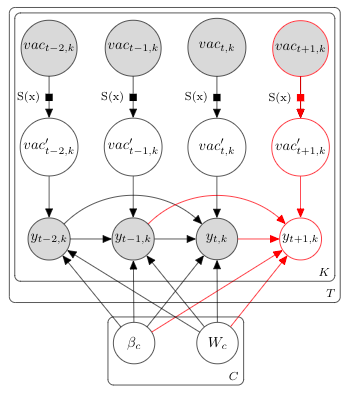

#Installations and Imports

First of all, we apply the usual imports.

In [ ]:
# First, we need to download an auxiliary Python file for STAN
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

--2021-05-27 15:16:02--  http://mlsm.man.dtu.dk/mbml/pystan_utils.py
Resolving mlsm.man.dtu.dk (mlsm.man.dtu.dk)... 192.38.87.226
Connecting to mlsm.man.dtu.dk (mlsm.man.dtu.dk)|192.38.87.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/x-python]
Saving to: ‘pystan_utils.py’

pystan_utils.py     100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-05-27 15:16:03 (217 MB/s) - ‘pystan_utils.py’ saved [2661/2661]



In [ ]:
!ls

pystan_utils.py  sample_data


In [ ]:
#data analysis libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)
import pystan_utils
import pystan
from scipy.linalg import svd
from sklearn.cluster import KMeans
import numpy

In [ ]:
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

# Functions

Next, we define some functions which will be used throughout this notebook.

In [ ]:
# Function that plots the predictions
def plot_predictions(i):
  plt.plot(ix_train, y_train[:, i], "b-")
  plt.plot(ix_test, y_test_mean[:,i], "bx")
  plt.plot(ix_test, y_hat[:,i], "r-")
  plt.plot(ix_test, y_hat[:,i] + y_std[:,i],"r--")
  plt.plot(ix_test, y_hat[:,i] - y_std[:,i], "r--")
  plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

In [ ]:
# Function that computes the correlation, error and accuracy of the model
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
# Function that returns a list of countries
def make_countries_list():
    country_CovidData = list(CovidData['country'].unique())
    country_ExtraData = list(ExtraData2['country'].unique())
    print(str(len(country_CovidData))+ " Countries in CovidData\n" + str(len(country_ExtraData)) + " Countries in ExtraData2")
    return country_CovidData,country_ExtraData

In [ ]:
# Function that replaces countries not matching
def replace_countries(Countries_not_match,Countries_to_replace):
    for i in range(len(Countries_not_match)):
        ExtraData2.replace(Countries_not_match[i],Countries_to_replace[i],inplace=True)

In [ ]:
# Function that displays which countries are matching and which one need changes
def check_countries(CovidData_Countries,ExtraData_Countries):
    count = 0
    countries_ok = []
    countries_not_ok = []
    for i in CovidData_Countries:
        if i in ExtraData_Countries:
            count += 1
            countries_ok.append(i)
        else:
            countries_not_ok.append(i)
    print(str(len(countries_ok)) + " number of countries that match\n" + str(len(countries_not_ok)) + 
         " number of countries that don´t match\n")
    print("Countries that don´t match are:\n" + str(countries_not_ok))
    return countries_ok, countries_not_ok

In [ ]:
#Function that returns the list of countries that will replace the ones that don't match in ExtraData, eliminating
#the ones we just dropped
def drop_from_list(todrop, listorigin):
    for element in todrop:
        if element in listorigin:
            listorigin.remove(element)
    print(listorigin)
    return listorigin

In [ ]:
# Function that standardizes the data
def standardize_model(df):
  df = df.T
  df = (df - np.mean(df)) / np.std(df)
  df = df.T
  return df

In [ ]:
# Function that converts data to weekly and adjusts the data disposition
def convert_to_weekly(df, country_or_cluster, column1, column2):
  dfinter = df.groupby(["Week", country_or_cluster]).max()
  column= df.groupby(["Week", country_or_cluster]).sum()
  dfinter[column1]= column["daily_vaccinations"]
  dfinter[column2]= dfinter["people_fully_vaccinated"]
  
  # Reshape for column 1
  dfinter1= dfinter[column1].unstack(level=-1)
  dfinter1=dfinter1.fillna(0)
  new_index=[49, 50, 51, 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  df1= dfinter1.reindex(new_index)
  df1 = df1.rename(index={53: -1, 52: -2, 51: -3, 50: -4, 49: -5})
  
  # Reshape for column 2
  dfinter2= dfinter[column2].unstack(level=-1)
  dfinter2=dfinter2.fillna(0)
  new_index=[49, 50, 51, 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  df2= dfinter2.reindex(new_index)
  df2 = df2.rename(index={53: -1, 52: -2, 51: -3, 50: -4, 49: -5})
  return df1, df2

#Loading Data

The next step is to load the data which will be analyzed in this project. In particular, two datasets will be used:

1.   CovidData, which contains information on the Covid-19 vaccination process across different countries, such as the daily vaccinations, the number of people vaccinated, the manufacturers and more.
2.   ExtraData2, which contains country-specific information related to economical and social aspects, such as the GDP and the % of investment on health.



In [ ]:
"""
JUPYTER
"""
# from google.colab import files
# uploaded = files.upload()
#CovidData = pd.read_csv("country_vaccinations.csv")
#CovidData["date"] = pd.to_datetime(CovidData["date"], format = "%Y-%m-%d")
#ExtraData2 = pd.read_csv("country_profile_variables.csv")

In [ ]:
"""
COLAB
"""

#from google.colab import drive 
#drive.mount('/content/drive')

#Martina
#CovidData = pd.read_csv('drive/MyDrive/Copia di country_vaccinations.csv')
#ExtraData2 = pd.read_csv('drive/MyDrive/country_profile_variables.csv')
#CovidData["date"] = pd.to_datetime(CovidData["date"], format = "%Y-%m-%d")

#Lorena
# CovidData = pd.read_csv("drive/MyDrive/MBMLproject/country_vaccinations.csv")
# CovidData["date"] = pd.to_datetime(CovidData["date"], format = "%Y-%m-%d")
# ExtraData2 = pd.read_csv("drive/MyDrive/MBMLproject/country_profile_variables.csv")

#Alvaro


# Marcos
#CovidData = pd.read_csv('drive/MyDrive/Copy of country_vaccinations.csv')
#ExtraData2 = pd.read_csv('drive/MyDrive/Copy of country_profile_variables.csv')
#CovidData["date"] = pd.to_datetime(CovidData["date"], format = "%Y-%m-%d")


Mounted at /content/drive


# Data pre-processing

The aim of this section is to ensure that there is a connection between the CovidData and the ExtraData2 datasets. These two datasets will be linked together by the attribute "country". However, prior to this, some cleaning is needed to make both datasets match in terms of country name.

## Country names correction

The functions used are defined in the *Functions* section in case the reader wants to go over them. In any case, the process of data cleaning will be explained step by step.

Before correcting the naming of the countries between the two datasets, the dataframes are filled:

In [ ]:
CovidData.fillna(0, inplace=True)
ExtraData2.fillna(0, inplace=True)

In [ ]:
CovidData.head(10)

country iso_code  ...                source_name            source_website
0  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
1  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
2  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
3  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
4  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
5  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
6  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
7  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
8  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/
9  Afghanistan      AFG  ...  World Health Organization  https://covid19.who.int/

[10 rows x 15 columns]

In [ ]:
ExtraData2.head()

country  ... Net Official Development Assist. received (% of GNI)
0     Afghanistan  ...                                                -99  
1         Albania  ...                                                -99  
2         Algeria  ...                                                -99  
3  American Samoa  ...                                                -99  
4         Andorra  ...                                                -99  

[5 rows x 50 columns]

In [ ]:
CovidData_Countries, ExtraData_Countries = make_countries_list()

211 Countries in CovidData
229 Countries in ExtraData2


In order to start the mapping, lists containing the countries are created with the function *make_countries_list()*. As it can be seen, several countries will not be used for the models, since there are many more countries in the ExtraData2 dataset than in the CovidData one.

In [ ]:
countries_ok,countries_not_ok = check_countries(CovidData_Countries,ExtraData_Countries)

177 number of countries that match
34 number of countries that don´t match

Countries that don´t match are:
['Bolivia', 'Bonaire Sint Eustatius and Saba', 'Brunei', 'Cape Verde', "Cote d'Ivoire", 'Curacao', 'Democratic Republic of Congo', 'England', 'Eswatini', 'Faeroe Islands', 'Falkland Islands', 'Guernsey', 'Hong Kong', 'Iran', 'Jersey', 'Kosovo', 'Laos', 'Macao', 'Moldova', 'North Macedonia', 'Northern Cyprus', 'Northern Ireland', 'Palestine', 'Russia', 'Scotland', 'South Korea', 'Syria', 'Taiwan', 'Timor', 'United States', 'Venezuela', 'Vietnam', 'Wales', 'Wallis and Futuna']


With the lists of the countries in place, it is seen that not all countries that are in CovidData are in ExtraData2 with the function *check_countries()*. This could be possible due to commas, spaces or abreviations in the naming of the countries in one or both of the datasets. A good practice is to display all the names:

In [ ]:
print(ExtraData2["country"].unique())

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bonaire, Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Channel Islands' 'Chile'
 'China, Hong Kong SAR' 'China, Macao SAR' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Falkland Islands (Malvinas)'
 'Faroe Islands'

Due to the nature of the dataset, the aproach followed is to manually correct the country names.

In [ ]:
# Country names that have to be changed in ExtraData dataset so they fit country names in CovidData
Countries_not_match = ['Bolivia (Plurinational State of)','Brunei Darussalam','Cabo Verde','Faroe Islands',
                      'Iran (Islamic Republic of)',"Lao People's Democratic Republic", 'Cyprus', 'State of Palestine'
                      'Russian Federation','Republic of Korea','United States of America',
                      'Venezuela (Bolivarian Republic of)', 'Viet Nam']

# Countries that will be dropped in Covid Dataset because they don't exist in ExtraData
Countries_not_ex = ["Cote d'Ivoire", 'England', 'Falkland Islands', 'Guernsey', 'Hong Kong', 'Jersey', 'Kosovo','Macao'
                   ,'Moldova','North Macedonia', 'Northern Ireland', 'Scotland', 'Taiwan','Wales']

In [ ]:
# Remove countries that do not exist in CoviData
print("Length of CovidData dataset prior to dropping countries:", len(CovidData))
CovidData = CovidData[~CovidData.country.isin(Countries_not_ex)]
print("Length of CovidData dataset after dropping countries:", len(CovidData))

Length of CovidData dataset prior to dropping countries: 17607
Length of CovidData dataset after dropping countries: 16374


In [ ]:
 Countries_to_replace = drop_from_list(Countries_not_ex,countries_not_ok)

['Bolivia', 'Bonaire Sint Eustatius and Saba', 'Brunei', 'Cape Verde', 'Curacao', 'Democratic Republic of Congo', 'Eswatini', 'Faeroe Islands', 'Iran', 'Laos', 'Northern Cyprus', 'Palestine', 'Russia', 'South Korea', 'Syria', 'Timor', 'United States', 'Venezuela', 'Vietnam', 'Wallis and Futuna']


In [ ]:
replace_countries(Countries_not_match,Countries_to_replace)

In [ ]:
CovidData_Countries, ExtraData_Countries = make_countries_list()

197 Countries in CovidData
229 Countries in ExtraData2


In [ ]:
countries_ok,countries_not_ok = check_countries(CovidData_Countries,ExtraData_Countries)

187 number of countries that match
10 number of countries that don´t match

Countries that don´t match are:
['Cyprus', 'Faeroe Islands', 'Russia', 'South Korea', 'Syria', 'Timor', 'United States', 'Venezuela', 'Vietnam', 'Wallis and Futuna']


In [ ]:
type(countries_not_ok)

list

In [ ]:
print("Length of CovidData dataset prior to dropping countries:", len(CovidData))
CovidData = CovidData[~CovidData.country.isin(countries_not_ok)]
print("Length of CovidData dataset after dropping countries:", len(CovidData))

Length of CovidData dataset prior to dropping countries: 16374
Length of CovidData dataset after dropping countries: 15539


In [ ]:
CovidData_Countries, ExtraData_Countries = make_countries_list()

187 Countries in CovidData
229 Countries in ExtraData2


In [ ]:
countries_ok,countries_not_ok = check_countries(CovidData_Countries,ExtraData_Countries)

187 number of countries that match
0 number of countries that don´t match

Countries that don´t match are:
[]


As we can see, now the countries that do not match is an empty array, meaning that the countries in between the two datasets are identical. Therefore, we can proceed with the clustering of the countries.

## PCA Clustering


To cluster the countries into 5 groups, a Principal component analysis is done. In this way, we can tell which are the most important features and maintain the explainability along the process.

In [ ]:
columns_to_use = ["Population in thousands (2017)", "Population density (per km2, 2017)", "Sex ratio (m per 100 f, 2017)",
                  "CO2 emission estimates (million tons/tons per capita)", "GDP per capita (current US$)", "Health: Total expenditure (% of GDP)",
                  ]

X = ExtraData2[columns_to_use]
X.head()

Population in thousands (2017)  ...  Health: Total expenditure (% of GDP)
0                           35530  ...                                   8.2
1                            2930  ...                                   5.9
2                           41318  ...                                   7.2
3                              56  ...                                 -99.0
4                              77  ...                                   8.1

[5 rows x 6 columns]

Before starting the process, we will standardize the data:

In [ ]:
mu = np.mean(X)
sigma = np.std(X)
X = (X - mu) / sigma

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


To get a clear idea of how the dataset's features are correlated, it is a good idea to plot the correlation matrix:

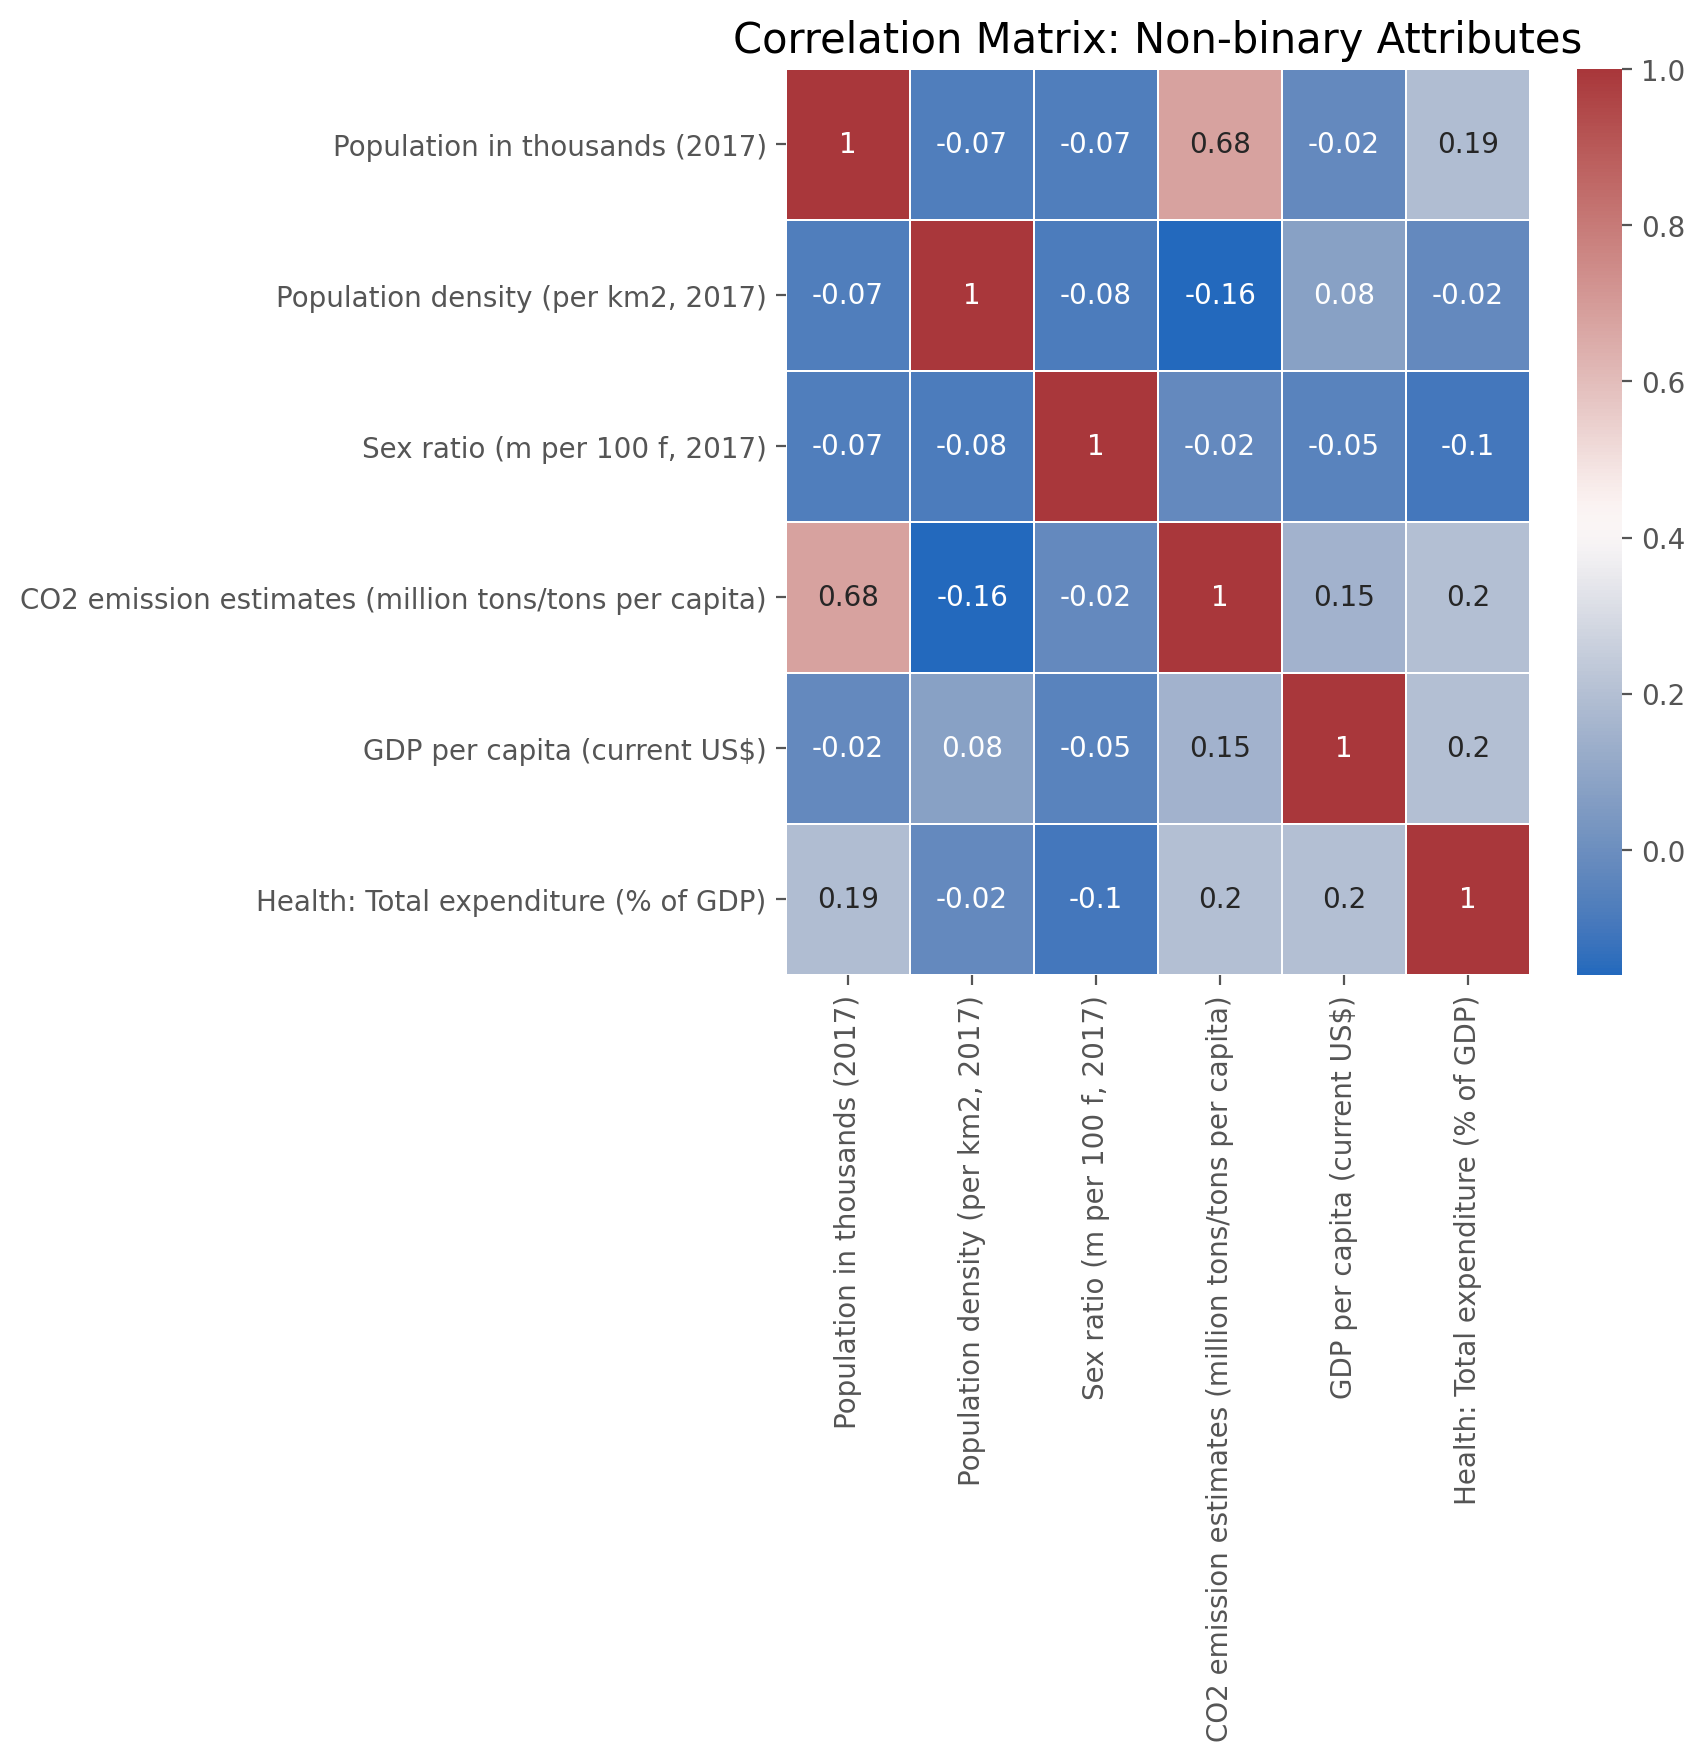

In [ ]:
font=15

X_corr = pd.DataFrame(X)
corrMatrix = X_corr.corr(method="kendall")
corrMatrix = corrMatrix.round(2)

fig, ax = plt.subplots(figsize=(6,6),dpi=100)   # Sample figsize in inches

heatmap = sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax, cmap="vlag")
heatmap.set_title("Correlation Matrix: Non-binary Attributes", fontsize=font)

plt.show()

With this in mind, we perform the PCA and look into the importance of every feature:

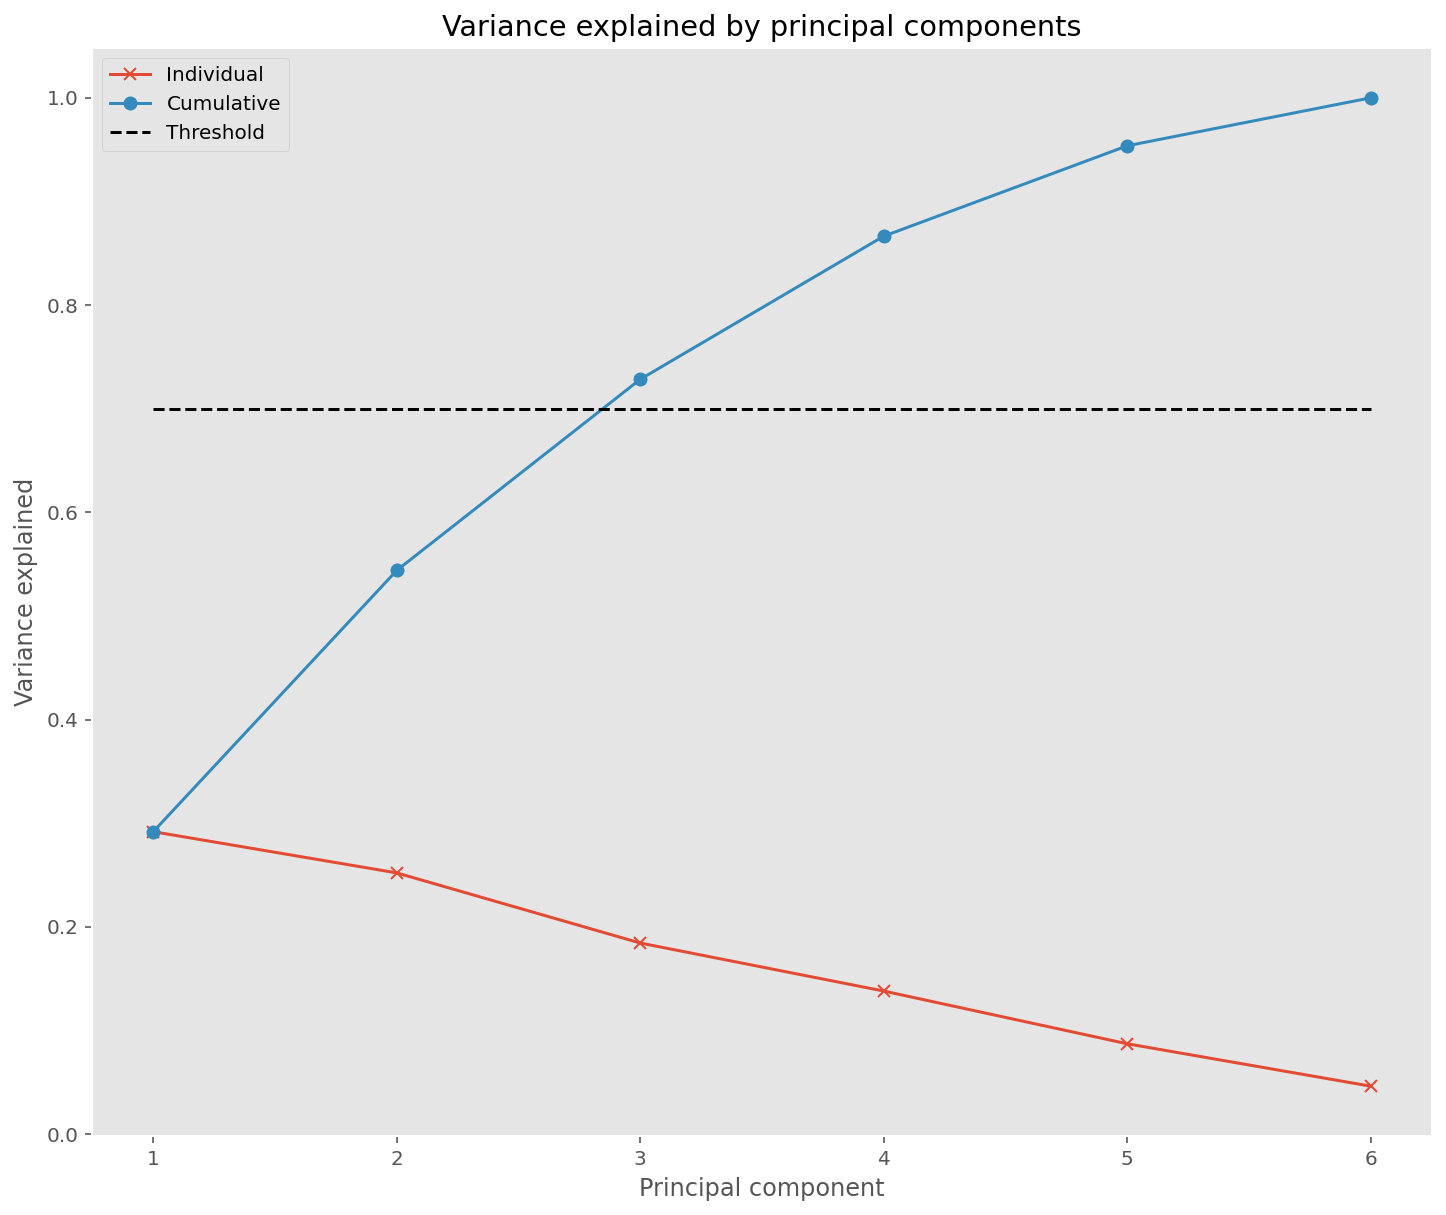

In [ ]:
U,S,Vh = svd(X,full_matrices=False)
V = Vh.T

threshold = 0.7
rho = (S*S) / (S*S).sum() 

# Plot variance explained
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.savefig('Variance_explained.png')
plt.show()

To reduce complexity but keep the explainability of the dataset, the threshold is set in 70%. This threshold is already achieved with the first 3 principal components.

Let's look at the contribution of every attribute:

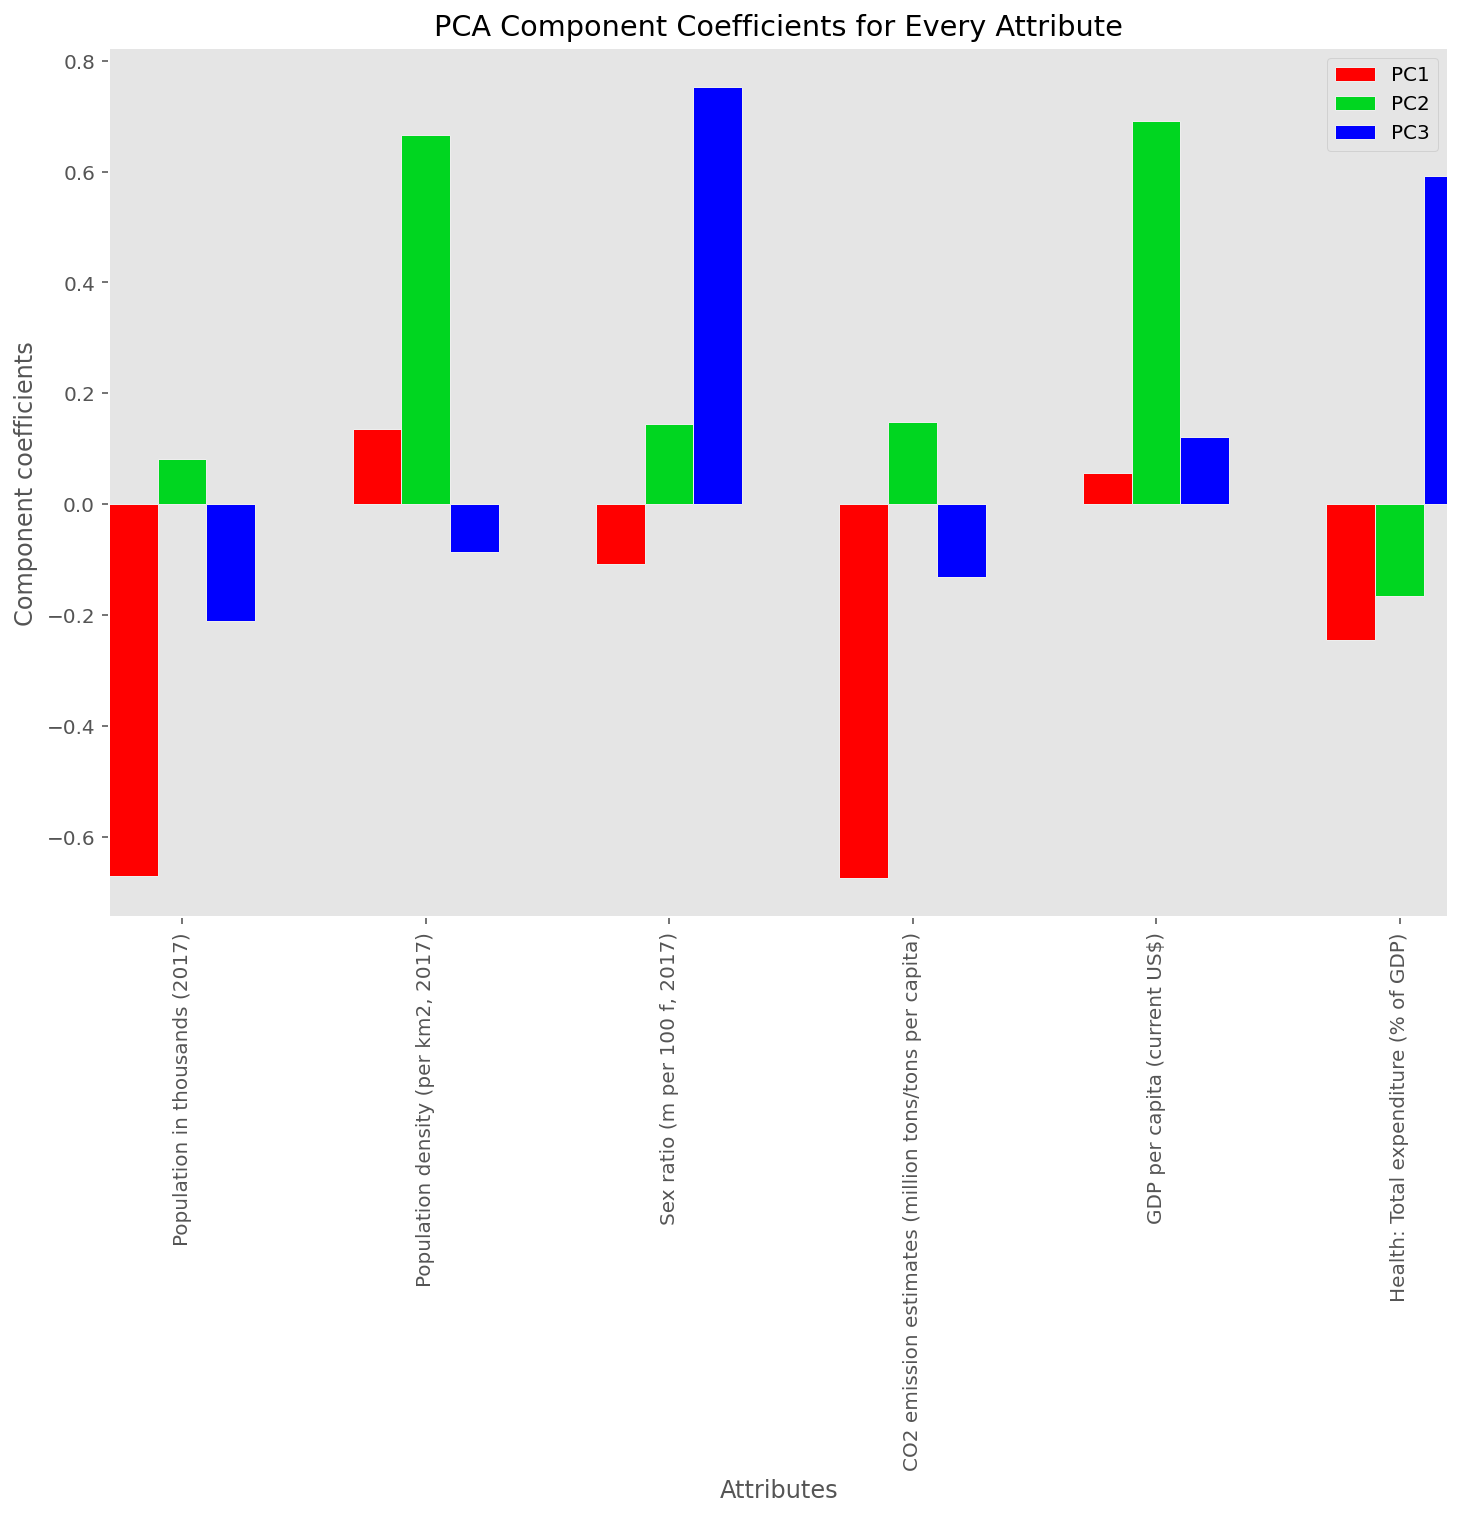

In [ ]:
# Subtract mean value from data
N,M = X.shape

# Figure size
f = plt.figure(figsize=(12, 8))
plt.rc('axes', axisbelow=True)

pcs = [0,1,2]
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','#00d620','b']
bw = .2
r = np.arange(1,M+1)

plt.rcParams["patch.force_edgecolor"] = True

for i in pcs:    
    plt.bar(r+i*bw, V[:,i], width=bw, color=c[i])
    plt.xlim(0.9,len(V[:,i])+0.4)
    
plt.xticks(r+bw, X.columns, rotation=90)

plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs)
plt.grid()
plt.title('PCA Component Coefficients for Every Attribute')
plt.savefig('Component coefficients.png')
plt.show()

Having looked into what attributes are key for the interpretability of the dataset, now the clustering can be performed. The data is given the adequate format below:

In [ ]:
Y = X.values - np.ones((N,1))* X.values.mean(0)
Z = Y @ V

Now the clustering is performed. The KMEANS algorithm has been chosen, since it is very practical and straightforward in choosing the number of clusters, in our case, 5.

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [ ]:
kmeans.fit(Z[:,:2])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [ ]:
cluster = kmeans.predict(Z[:,:2])

The main reason why the PCA is used is to increase the interpretability and robustness of the clustering. 

Regarding the interpretability, it would be counterintuitive to think it is increased, since moving away from the real attributes reduces interpretability. However, on the other hand, doing a PCA allows the data points (the countries) to be projected into a 2-dimensional space so one can visually understand the clusters.

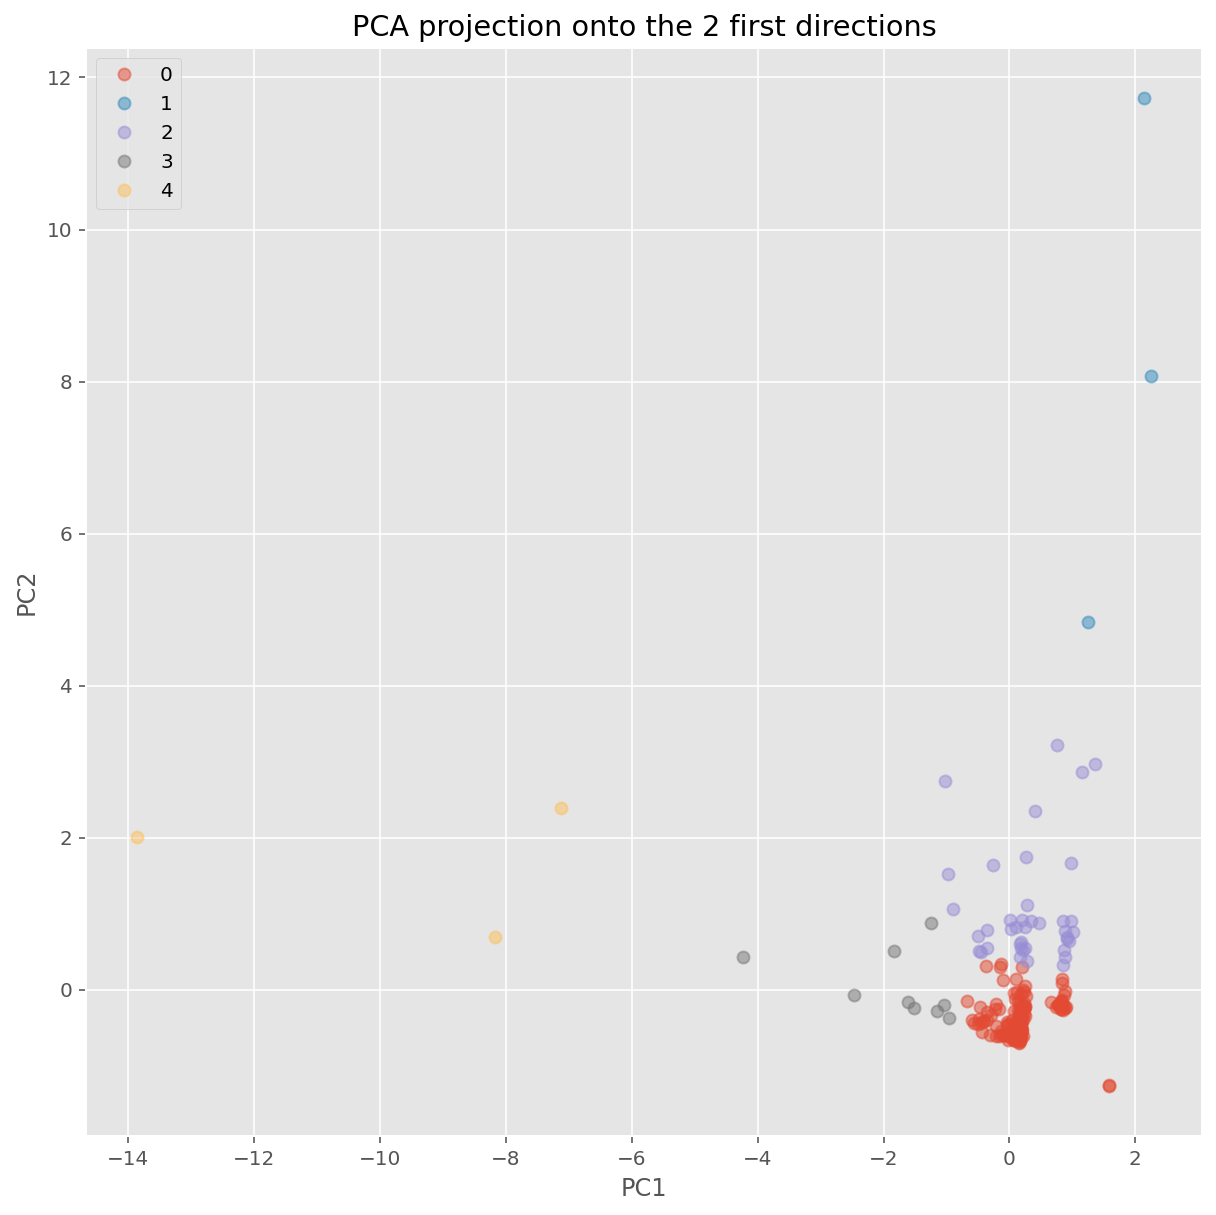

<Figure size 864x720 with 0 Axes>

In [ ]:
classLabels = set(cluster)
classNames = sorted(set(classLabels))
C = len(classNames)

# Indices of the principal components to be plotted
i = 0
j = 1

# Plot PCA of the data
f = plt.figure(figsize=(10, 10))
plt.title('PCA projection onto the 2 first directions')
for c in range(C):
    # select indices belonging to class c:
    class_mask = cluster==c
    plt.plot(Z[class_mask,i], Z[class_mask,j], 'o', alpha=.5)

plt.legend(classNames)
plt.xlabel('PC{0}'.format(i+1))
plt.ylabel('PC{0}'.format(j+1))

# Output result to screen
plt.show()
plt.savefig("Clustering.png")

In [ ]:
(unique, counts) = np.unique(cluster, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0 174]
 [  1   3]
 [  2  40]
 [  3   9]
 [  4   3]]


Finally, the countries per cluster can be seen below, as well as a World map displaying the countries* by colors. 

<font size= 2>* *Unfortunately the tool used does not recognise all countries as such, and, for instance, coutnries such as Laos, Monaco or Andorra are not displayed.*<font>

In [ ]:
ExtraData2[cluster==0]["country"].values

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan',
       'Bahamas', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana',
       'Bonaire Sint Eustatius and Saba', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Brunei', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Croatia', 'Cuba', 'Eswatini', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Falkland Islands (Malvinas)', 'Cape Verde', 'Fiji',
       'French Guiana', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'G

In [ ]:
ExtraData2[cluster==1]["country"].values

array(['China, Macao SAR', 'Liechtenstein', 'Monaco'], dtype=object)

In [ ]:
ExtraData2[cluster==2]["country"].values

array(['Andorra', 'Anguilla', 'Aruba', 'Australia', 'Austria', 'Bahrain',
       'Belgium', 'Bermuda', 'British Virgin Islands', 'Cayman Islands',
       'China, Hong Kong SAR', 'Denmark', 'Finland', 'France',
       'French Polynesia', 'Germany', 'Gibraltar', 'Greenland',
       'Holy See', 'Iceland', 'Ireland', 'Israel', 'Japan', 'Kuwait',
       'Luxembourg', 'Malta', 'Netherlands', 'New Caledonia',
       'New Zealand', 'Norway', 'Puerto Rico', 'Qatar', 'San Marino',
       'Singapore', 'Sint Maarten (Dutch part)', 'Sweden', 'Switzerland',
       'Turks and Caicos Islands', 'United Arab Emirates',
       'United Kingdom'], dtype=object)

In [ ]:
ExtraData2[cluster==3]["country"].values

array(['Brazil', 'Canada', 'Indonesia', 'Curacao', 'Mexico', 'Nigeria',
       'Pakistan', 'Russian Federation', 'Saudi Arabia'], dtype=object)

In [ ]:
ExtraData2[cluster==4]["country"].values

array(['China', 'India', 'Laos'], dtype=object)

In [ ]:
ExtraData2["cluster"] = cluster

In [ ]:
df_clust = ExtraData2

In [ ]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 13.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=501481b99bf224a4de1c0fd88dcdc7ebec978da8e2ddbf7879f2a8a13010c5d4
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
import pycountry
import plotly.express as px
import pandas as pd
# ----------- Step 1 ------------

# print(df1.head) # Uncomment to see what the dataframe is like
# ----------- Step 2 ------------
list_countries = df_clust['country'].unique().tolist()
# print(list_countries) # Uncomment to see list of countries
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})

# print(d_country_code) # Uncomment to check dictionary  

# create a new column iso_alpha in the df
# and fill it with appropriate iso 3 code
for k, v in d_country_code.items():
    df_clust.loc[(df_clust.country == k), 'iso_alpha'] = v

print(df_clust.head)  # Uncomment to confirm that ISO codes added
# ----------- Step 3 ------------
fig = px.choropleth(data_frame = df_clust,
                    locations= "iso_alpha",
                    color= "cluster",  # value in column 'Confirmed' determines color
                    hover_name= "country",
                    color_continuous_scale= 'RdYlGn',  #  color scale red, yellow green
                    title = "Clusters based on Population, Population density, GDP per capita, Sex ration (M/ 100 F), CO2 emissions, Health expenditure (% of GDP)"
                    )

fig.show()

could not add ISO 3 code for -> Bonaire Sint Eustatius and Saba
could not add ISO 3 code for -> Channel Islands
could not add ISO 3 code for -> China, Hong Kong SAR
could not add ISO 3 code for -> China, Macao SAR
could not add ISO 3 code for -> Democratic Republic of the Congo
could not add ISO 3 code for -> Cape Verde
could not add ISO 3 code for -> Micronesia (Federated States of)
could not add ISO 3 code for -> Swaziland
could not add ISO 3 code for -> The former Yugoslav Republic of Macedonia
could not add ISO 3 code for -> Laos
could not add ISO 3 code for -> United States Virgin Islands
could not add ISO 3 code for -> Northern Cyprus
could not add ISO 3 code for -> Wallis and Futuna Islands
<bound method NDFrame.head of                        country          Region  ... cluster  iso_alpha
0                  Afghanistan    SouthernAsia  ...       0        AFG
1                      Albania  SouthernEurope  ...       0        ALB
2                      Algeria  NorthernAfrica  ..

## Merging

After having identified the clusters, it is time to merge this information together with the CovidData dataset, so that each country corresponds to a unique cluster.

In [ ]:
CovidData = CovidData[["country",	"date",	"total_vaccinations",	"people_vaccinated",	"people_fully_vaccinated",	"daily_vaccinations"]]
df = CovidData.merge(df_clust, on = "country", how = "inner") # A inner join is used so that countries
                                                             # that don´t match are not problematic
df.head()

country       date  ...  cluster  iso_alpha
0  Afghanistan 2021-02-22  ...        0        AFG
1  Afghanistan 2021-02-23  ...        0        AFG
2  Afghanistan 2021-02-24  ...        0        AFG
3  Afghanistan 2021-02-25  ...        0        AFG
4  Afghanistan 2021-02-26  ...        0        AFG

[5 rows x 57 columns]

## Countries: Reshaping of temporal data

In the following section the dataframe *df* will be restructured into *df4* and *dfinal2*, so that it is possible to contain in two different dataframes a matrix with the countries and information on the vaccinations. The intersection in between rows and columns provides the sum of the daily vaccinations in *df4*. On the other hand, *dfinal2* provides the no. of people fully vaccinated in a given country for a given week.

In [ ]:
df["Week"]= df['date'].dt.week
df['people_fully_vaccinated'] = df['people_fully_vaccinated'].fillna(0)
df['daily_vaccinations'] = df['daily_vaccinations'].fillna(0)
df.drop('date', axis='columns', inplace=True)
df.head()

country  total_vaccinations  people_vaccinated  ...  cluster  iso_alpha Week
0  Afghanistan                 0.0                0.0  ...        0        AFG    8
1  Afghanistan                 0.0                0.0  ...        0        AFG    8
2  Afghanistan                 0.0                0.0  ...        0        AFG    8
3  Afghanistan                 0.0                0.0  ...        0        AFG    8
4  Afghanistan                 0.0                0.0  ...        0        AFG    8

[5 rows x 57 columns]

A *cluster* array is created, containing the cluster number for each country. This obejct will be used later for the STAN model.

In [ ]:
cluster = df.groupby(["country"])['cluster'].unique()
cluster = cluster.to_numpy(dtype=float)
cluster = cluster.astype(int)
print("Array of clusters:" , cluster)
print("Cluster size:", cluster.size)

Array of clusters: [0 0 0 2 0 2 0 0 0 2 2 2 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 3 0 0 0 0 3 0 2 0 0
 4 0 0 0 0 0 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 2 0 2 0 2 0 0 0 0
 0 0 0 2 4 3 0 0 2 0 2 0 0 2 0 0 0 2 0 4 0 0 0 0 0 1 0 2 0 0 0 0 0 2 0 0 3
 1 0 0 0 0 0 0 0 0 0 2 2 2 0 0 3 0 2 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2
 0 3 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 2 2 0 0 0
 0 0]
Cluster size: 187


In [ ]:
df4, dfinal2 = convert_to_weekly(df, "country", "week_vaccinations", "week_people_fully_vaccinated")

In [ ]:
df4.head()

country  Afghanistan  Albania  Algeria  ...  Yemen  Zambia  Zimbabwe
Week                                    ...                         
-5               0.0      0.0      0.0  ...    0.0     0.0       0.0
-4               0.0      0.0      0.0  ...    0.0     0.0       0.0
-3               0.0      0.0      0.0  ...    0.0     0.0       0.0
-2               0.0      0.0      0.0  ...    0.0     0.0       0.0
-1               0.0      0.0      0.0  ...    0.0     0.0       0.0

[5 rows x 187 columns]

In [ ]:
dfinal2.head()

country  Afghanistan  Albania  Algeria  ...  Yemen  Zambia  Zimbabwe
Week                                    ...                         
-5               0.0      0.0      0.0  ...    0.0     0.0       0.0
-4               0.0      0.0      0.0  ...    0.0     0.0       0.0
-3               0.0      0.0      0.0  ...    0.0     0.0       0.0
-2               0.0      0.0      0.0  ...    0.0     0.0       0.0
-1               0.0      0.0      0.0  ...    0.0     0.0       0.0

[5 rows x 187 columns]

We can now plot the weekly vaccinations across all countries. As it can be seen, most curves have a high slope, which would make it difficult to feed this data directly into a temporal model. However, we will progressively investigate how to improve the model and the data.

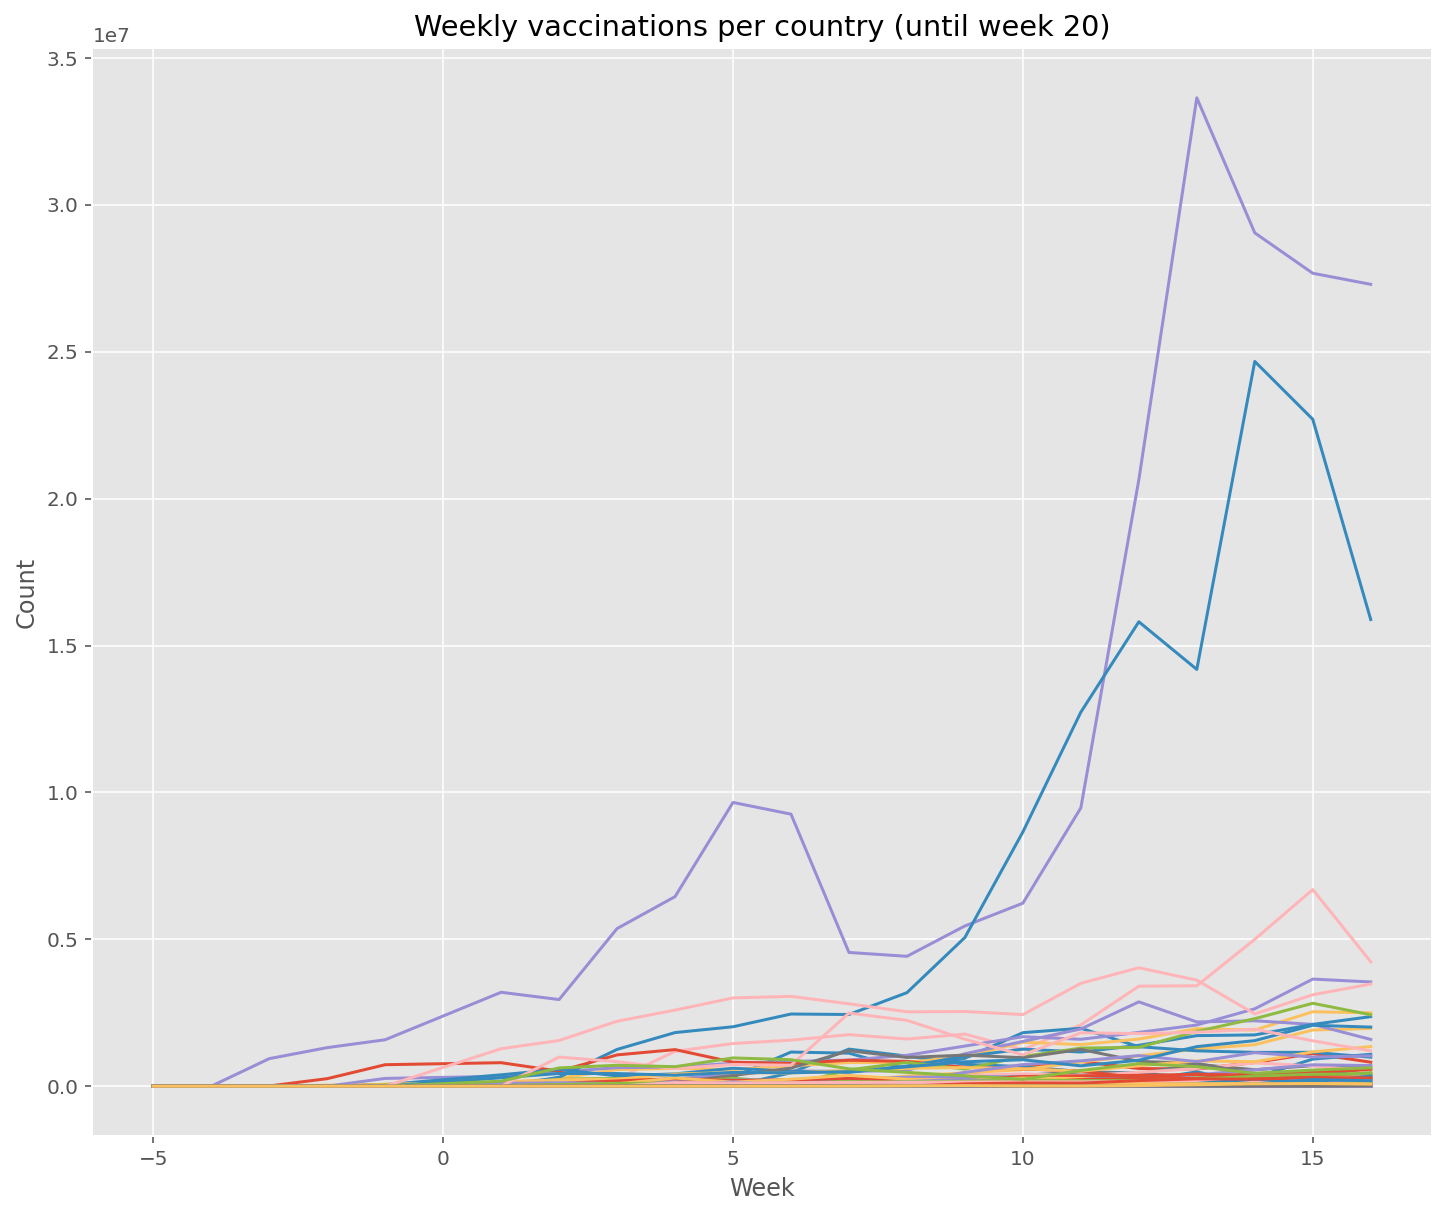

In [ ]:
for i in range(0,len(df4.columns)):
  plt.plot(df4.index[:21], df4.iloc[:21,i])
plt.title("Weekly vaccinations per country (until week 20)")
plt.xlabel('Week');
plt.ylabel('Count');
plt.show()

In the same way, we can plot the number of people fully vaccinated.

Text(0, 0.5, 'Count')

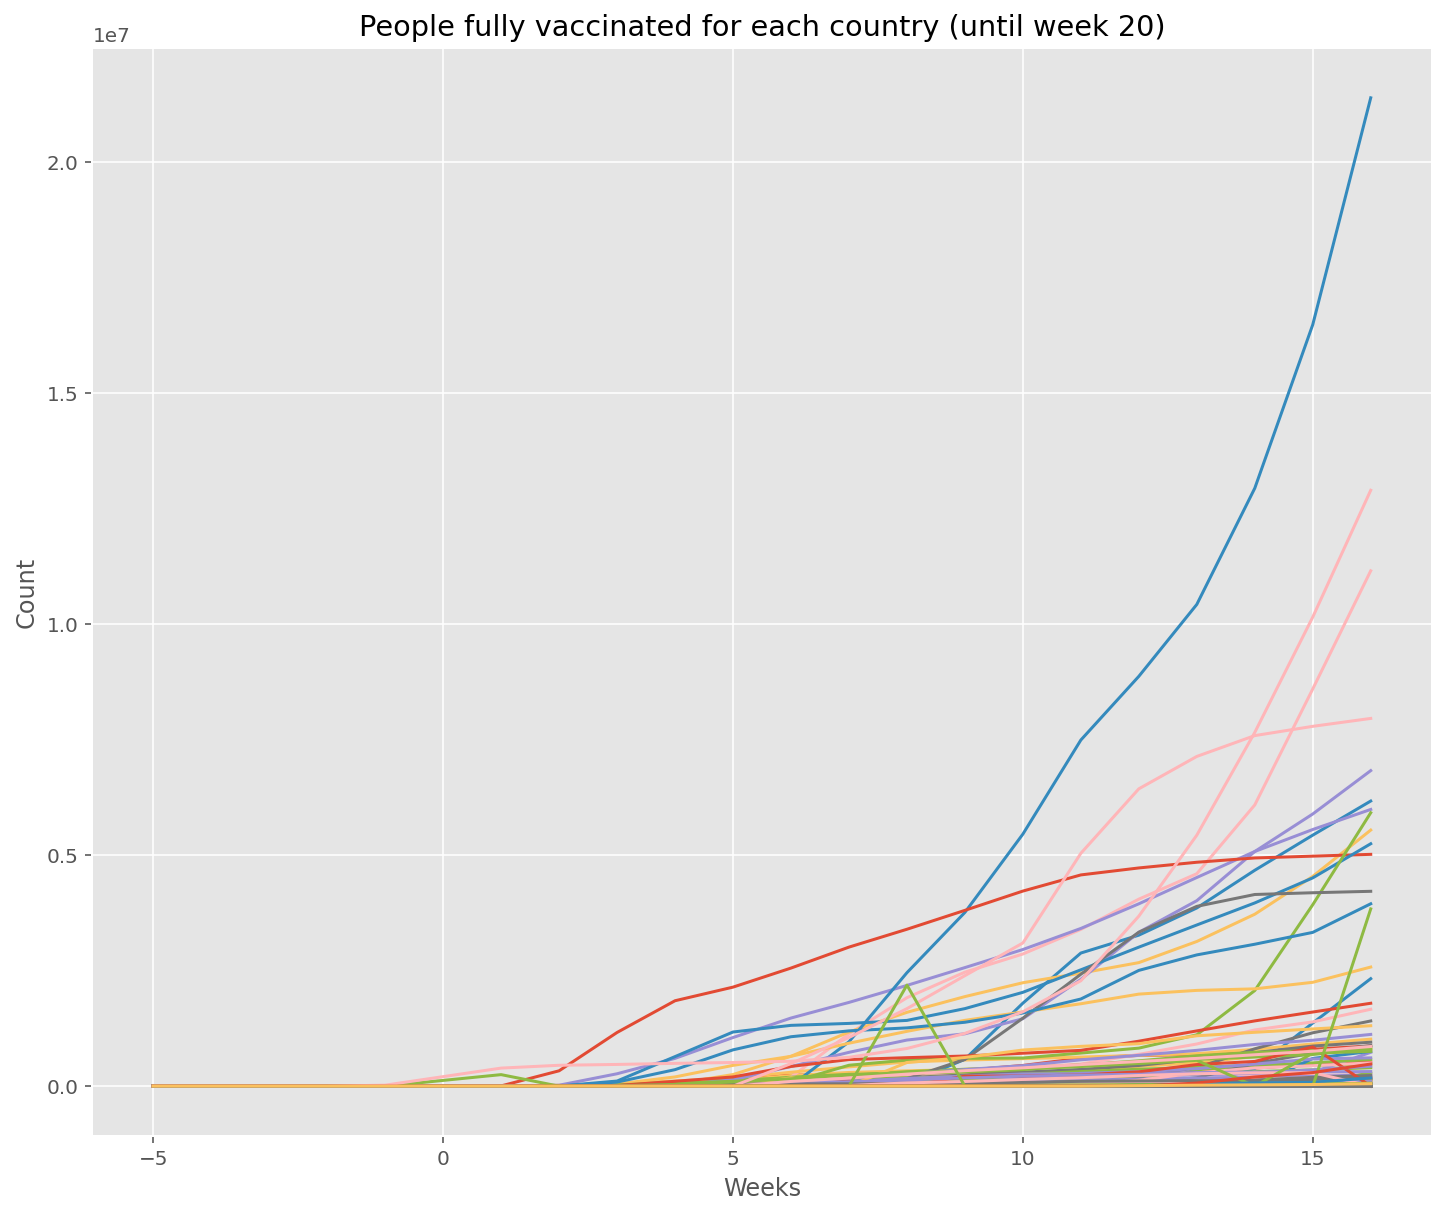

In [ ]:
for i in range(0,len(dfinal2.columns)):
  plt.plot(dfinal2.index[:21], dfinal2.iloc[:21,i])
plt.title("People fully vaccinated for each country (until week 20)")
plt.xlabel("Weeks")
plt.ylabel("Count")

## Clusters: Reshaping of temporal data

As for the countries, two dataframes called *dfinal* and *dfinal1* are created from *df* to contain the weekly vaccinations and the weekly no. of people fully vaccinated for every cluster.

In [ ]:
df['people_fully_vaccinated'] = df['people_fully_vaccinated'].fillna(0)
df['daily_vaccinations'] = df['daily_vaccinations'].fillna(0)
df.head()

country  total_vaccinations  people_vaccinated  ...  cluster  iso_alpha Week
0  Afghanistan                 0.0                0.0  ...        0        AFG    8
1  Afghanistan                 0.0                0.0  ...        0        AFG    8
2  Afghanistan                 0.0                0.0  ...        0        AFG    8
3  Afghanistan                 0.0                0.0  ...        0        AFG    8
4  Afghanistan                 0.0                0.0  ...        0        AFG    8

[5 rows x 57 columns]

In [ ]:
dfinal, dfinal1 = convert_to_weekly(df, "cluster", "week_vaccinations", "week_people_fully_vaccinated")

Text(0, 0.5, 'Count')

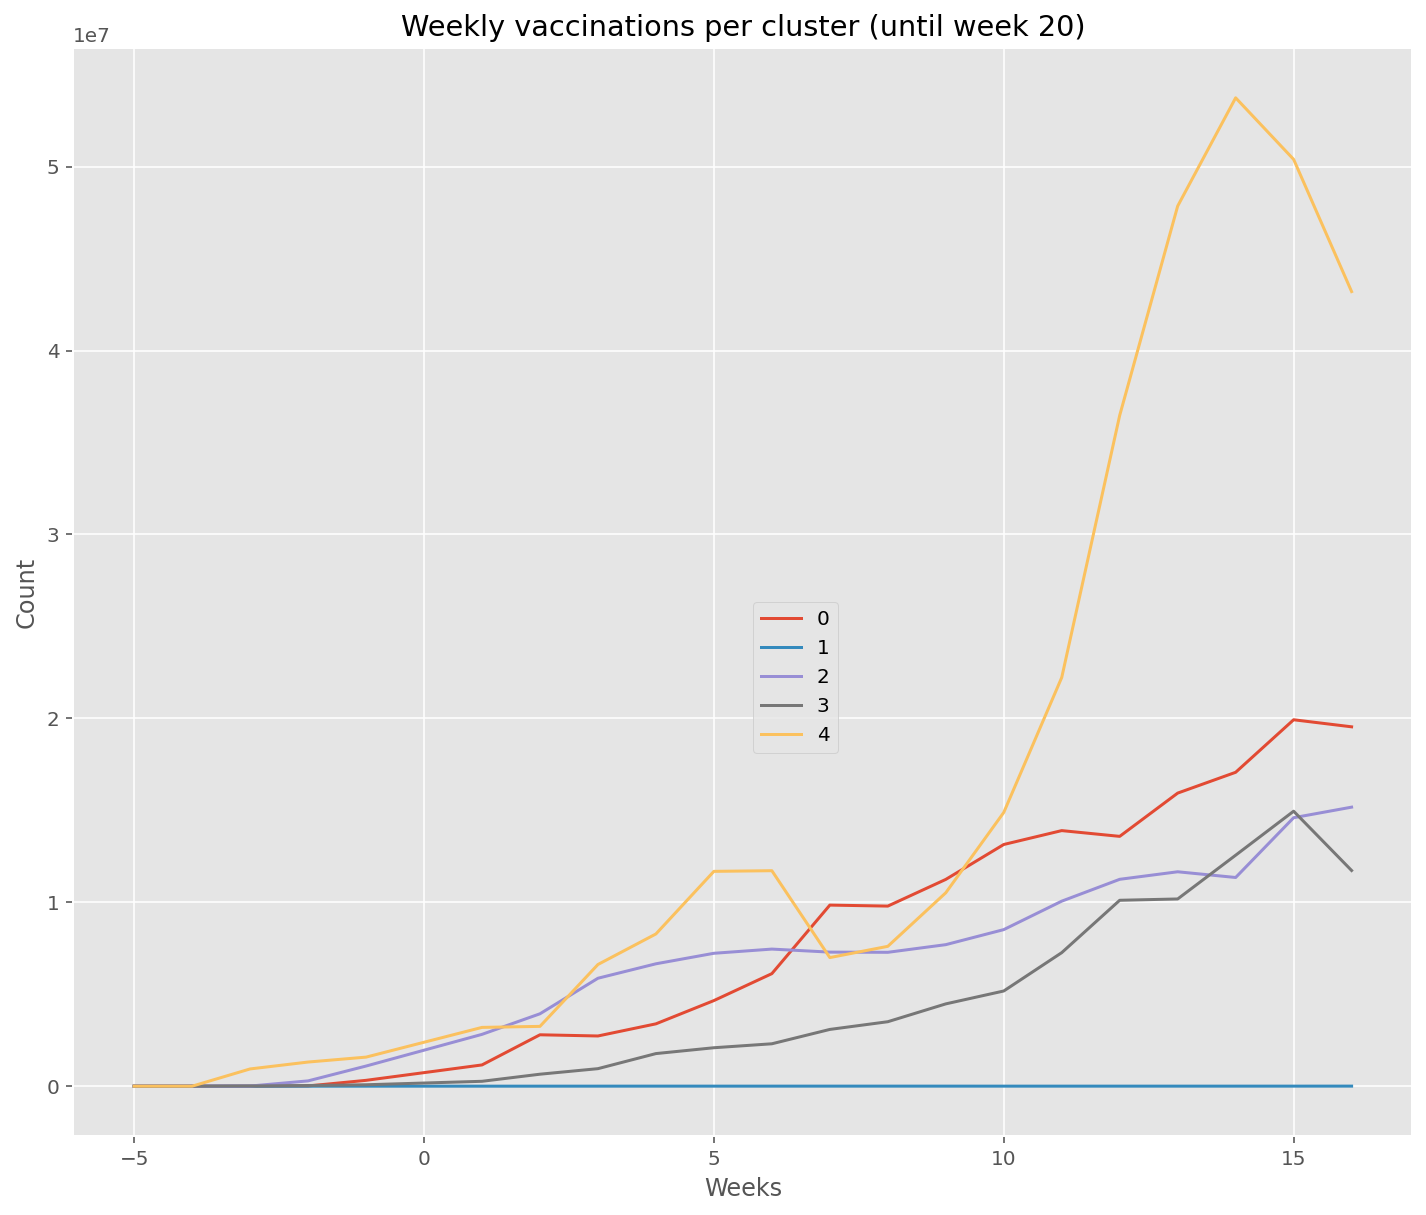

In [ ]:
for i in range(0,5):
  plt.plot(dfinal.index[:21], dfinal.iloc[:21,i])
plt.legend(dfinal.columns[:], loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title("Weekly vaccinations per cluster (until week 20)")
plt.xlabel("Weeks")
plt.ylabel("Count")

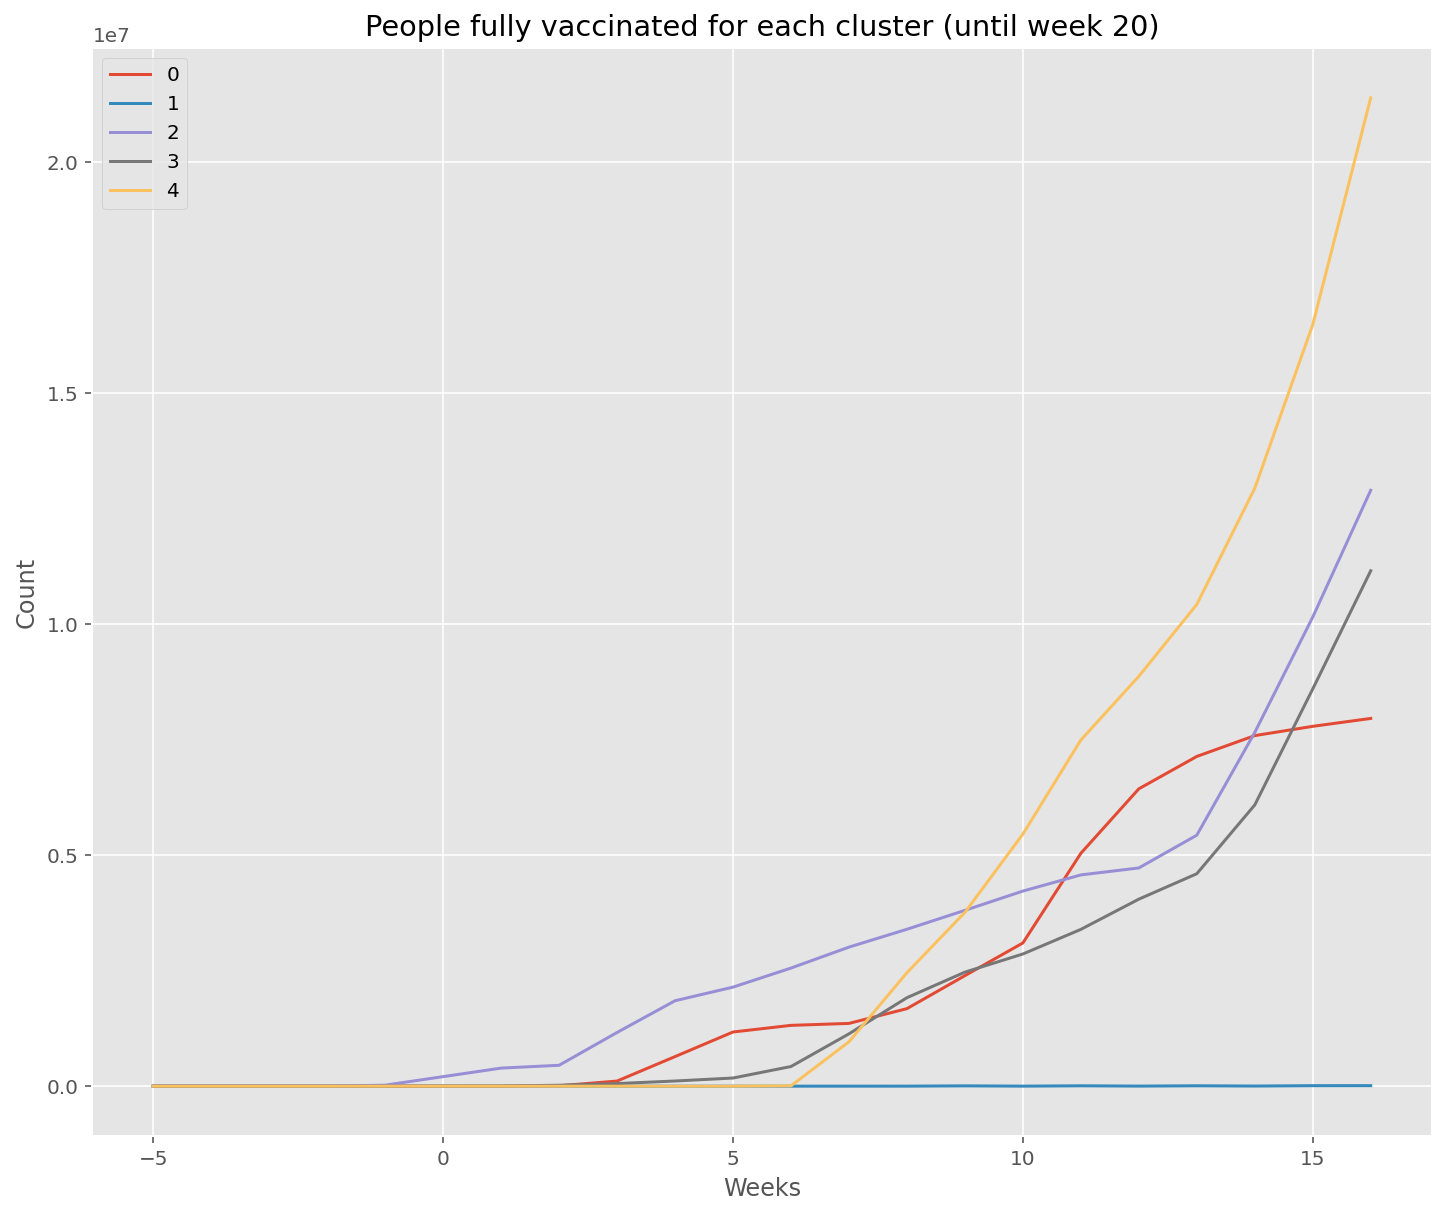

In [ ]:
for i in range(0,5):
  plt.plot(dfinal1.index[:21], dfinal1.iloc[:21,i])
  plt.legend(dfinal1.columns[:])
  plt.title("People fully vaccinated for each cluster (until week 20)")
  plt.xlabel("Weeks")
  plt.ylabel("Count")

# Predictions

After having prepared and adapted the data for our temporal model, we can now predict the weekly vaccinations.

## Organizing the data

Firstly, we divide the data for training and testing. In particular, 19 weeks will be used for training and 2 weeks for testing.

In [ ]:
# Fix random generator seed (for reproducibility of results)
np.random.seed(42)
# Convert data to a matrix
y = df4.to_numpy()
N, D = y.shape
y = y.astype(int)
print("Number of weeks:", N)
print("Number of countries:", D)
print("Weekly vaccinations:", y)

Number of weeks: 24
Number of countries: 187
Weekly vaccinations: [[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 ...
 [ 92372  77469      0 ...      0  18510 124444]
 [ 97447 111016      0 ...      0  35822 133961]
 [ 27842  36667      0 ...      0  14580  65324]]


From the CovidData dataset, it seems the figures are updated from the websites on a monthly basis, therefore the last four weeks of the dataset will not be considered. In fact, if in the previous section we had plotted the weekly vaccinations until week 24, there would have been a downward trend for the last time periods.

This would not only lead to misleading results in the vaccination progress, but also would result in a poor performance of the model which would not be able to forecast a decresing slope, given until week 20 a growing curve.

In [ ]:
ix_train = range(19) # 19 weeks for training
ix_test = range(19, 21) # 2 weeks for testing
N_train = len(ix_train)
N_test = len(ix_test)
N=N_train+N_test
print('Number of weeks:', N)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train, :]
y_test = y[ix_test, :]
print("Shape of y:", y_train.shape)

Number of weeks: 21
N_train: 19
N_test: 2
Shape of y: (19, 187)


STAN does not index from 0, so we add 1 to the cluster numbers.

In [ ]:
cluster = cluster + 1
print(cluster)

[1 1 1 3 1 3 1 1 1 3 3 3 1 1 3 1 1 1 3 1 1 3 1 1 1 1 1 4 1 1 1 1 4 1 3 1 1
 5 1 1 1 1 1 1 4 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 3 1 3 1 3 1 1 1 1
 1 1 1 3 5 4 1 1 3 1 3 1 1 3 1 1 1 3 1 5 1 1 1 1 1 2 1 3 1 1 1 1 1 3 1 1 4
 2 1 1 1 1 1 1 1 1 1 3 3 3 1 1 4 1 3 1 4 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3
 1 4 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 3 1 1 1 3 3 1 1 1
 1 1]


##  2.1 AR(1) model: country-specific vaccination forecast

The following model is an Autoregressive (AR) model of order 1, meaning that to predict the weekly vaccinations for country *k* in period *t+1*, the weekly vaccinations in period *t* will be considered.

In this case, the model will perform inference on the coefficient *b* and standard deviation *W* for each country.

In [ ]:
# Define Stan model
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int K;  // num. countries
    matrix[T,K] y;                 // time-series data
}

parameters {
    vector[K] b;            // state transition coefficients
    vector<lower=0>[K] W;         // state transition coefficients 
}

model {
  for(k in 1:K) {
    b[k] ~ normal(1,0.5);             // prior on the auto-regressive coefficients
   	W[k] ~ cauchy(1000,1000);             // prior on the auto-regressive coefficients
  }
    
  for(k in 1:K) {
    for(t in 2:T) {
      y[t,k] ~ normal(b[k]' * y[t-1,k], W[k]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,K] y_hat;          // vector to store predictions

  for(k in 1:K) {
    y_hat[1,k] <- normal_rng(b[k]' * y[T,k], W[k]);  // predictions
  }

  for(k in 1:K) {
    for (t in 2:T_forecast) {
      y_hat[t,k] <- normal_rng(b[k]' * y_hat[t-1,k], W[k]);  // predictions
    }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
K = D
data = {'T': T, 'T_forecast': T_forecast, 'K': D,'y': y_train}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be4c568a1fa9f4bd218abb8a1a61f7e5 NOW.


CPU times: user 1.45 s, sys: 106 ms, total: 1.56 s
Wall time: 1min 16s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_be4c568a1fa9f4bd218abb8a1a61f7e5.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                  mean se_mean       sd      2.5%       25%       50%       75%    97.5%  n_eff   Rhat
b[1]              1.13    0.04     0.06      1.04      1.07      1.13      1.19     1.22      3   4.56
b[2]              1.07    0.08     0.14      0.87      1.01      1.03       1.1     1.35      3   10.9
b[3]              0.87     0.1     0.17      0.62      0.75      0.85       1.0     1.12      3  11.35
b[4]              1.16     0.1     0.18       0.8      1.13      1.19      1.24      1.4      3   14.4
b[5]              1.21    0.02     0.04      1.13      1.17      1.21      1.26     1.27      3   5.69
b[6]              0.84    0.08     0.14      0.62      0.69      0.89      0.93     1.01      3   8.52
b[7]              0.98    0.04     0.07      0.87      0.91      0.95      1.04     1.08    

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean = np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 187)
y_test.shape: (2, 187)
y_hat_mean.shape: (2, 187)



We can now plot the samples...

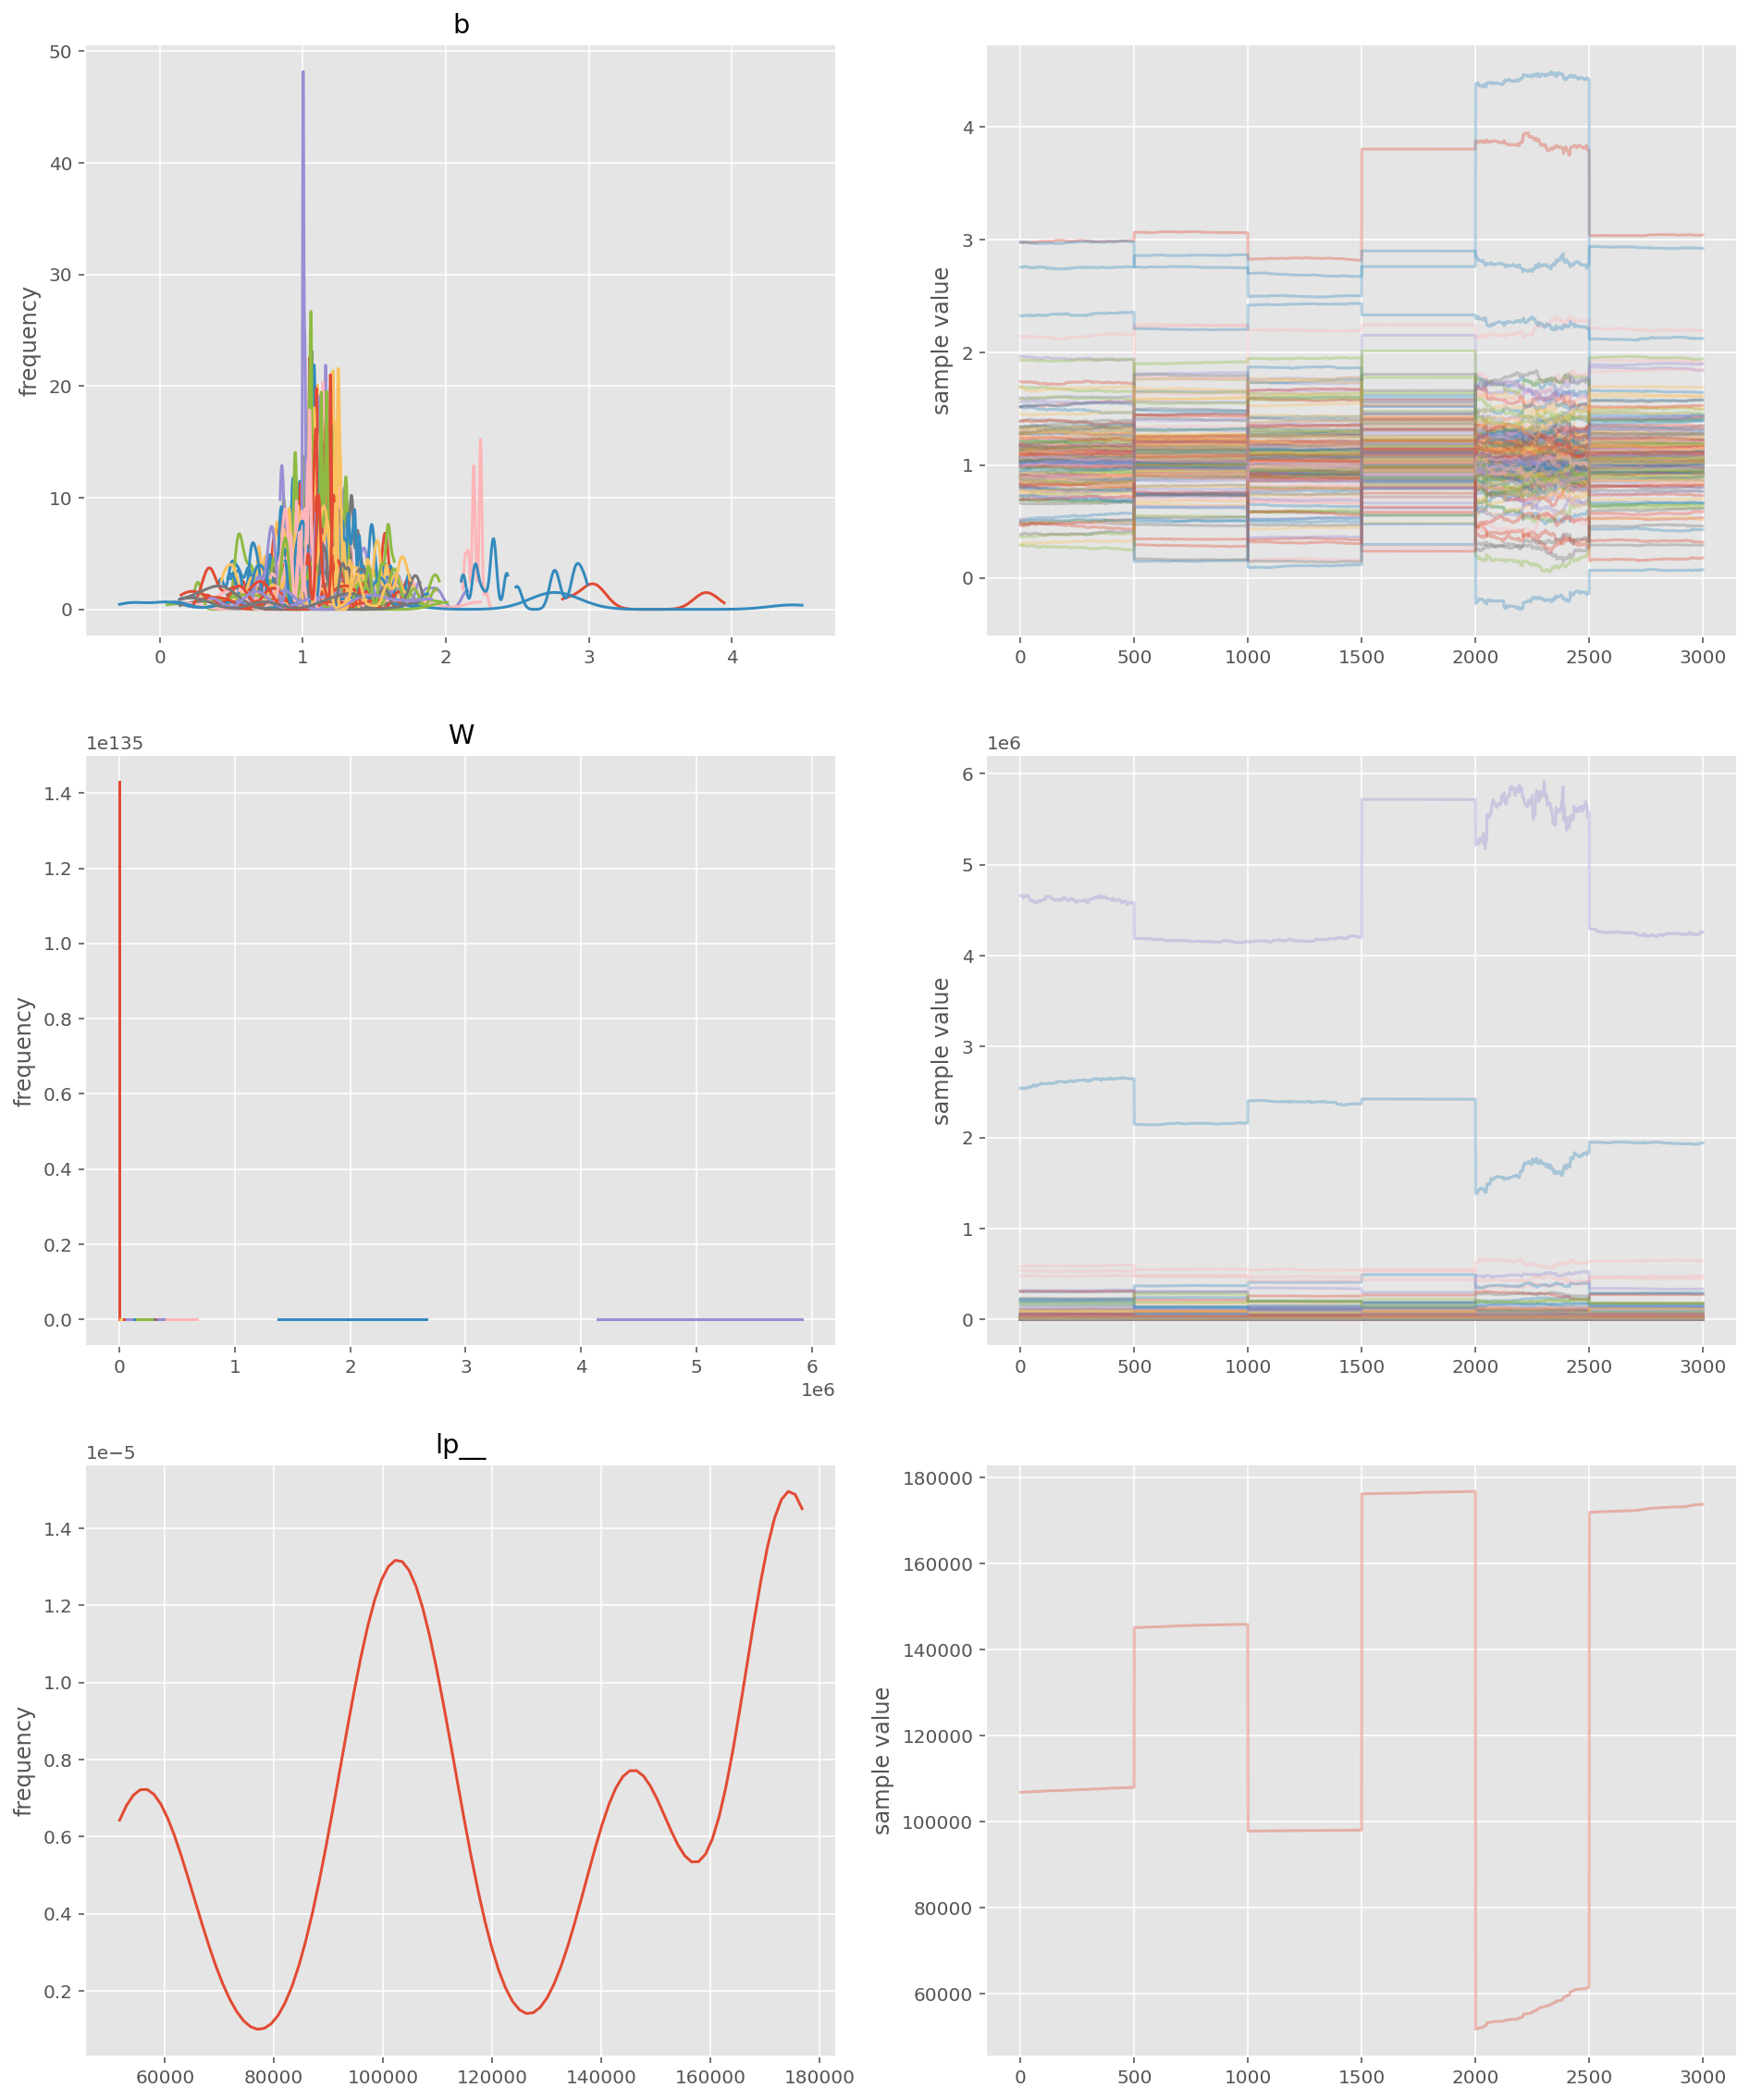

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.996
MAE: 191146.55770
RMSE: 1418506.43482
R2: 0.684


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

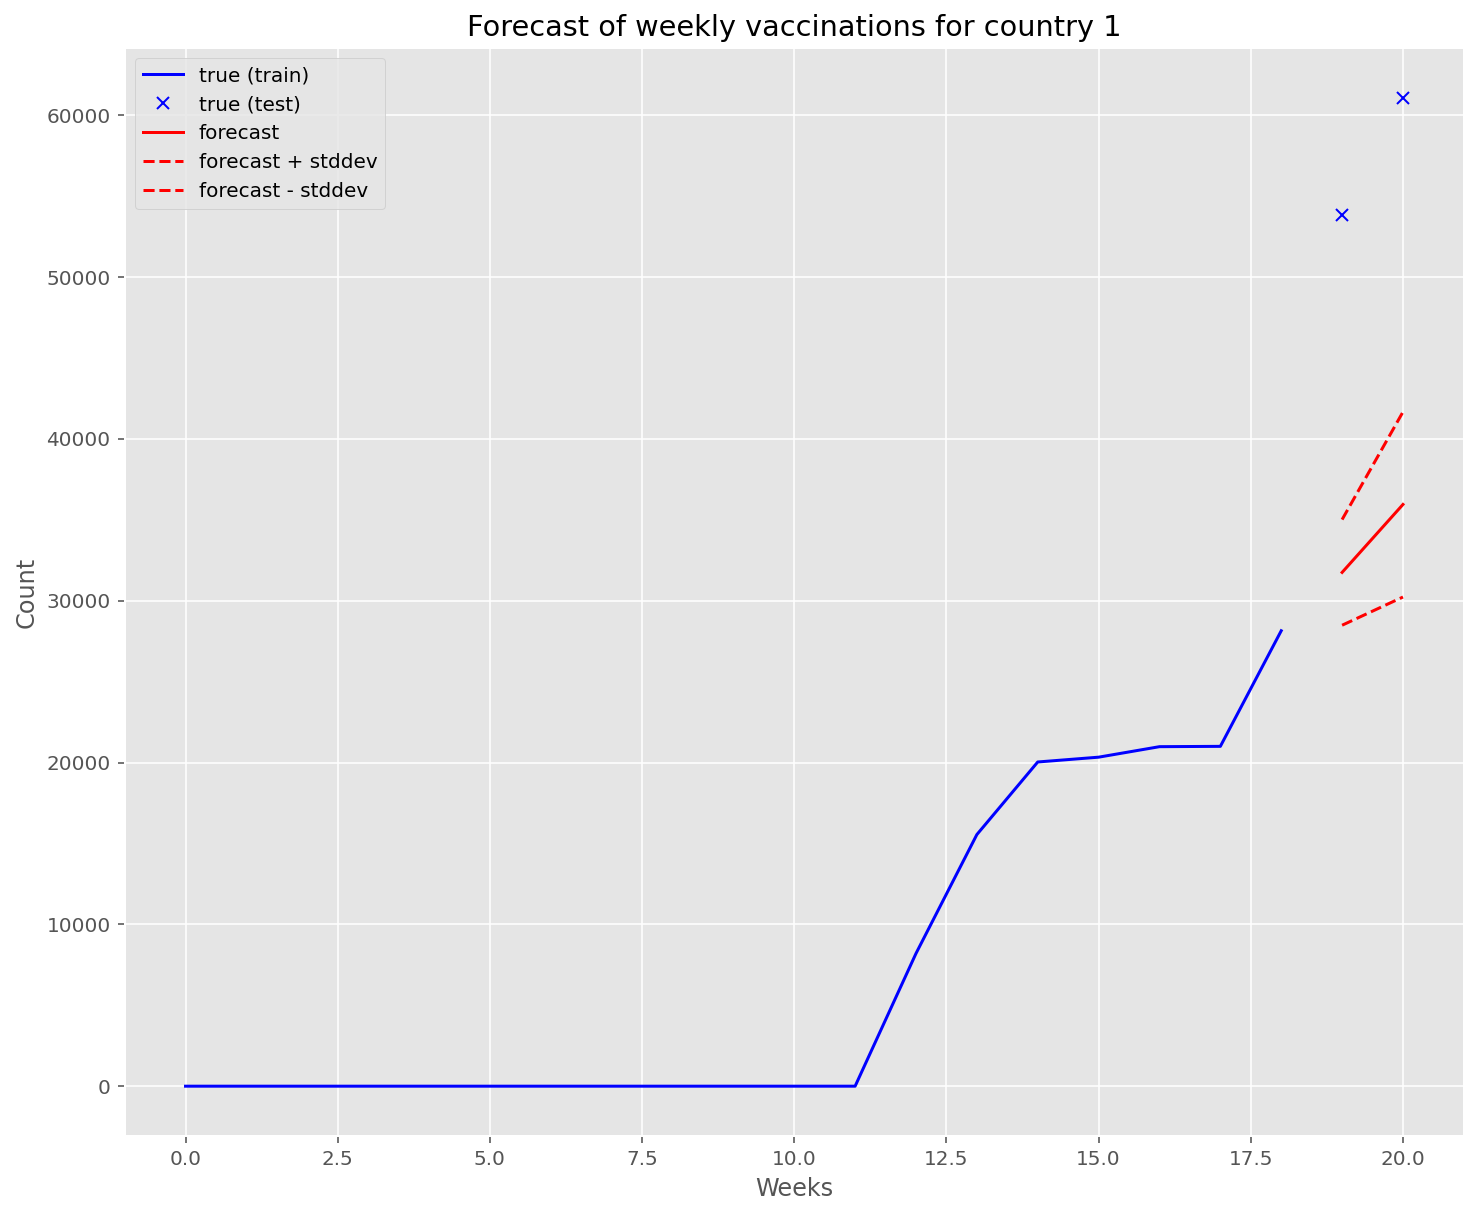

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for country 1")
plt.xlabel("Weeks")
plt.ylabel("Count")

As it can be seen from the results, *R2* is equal to 0.684, meaning the forecast accuracy is not ideal. Moreover, the graphs of the samples for the priors and the likelihood do not provide good results, as they do not explore the space adequately.

Regarding the chains, *Rhat* in some cases assumes very high values distant from 1, suggesting that the the chains are not mixing and thus not converging. 
It can also be noticed that the model returns a lot of samples displayed as *NaNs*, probably because the values are extremely low. In fact, in some cases the mean of the standard deviation *W* reaches an order of $e^{-138}$.

A reason for this poor performance is that it is assumed that the inferred parameters are the same for every country - as the priors are the same - when instead the trend of the weekly vaccinations varies a lot according to the geographical location. A solution to track these differences is aggregating similar countries according to specific features, which will be done in the following section.

## 2.2 Adding priors for the clusters

The following model will receive in input 5 clusters, as defined previously in the *Cluster PCA* section. Therefore, the values of the coefficient ***b*** and the standard deviation *W* will be inferred for each cluster, with a total of 10 parameters, instead of 187*2 = 338 (as in the previous model).

The countries are grouped together according to the following 6 criteria (taken from the *ExtraData* dataset):

1.   Population in thousands (2017)
2.   Population density (per km2, 2017)
3.   Sex ratio (m per 100 f, 2017)
4.   CO2 emission estimates (million tons/tons per capita)
5.   GDP per capita (current US$)
6.   Health: Total expenditure (% of GDP)

This will allow to improve the model's forecast since only the countries belonging to the same cluster will share the same priors.

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    int K; // num. of countries
    matrix[T,K] y;                 // time-series data
    int cluster[K];
}

parameters {
    vector[C] b;            // state transition coefficients
    vector<lower=0>[C] W;            // state transition coefficients 
}

model {
  for(c in 1:C) {
   	W[c] ~ cauchy(0,3);  
    b[c] ~ normal(0,3);           // prior on the auto-regressive coefficients
  }
    
    for(k in 1:K) {
      for(t in 2:T) {
        y[t,k] ~ normal(b[cluster[k]]' * y[t-1,k], W[cluster[k]]); // likelihood
      }
    }
}

generated quantities {
    matrix[T_forecast,K] y_hat;          // vector to store predictions

    for(k in 1:K) {
        y_hat[1,k] <- normal_rng(b[cluster[k]]' * y[T,k], W[cluster[k]]);  // predictions
  }

  for(k in 1:K) {
      for (t in 2:T_forecast) {
        y_hat[t,k] <- normal_rng(b[cluster[k]]' * y_hat[t-1,k], W[cluster[k]]);  // predictions
      }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
C = 5
data = {'T': T, 'T_forecast': T_forecast, 'C': C, 'K': D ,'y': y_train, 'cluster':cluster}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f47fa72d715c0cb809d0b5cbd182195 NOW.


CPU times: user 1.87 s, sys: 95.4 ms, total: 1.97 s
Wall time: 1min 11s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_5f47fa72d715c0cb809d0b5cbd182195.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]           1.01  1.0e-4 7.8e-3   0.99    1.0   1.01   1.01   1.02   6006    1.0
b[2]            1.0  5.9e-4   0.04   0.93   0.98    1.0   1.03   1.08   4460    1.0
b[3]           1.03  1.2e-4 9.4e-3   1.01   1.02   1.03   1.04   1.05   5813    1.0
b[4]           1.17  3.8e-4   0.03   1.12   1.15   1.17   1.19   1.22   4723    1.0
b[5]           1.17  7.7e-4   0.06   1.05   1.13   1.17    1.2   1.28   5459    1.0
W[1]          7.3e4   13.35 1027.7  7.1e4  7.2e4  7.3e4  7.4e4  7.5e4   5924    1.0
W[2]         246.47    0.46  29.65 197.44  225.1 243.97 264.34 311.53   4159    1.0
W[3]          1.2e5   47.15 3370.6  1.1e5  1.1e5  1.2e5  1.2e5  1.2e5   5110    1.0
W[4]          2.4e5  203.24  1.4e4  2.1e5  2.3e5  2.4e5  

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 187)
y_test.shape: (2, 187)
y_hat_mean.shape: (2, 187)


We can now plot the samples...

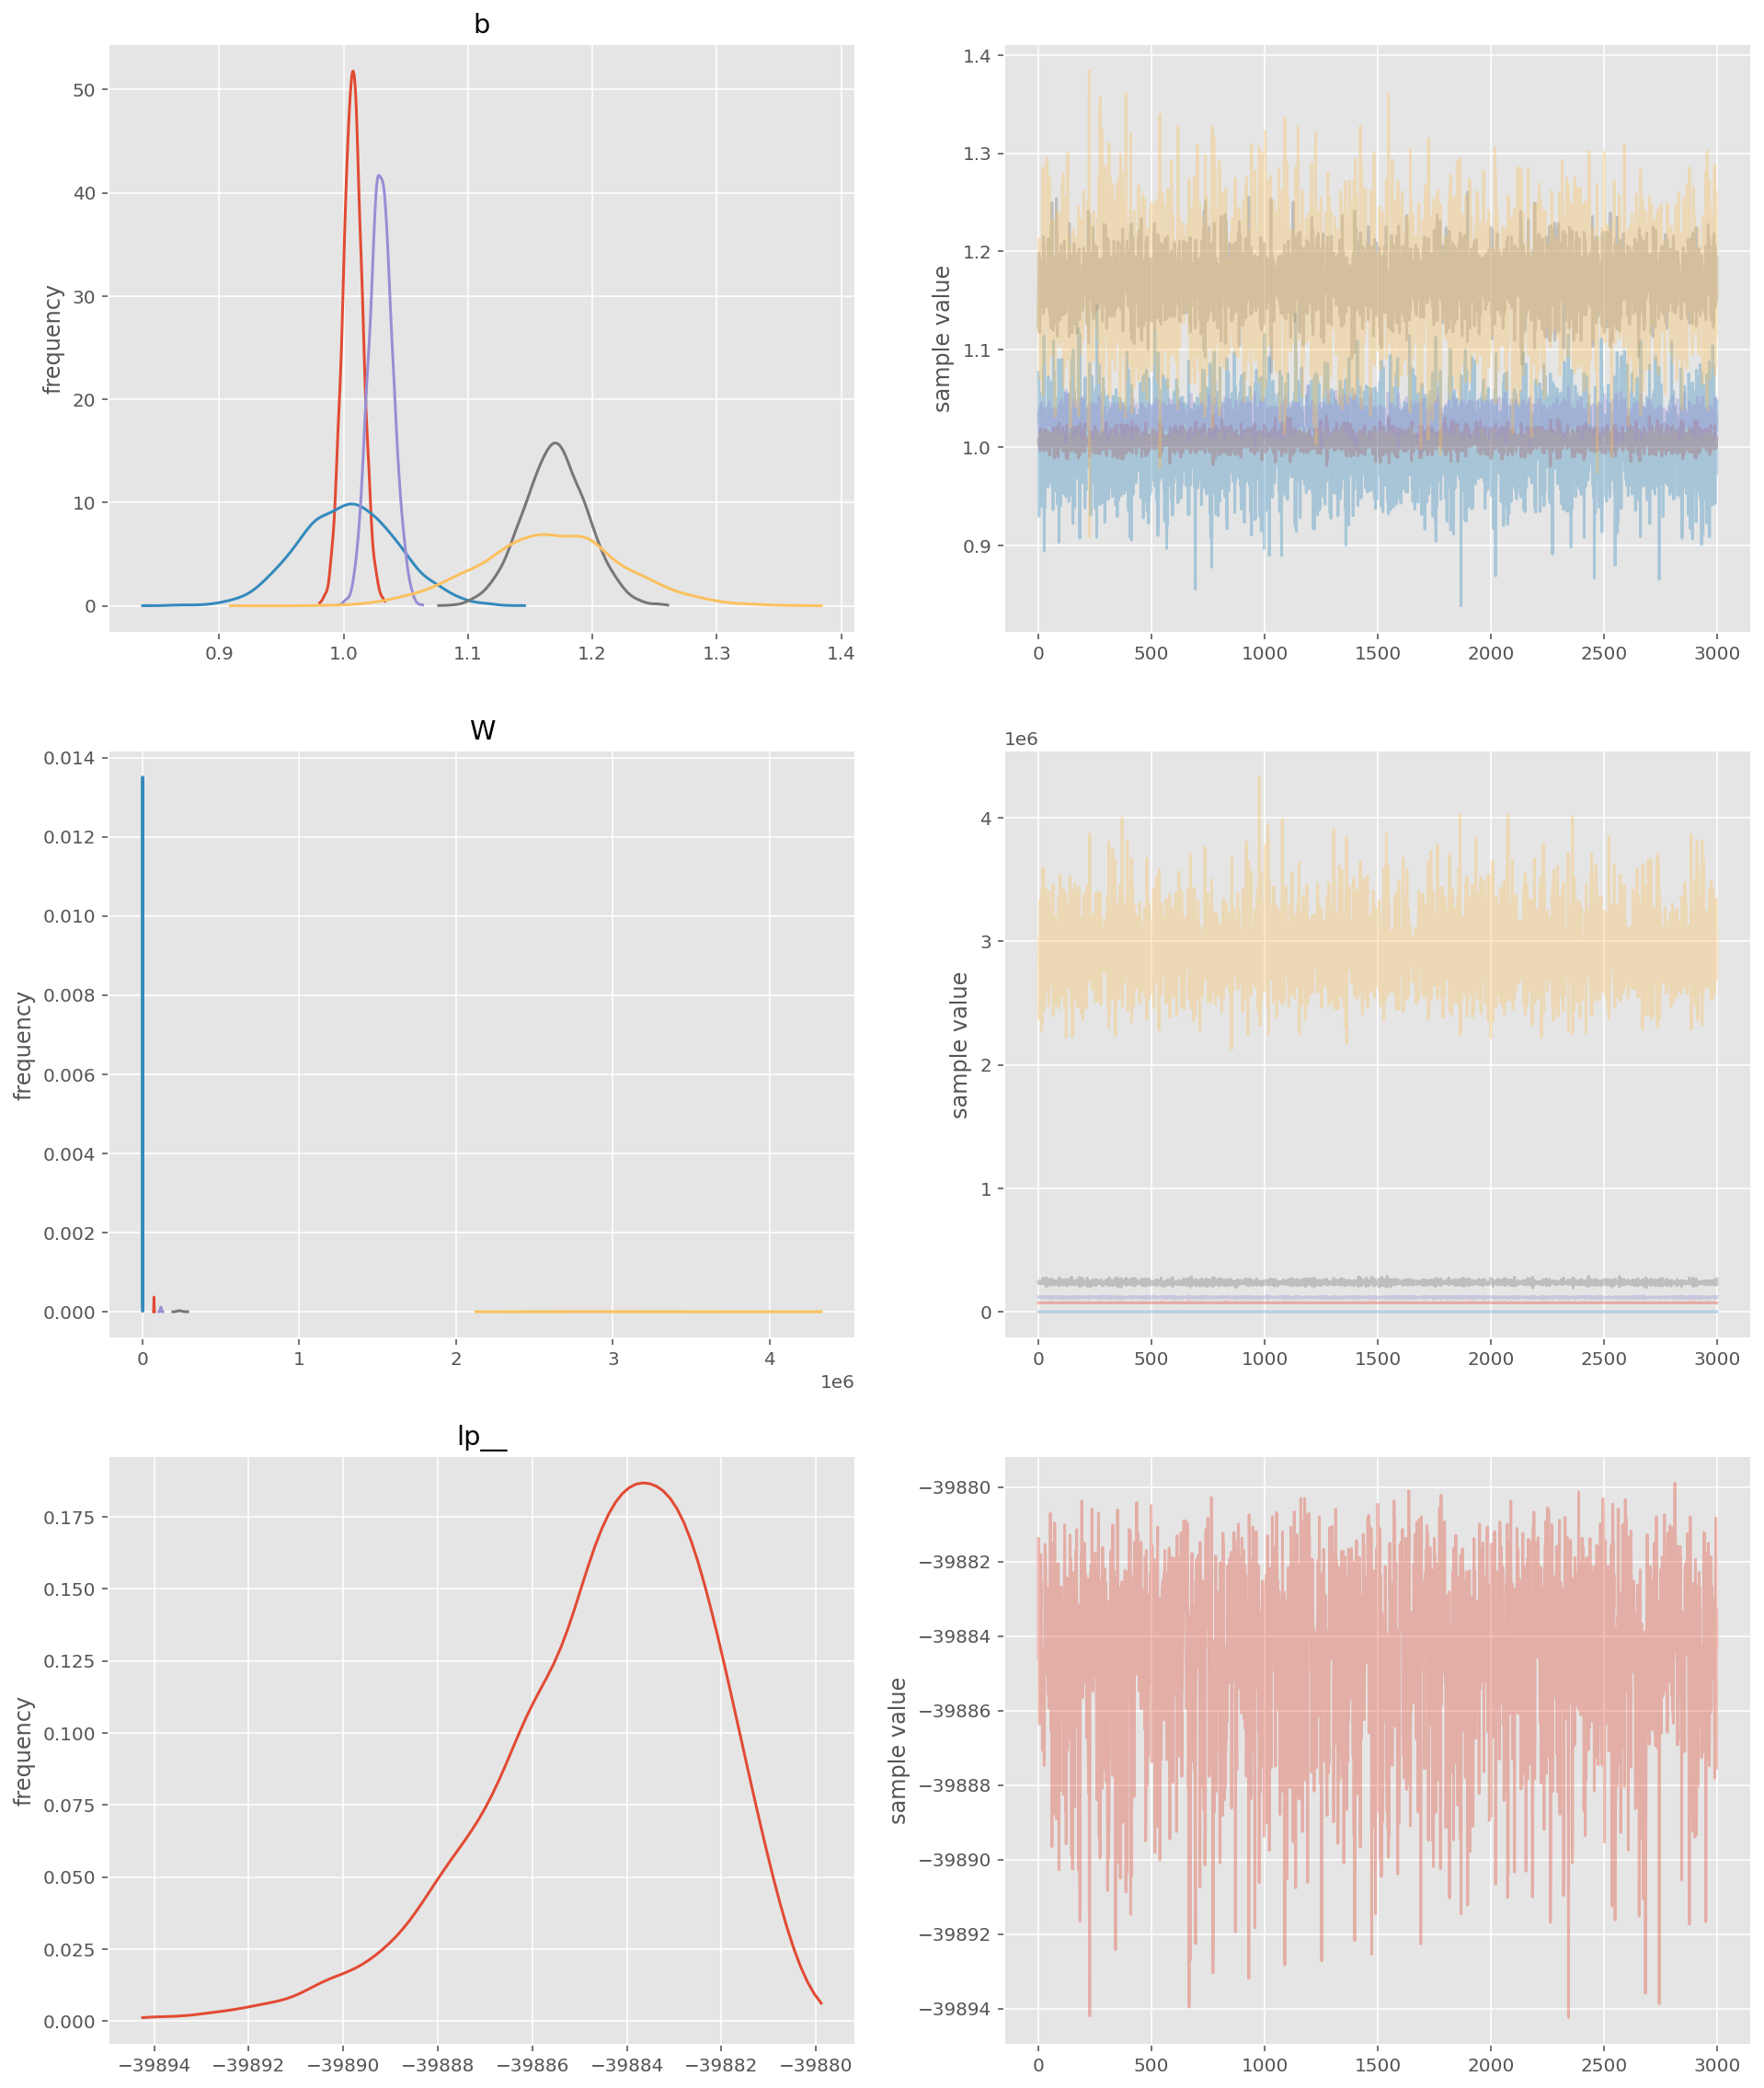

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 186663.92139
RMSE: 1226614.03313
R2: 0.763


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

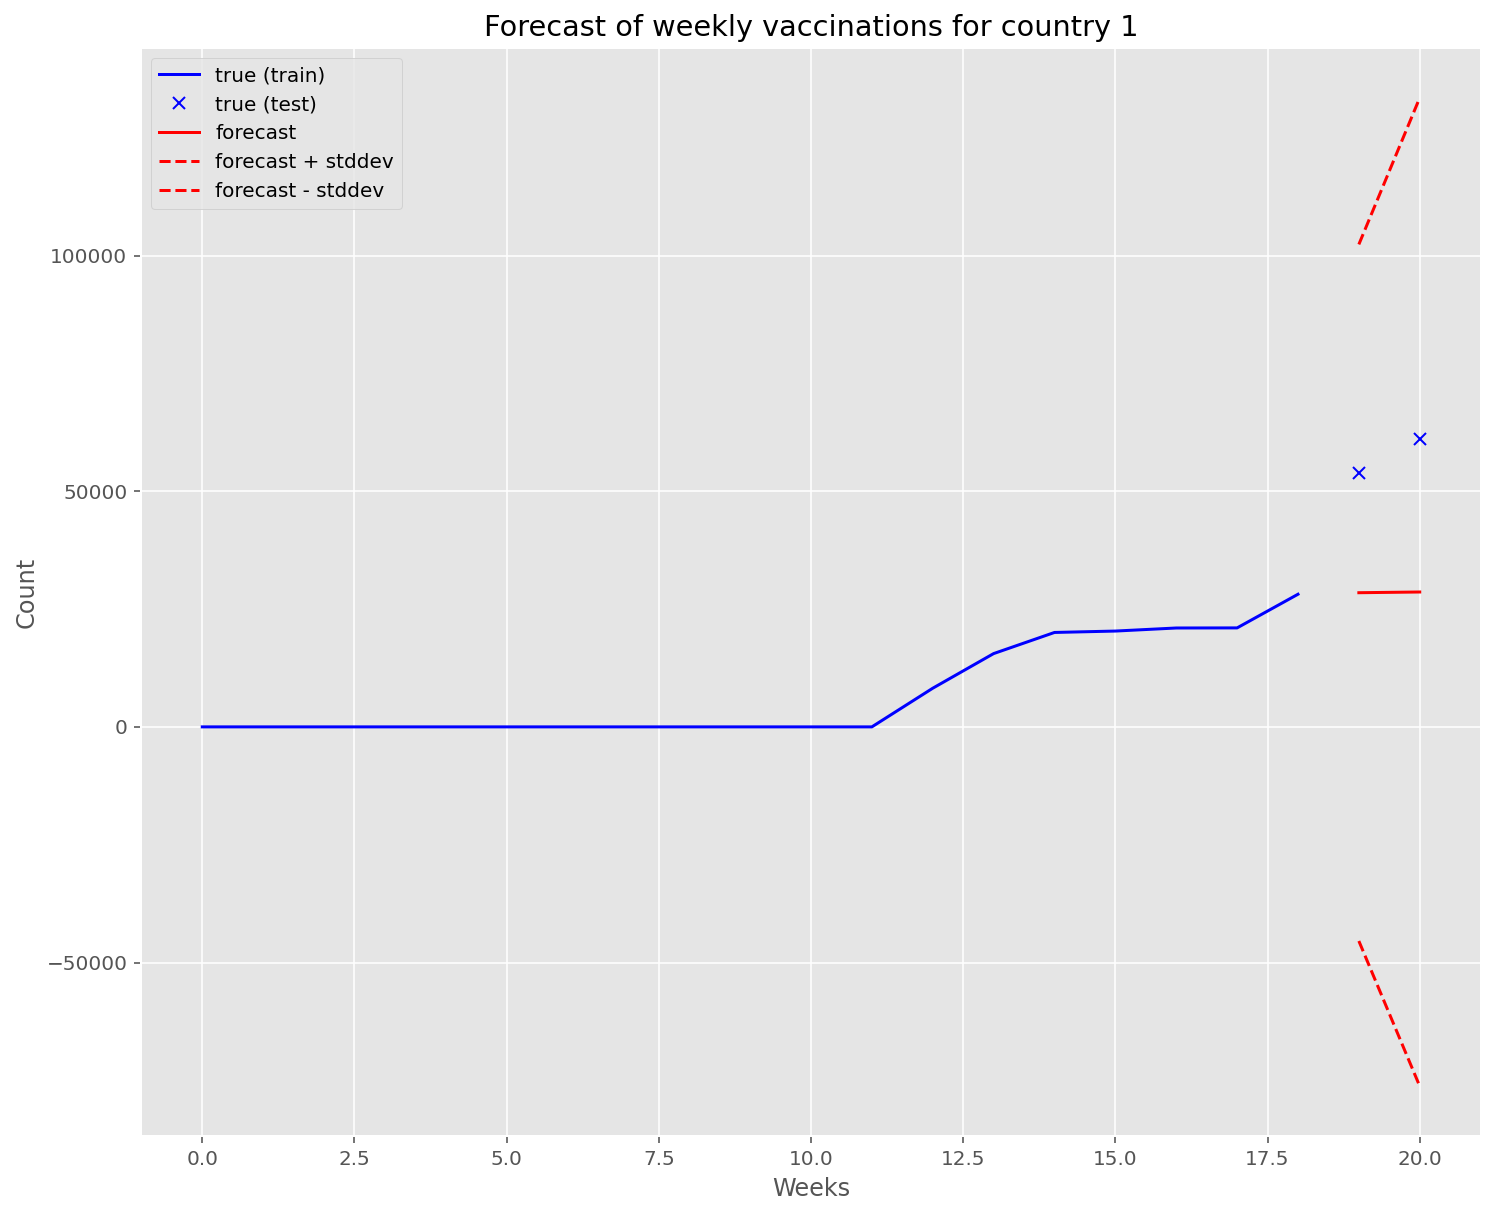

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for country 1")
plt.xlabel("Weeks")
plt.ylabel("Count")

In this case, the chains are performing better compared to the previous model, since all *Rhats* are equal to 1 and the *R2* is increased to 0.763. This confirms the correctness of the initial hypothesis: setting priors which depend only on 5 clusters helps the model manage better the variability in the data and therefore generate more accurate forecast.

With that being said, the forecast accuracy can still be improved. This is probably due to the type of data that we are managing (CovidData dataset), which is characterized by steep slopes and fluctuations that make it difficult for the model to forecast accurately, feeding in input only the weekly vaccinations for the previous week.

Therefore, in the next section we will try to:

1.   Improve the data
2.   Forecast only for aggregated data
2.   Add other temporal features to the model

In this way, we can verify the performance of the model when we give in input data which is easier to manage.

## 2.3 AR(1) model: cluster forecast and data transformation

In this section only clusters 0 and 2 will be taken into account. In fact, the other clusters are either too variable (e.g.: cluster 4) or do not change at all (e.g.: cluster 1), as shown in the last graph of the section *Clusters: Reshaping of temporal data*.

### 2.3.1 Data standardization

The first step is to transform the data so that it is easier to predict. In particular, we tested out the following methods and ran corresponding STAN models:


1.   Standardizing the no. of weekly vaccinations
2.   Applying a log function to the the no. of weekly vaccinations
3.   Using differences in the the no. of weekly vaccinations in between consecutive time steps

In this notebook only the first approach is included, as it represents the best one. As a matter of fact, if the log function did not capture the variability of the data on one hand, using the delta in between time steps led to excessive variability on the other hand.





The first step is to standardize the data, therefore we will create a temporary variable *mask* to store the values of the clusters.

In [ ]:
clust_ = np.unique(cluster)
mask = np.zeros(shape=(len(clust_),y.shape[1]))
print(mask.shape)
for i,clust in enumerate(clust_):
  for j,val in enumerate(cluster):
      if clust == val:
        mask[i,j] = 1

(5, 187)


In [ ]:
y_0= y[:,mask[0]==1]
y_1= y[:,mask[1]==1]
y_2= y[:,mask[2]==1]
y_3= y[:,mask[3]==1]
y_4= y[:,mask[4]==1]

The following code shows the shape of each cluster, where the rows represent the weeks and the columns represent the number of countries of each cluster.

In [ ]:
print("Shape of cluster 0:", y_0.shape)
print("Shape of cluster 1:", y_1.shape)
print("Shape of cluster 2:", y_2.shape)
print("Shape of cluster 3:", y_3.shape)
print("Shape of cluster 4:", y_4.shape)

Shape of cluster 0: (24, 138)
Shape of cluster 1: (24, 2)
Shape of cluster 2: (24, 36)
Shape of cluster 3: (24, 8)
Shape of cluster 4: (24, 3)


For each cluster, we then take the mean and we define a new array *y_clust*, which entails the means of clusters 0 and 2 until week 20.

In [ ]:
y_0_mean = y_0.mean(axis=1)
y_1_mean = y_1.mean(axis=1)
y_2_mean = y_2.mean(axis=1)
y_3_mean = y_3.mean(axis=1)
y_4_mean = y_4.mean(axis=1)

In [ ]:
y_clust = np.stack((y_0_mean[:21],y_2_mean[:21]), axis=1)
print("Shape of y_clust:", y_clust.shape)

Shape of y_clust: (21, 2)


We now standardize the data in *y_clust*, by applying the function *standardize_model*:

In [ ]:
y_clust_std = standardize_model(y_clust)
y_clust_std.shape

(21, 2)

We can now visualize the trend of *y_clust*:

Text(0, 0.5, 'Count')

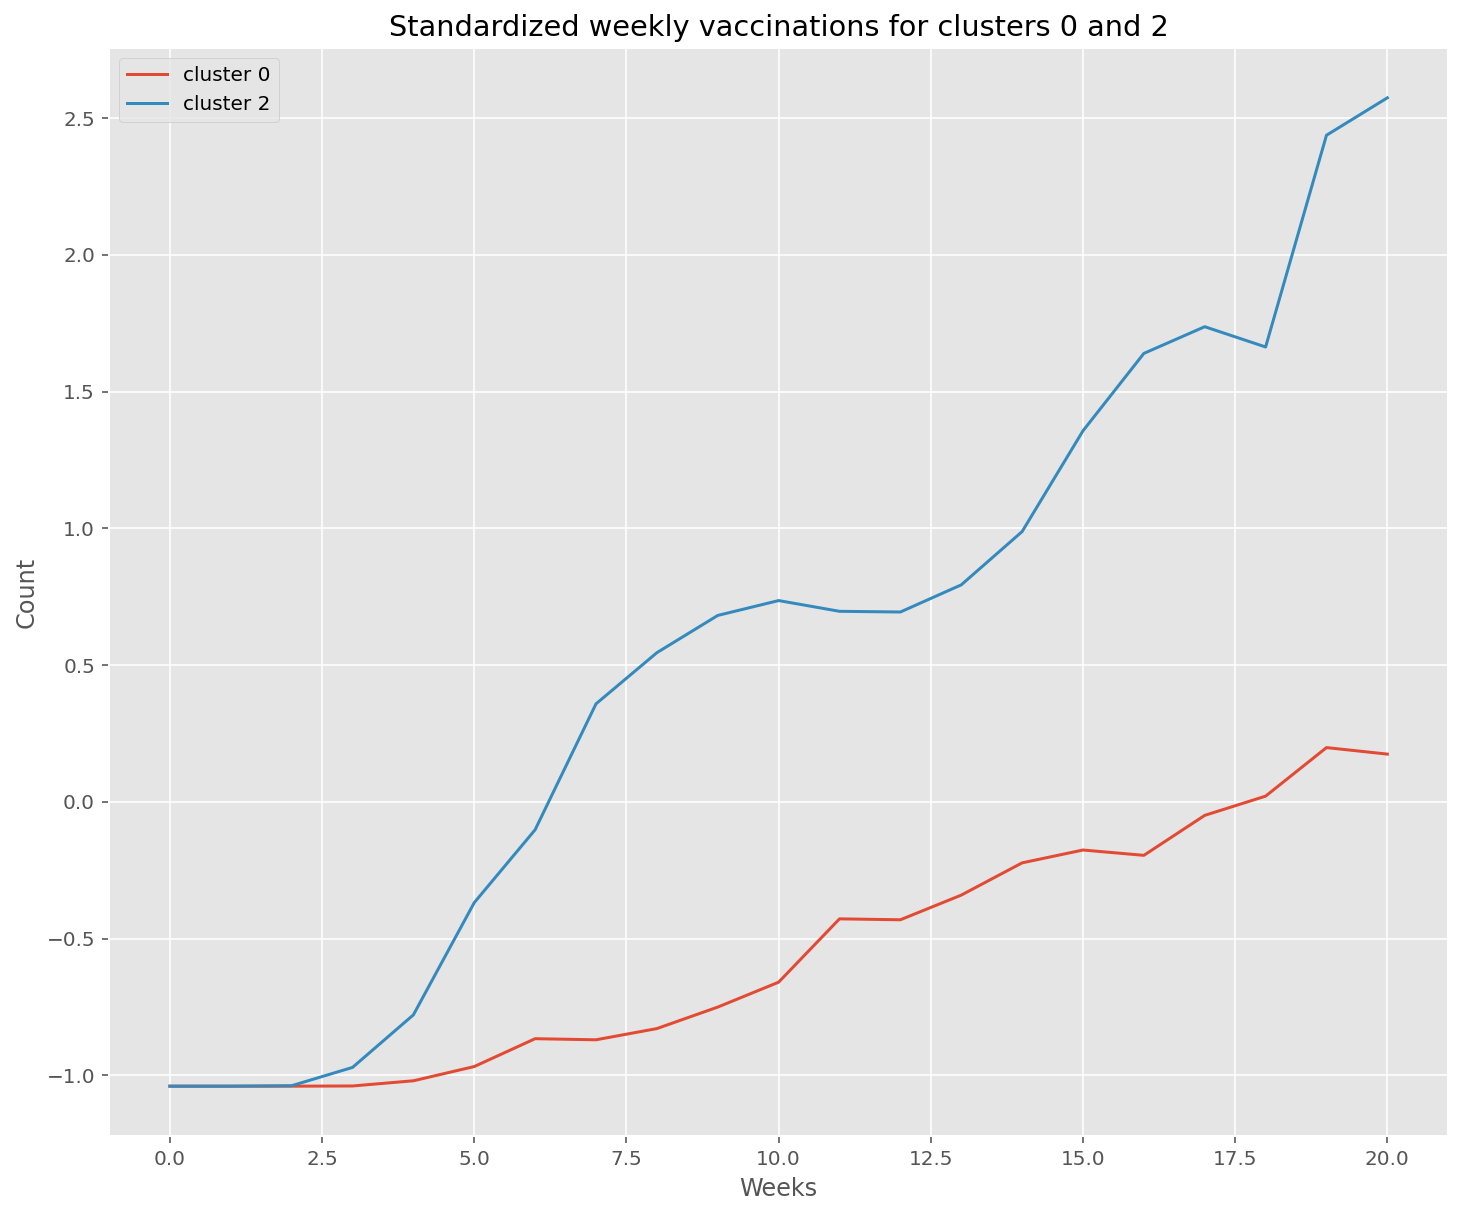

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(y_clust_std.shape[1]):
  plt.plot(range(y_clust_std.shape[0]), y_clust_std[:,i])
plt.legend(["cluster 0","cluster 2"])
plt.title("Standardized weekly vaccinations for clusters 0 and 2")
plt.xlabel("Weeks")
plt.ylabel("Count")

We re-define the values of *N*, *D* and prepare the data for the model.

In [ ]:
N, D = y_clust_std.shape
#y = y.astype(int)
print("N=%d, D=%d" % (N,D))

N=21, D=2


In [ ]:
ix_train = range(19) # 15 weeks for training
ix_test = range(19, 21) # 2 weeks for testing
N_train = len(ix_train)
N_test = len(ix_test)
N=N_train+N_test
print('N:', N)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y_clust_std[ix_train, :]
y_test = y_clust_std[ix_test, :]

N: 21
N_train: 19
N_test: 2


#### 2.3.1.1 Model

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    matrix[T,C] y;                 // time-series data
}

parameters {
    vector[C] b;            // state transition coefficients
    vector<lower=0>[C] W;         // state transition coefficients 
}

model {
  for(c in 1:C) {
    b[c] ~ normal(1,0.5);             // prior on the auto-regressive coefficients
   	W[c] ~ cauchy(1,0.5);             // prior on the auto-regressive coefficients
  }
    
  for(c in 1:C) {
    for(t in 2:T) {
      y[t,c] ~ normal(b[c]' * y[t-1,c], W[c]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,C] y_hat;          // vector to store predictions

  for(c in 1:C) {
    y_hat[1,c] <- normal_rng(b[c]' * y[T,c], W[c]);  // predictions
  }

  for(c in 1:C) {
    for (t in 2:T_forecast) {
      y_hat[t,c] <- normal_rng(b[c]' * y_hat[t-1,c], W[c]);  // predictions
    }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
data = {'T': T, 'T_forecast': T_forecast, 'C': D,'y': y_train}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2645bede5f9acd8e4c3fd0a21744814a NOW.


CPU times: user 1.66 s, sys: 114 ms, total: 1.78 s
Wall time: 1min 9s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_2645bede5f9acd8e4c3fd0a21744814a.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         0.94  5.0e-4   0.03   0.89   0.92   0.94   0.96    1.0   2754    1.0
b[2]         1.02  1.1e-3   0.06   0.91   0.98   1.02   1.06   1.14   2840    1.0
W[1]         0.08  3.1e-4   0.02   0.06   0.07   0.08   0.09   0.12   2617    1.0
W[2]         0.24  9.0e-4   0.05   0.17   0.21   0.23   0.26   0.35   2625    1.0
y_hat[1,1]   0.02  1.5e-3   0.08  -0.15  -0.03   0.02   0.07   0.18   3251    1.0
y_hat[2,1]   0.02  2.1e-3   0.11  -0.21  -0.06   0.02   0.09   0.25   3082    1.0
y_hat[1,2]    1.7  4.8e-3   0.26   1.18   1.54    1.7   1.87   2.23   3043    1.0
y_hat[2,2]   1.75  7.3e-3    0.4   0.96   1.48   1.74    2.0    2.6   3037    1.0
lp__        47.81    0.05   1.48  44.17  47.06  48.14  48.93  49.65   1049 

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 2)
y_test.shape: (2, 2)
y_hat_mean.shape: (2, 2)


We can now plot the samples...

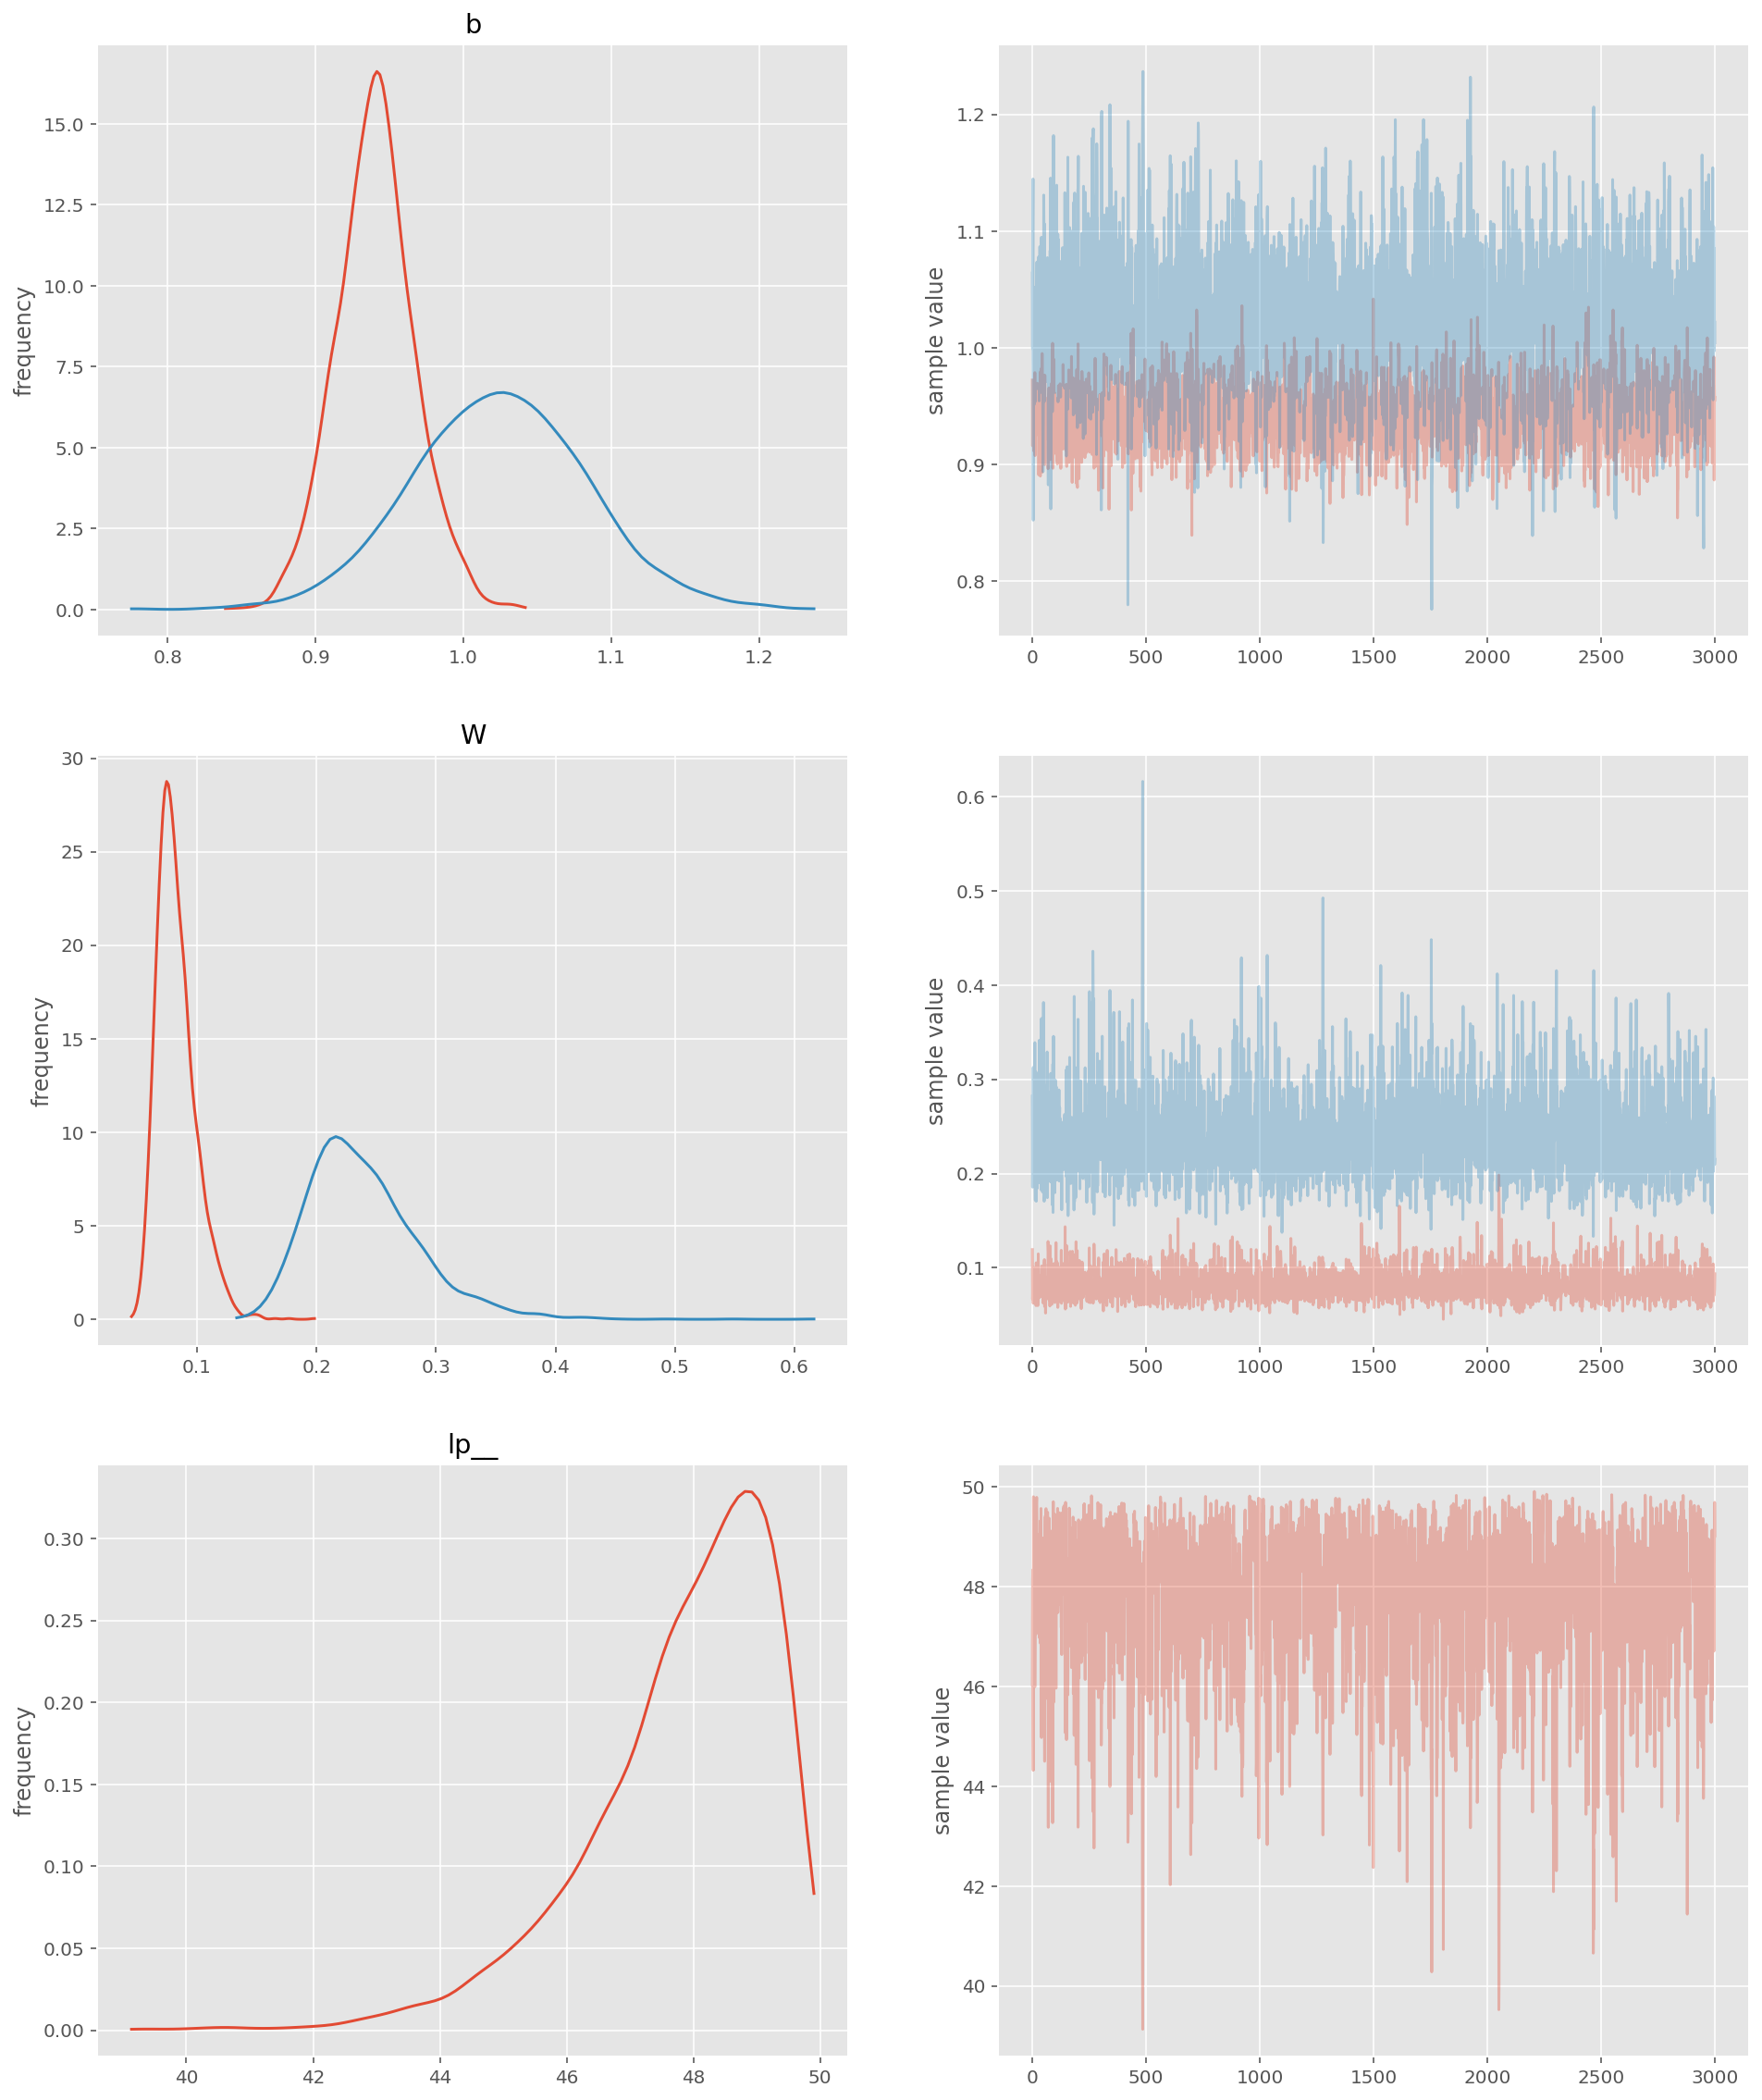

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 0.47330
RMSE: 0.56462
R2: 0.763


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

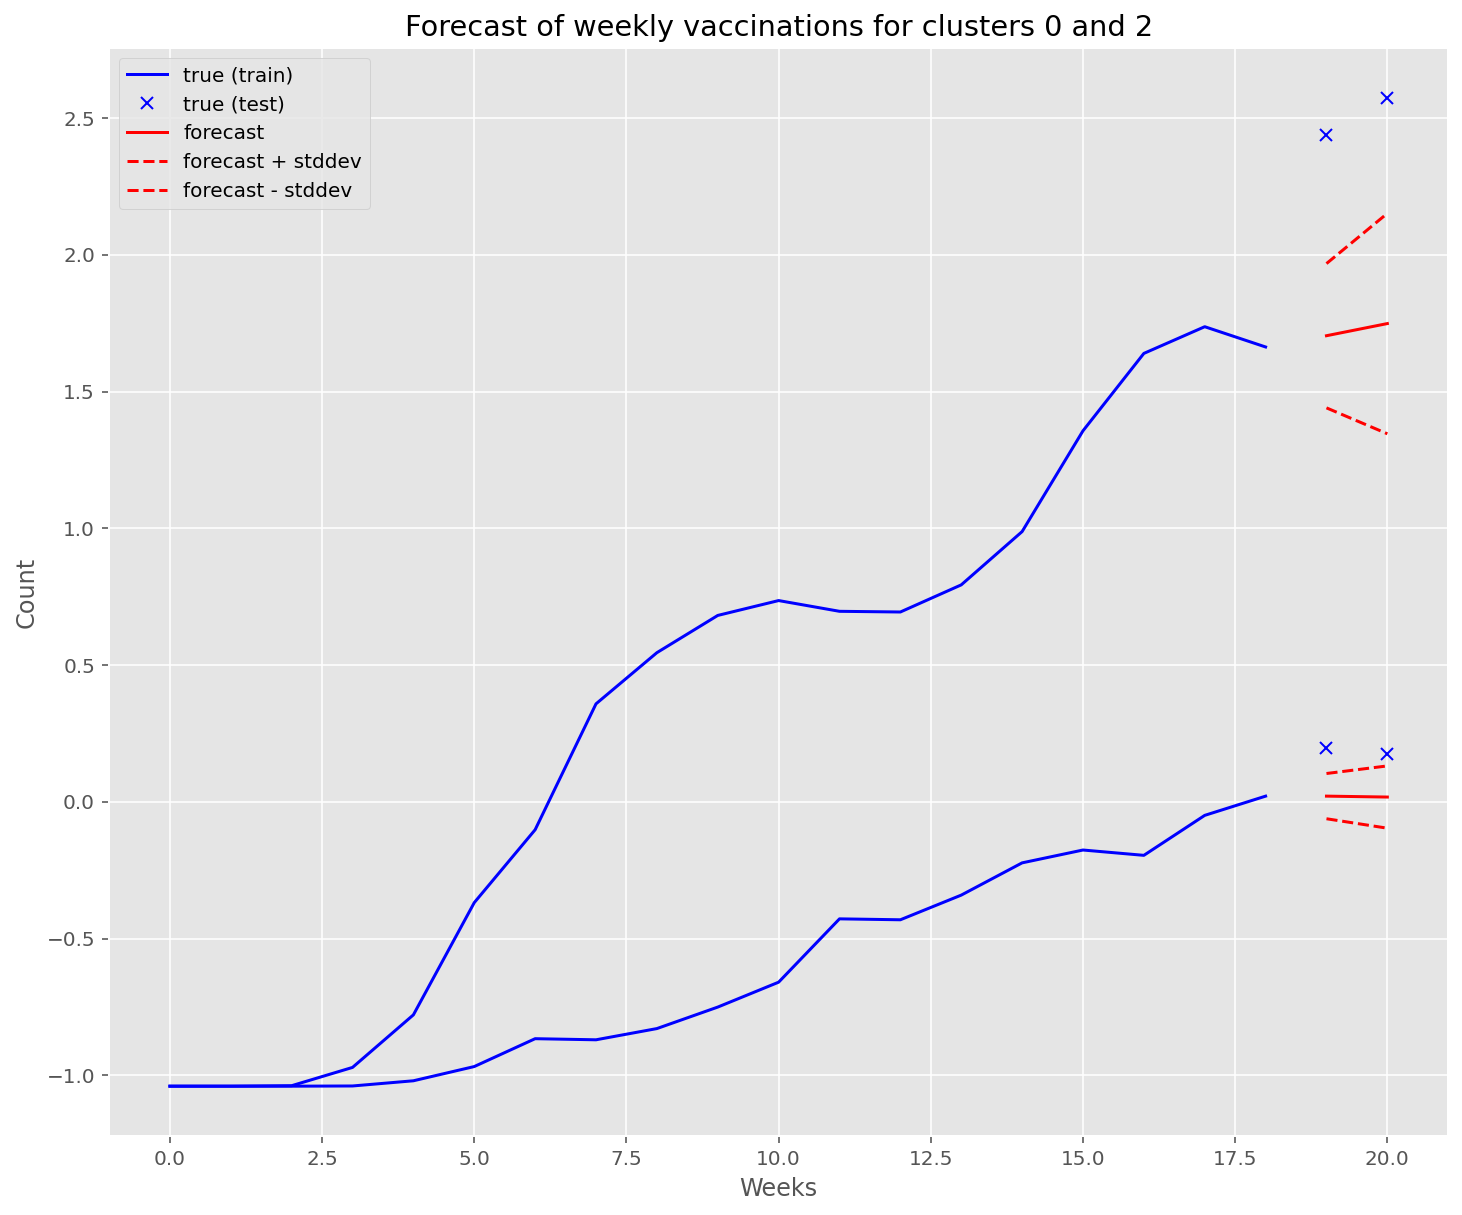

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(0,2):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for clusters 0 and 2")
plt.xlabel("Weeks")
plt.ylabel("Count")

The model's forecast accuracy remained stable compared to the previous model, suggesting that giving in input standardized data and forecasting only for two clusters does not affect the model, at least for the considered ranges of *y_train* and *y_test*.

In fact, running this model with another range for training and testing (when less data was available), *R2* had an increase of 0.37 compared to the previous model. This suggests that the results highly depend on the data given in input, and that the data standardization and cluster forecast are actually beneficial.

#### 2.3.1.2 Adding hyper-priors

We can now add hyper-priors to the model, to see their influence on the results. The means and standard deviations of ***b*** and *W* are sampled from normal distributions. The parameters of the hyper-priors are set according to observed values when running the model.

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    matrix[T,C] y;                 // time-series data
}

parameters {
    real W_1;
    real<lower=0> W_2;
    real b_1;
    real<lower=0> b_2;
    vector[C] b;            // state transition coefficients
    vector<lower=0>[C] W;         // state transition coefficients 
}

model {
  W_1 ~ normal(390,19);
  W_2 ~ normal(21,2);
  b_1 ~ normal(99,8);
  b_2 ~ normal(21,3);
  
  for(c in 1:C) {
    for(t in 2:T) {
      y[t,c] ~ normal(b[c]' * y[t-1,c], W[c]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,C] y_hat;          // vector to store predictions

  for(c in 1:C) {
    y_hat[1,c] <- normal_rng(b[c]' * y[T,c], W[c]);  // predictions
  }

  for(c in 1:C) {
    for (t in 2:T_forecast) {
      y_hat[t,c] <- normal_rng(b[c]' * y_hat[t-1,c], W[c]);  // predictions
    }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
data = {'T': T, 'T_forecast': T_forecast, 'C': D,'y': y_train}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ffec6ced8c14ba93cfd36481e4517a8 NOW.


CPU times: user 1.72 s, sys: 103 ms, total: 1.83 s
Wall time: 1min 9s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_7ffec6ced8c14ba93cfd36481e4517a8.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
W_1        390.12    0.24  18.66 353.31 377.61 389.75 402.38 427.72   6010    1.0
W_2         20.99    0.03   2.06   17.0  19.61  20.99  22.34   25.2   4745    1.0
b_1         98.99     0.1    7.6  84.09  93.94  98.99 104.13 113.96   5549    1.0
b_2         20.99    0.05   2.94   15.2  19.07  20.98  22.96  26.98   4040    1.0
b[1]         0.94  3.6e-4   0.03   0.89   0.92   0.94   0.96   0.99   4704    1.0
b[2]         1.03  1.0e-3   0.06    0.9   0.99   1.03   1.07   1.15   3573    1.0
W[1]         0.08  2.4e-4   0.02   0.06   0.07   0.08   0.09   0.12   3883    1.0
W[2]         0.24  8.1e-4   0.05   0.17   0.21   0.23   0.26   0.34   3175    1.0
y_hat[1,1]   0.02  1.5e-3   0.09  -0.14  -0.03   0.02   0.08   0.19   3209 

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 2)
y_test.shape: (2, 2)
y_hat_mean.shape: (2, 2)


We can now plot the samples...

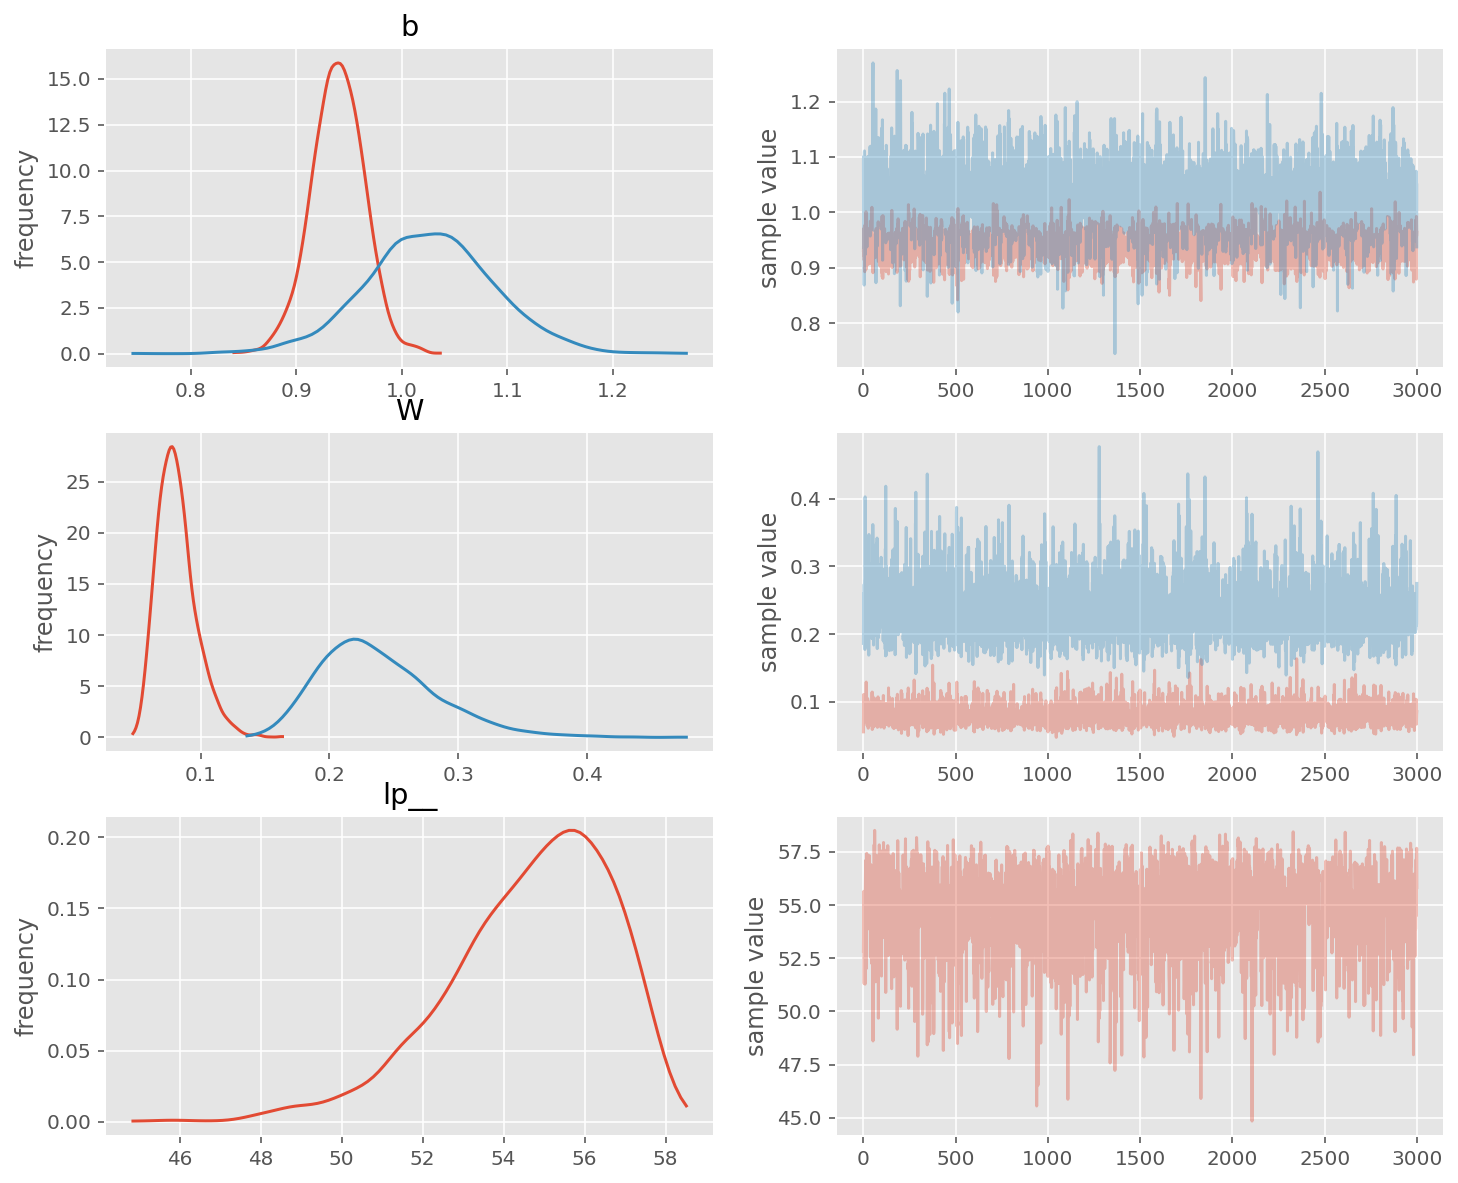

In [ ]:
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 0.47183
RMSE: 0.56348
R2: 0.764


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

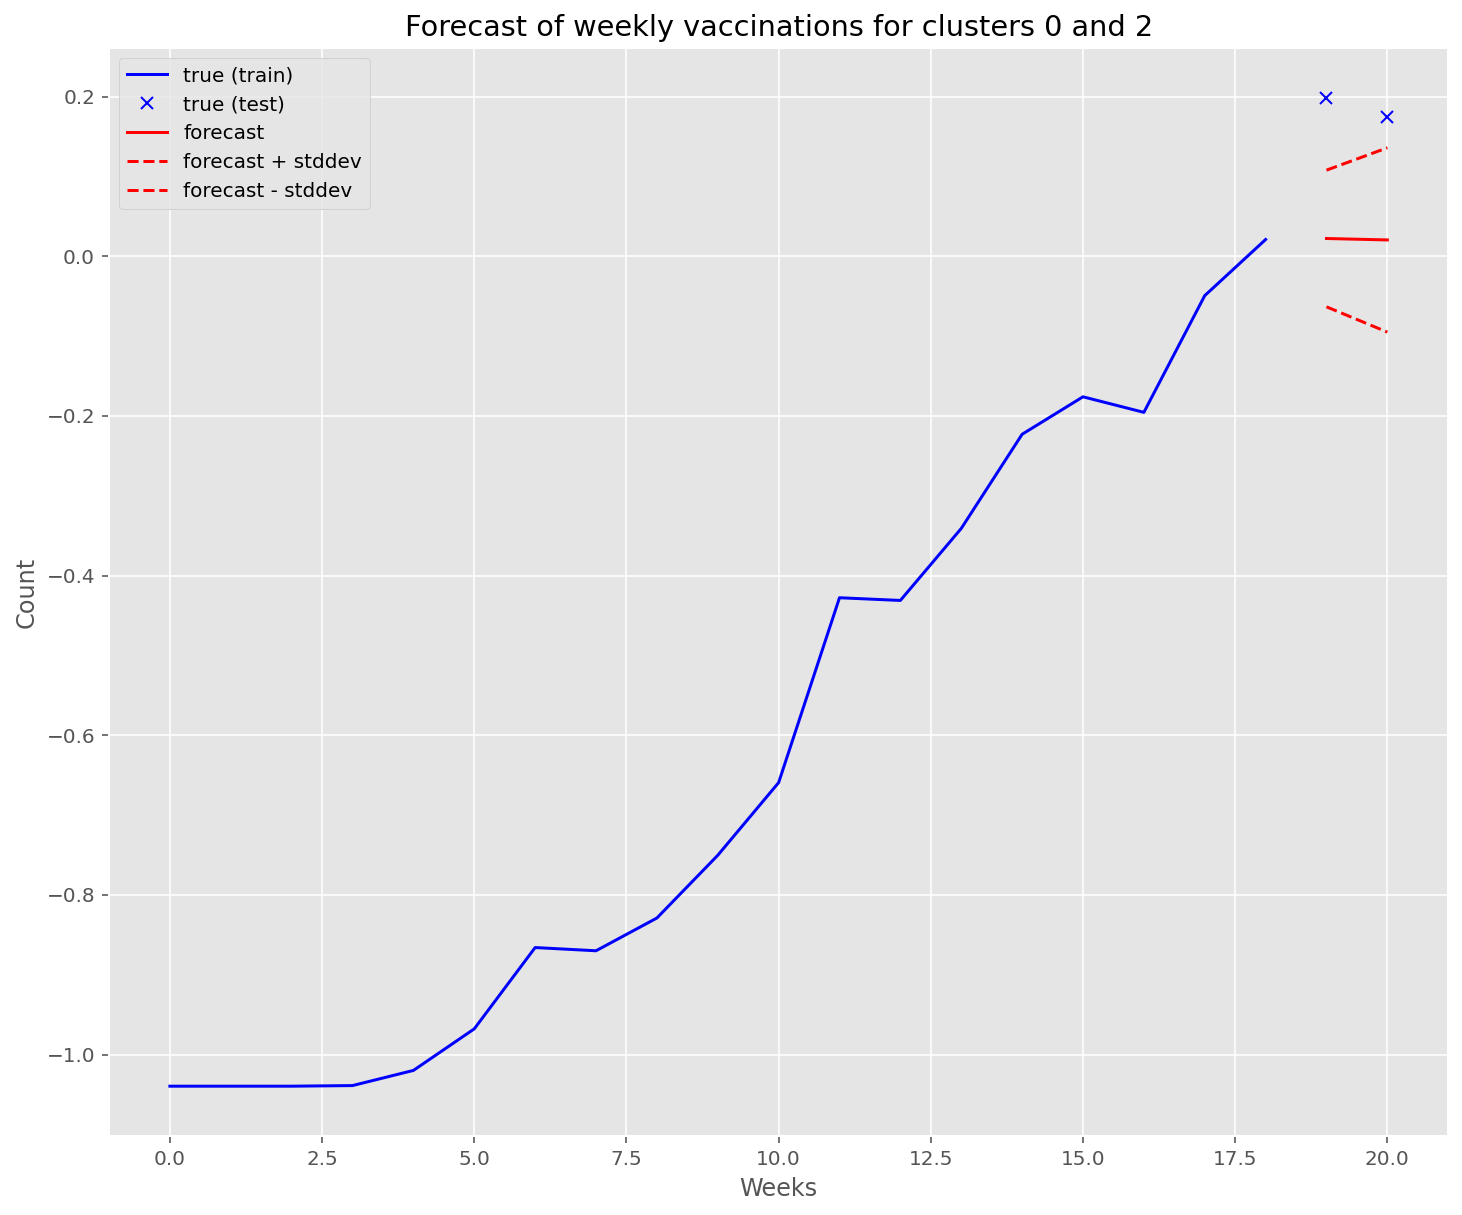

In [ ]:
plt.figure()
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for clusters 0 and 2")
plt.xlabel("Weeks")
plt.ylabel("Count")

The model with the hyper-priors provides 0.001 more of accuracy, which is a good result, but not impressive. The  models in the following sections have also been ran with hyper-priors, however the *R2* did not increase; thus, they were excluded from the next STAN models.

### 2.3.2 Adding temporal factor: number of people fully vaccinated

In the next step, we want to improve our predictions by adding the information of the people fully vaccinated in order to create a more complete model. This data is already contained in the CovidData dataset. The code below prepares the data.

#### 2.3.2.1 Data preparation

In [ ]:
# No. of fully people vaccinated for each weel and for each cluster
dfinal1.head()
print("dfinal 1 shape:", dfinal1.shape)

dfinal 1 shape: (24, 5)


In [ ]:
# Select the data for the 0 and 2 cluster
y_clust_fully_vaccinated = np.stack((dfinal1[0],dfinal1[2]), axis=1)
print("Shape of array of people fully vaccinated for clusters 0 and 2:", y_clust_fully_vaccinated.shape)

Shape of array of people fully vaccinated for clusters 0 and 2: (24, 2)


In [ ]:
# Standardizing
y_clust_fully_vaccinated = standardize_model(y_clust_fully_vaccinated)

In [ ]:
ix_train = range(19) # 19 weeks for training
ix_test = range(19, 21) # 2 weeks for testing
N_train = len(ix_train)
N_test = len(ix_test)
N=N_train+N_test
print('N:', N)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y_clust[ix_train, :]
y_test = y_clust[ix_test, :]
y_fullyvac = y_clust_fully_vaccinated[:21, :]

N: 21
N_train: 19
N_test: 2


In [ ]:
N, D = y_train.shape
print("N=%d, D=%d" % (N,D))

N=19, D=2


Text(0, 0.5, 'Count')

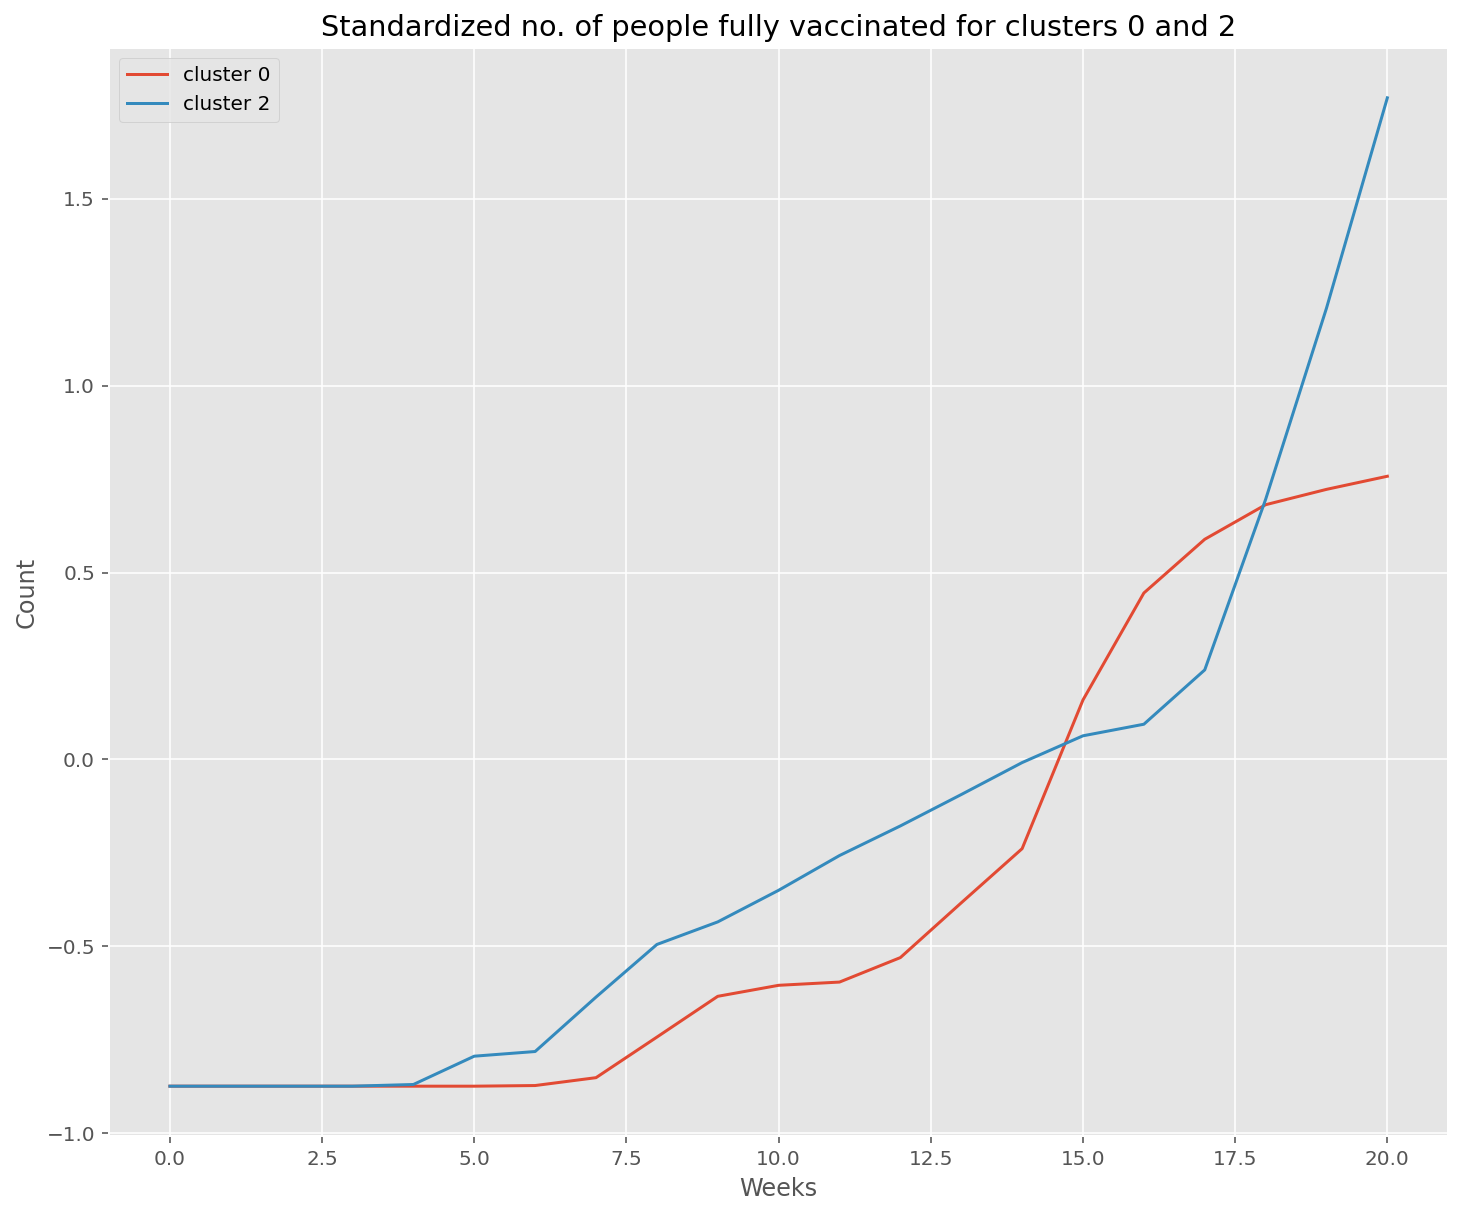

In [ ]:
plt.figure()
for i in range(y_fullyvac.shape[1]):
  plt.plot(range(y_fullyvac.shape[0]), y_fullyvac[:,i])
plt.legend(["cluster 0","cluster 2"])
plt.title("Standardized no. of people fully vaccinated for clusters 0 and 2")
plt.xlabel("Weeks")
plt.ylabel("Count")

As we can see in the plot above the standardized people fully vaccinated for each cluster follows an almost straight line that grows until week 18. This is due to the fact that the people fully vaccinated in each cluster is a cumulative function with an exponential form.

We have assumed that as our weekly vaccinations are always increasing, we have not yet reached the point where so many people are vaccinated that the frequency of vaccination is decreasing. With that being said, as the number of people fully vaccinated increases, so does the number of weekly vaccinations as the vaccination progresses.

Therefore, we have applied to our predictions a factor of *(1 + sigmoid(people_fully_vaccionated)*. The sigmoid is the optimal choice beause it returns values within a range of $[0,1]$. In this way, we can ensure the trend of $y_{[t,k]}$, which is already quite speedy, will not be increased too much.

#### 2.3.2.2 Model

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int K;  // num. clusters
    matrix[T,K] y;                 // time-series data
    real y_fully[(T+T_forecast),K];
}

parameters {
    vector[K] b;            // state transition coefficients
    real<lower=0> W[K];         // state transition coefficients 
}

transformed parameters {
    real<lower=0> fully_vacc[T+T_forecast,K];

    for (t in 1:T+T_forecast) {
      for (k in 1:K){
        fully_vacc[t,k] = 1/(1+exp(-y_fully[t,k]));
      }
    }
}

model {
  for(k in 1:K) {
    b[k] ~ normal(1,0.5);             // prior on the auto-regressive coefficients
   	W[k] ~ cauchy(1,0.5);             // prior on the auto-regressive coefficients
  }
    
  for(k in 1:K) {
    for(t in 2:T) {
      y[t,k] ~ normal((b[k]' * y[t-1,k])*(1+fully_vacc[t,k]), W[k]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,K] y_hat;          // vector to store predictions

  for(k in 1:K) {
    y_hat[1,k] <- normal_rng((b[k]' *y[T,k])*(1+fully_vacc[T+1,k]), W[k]);  // predictions
  }

  for(k in 1:K) {
    for (t in 2:T_forecast) {
      y_hat[t,k] <- normal_rng((b[k]' *y_hat[t-1,k])*(1+fully_vacc[T+T_forecast,k]), W[k]);  // predictions
    }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
data = {'T': T, 'T_forecast': T_forecast, 'K': D,'y': y_train,'y_fully':y_fullyvac}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a66b7e0d79822b0aa67dccd40eff0fb4 NOW.


CPU times: user 1.69 s, sys: 106 ms, total: 1.79 s
Wall time: 1min 9s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_a66b7e0d79822b0aa67dccd40eff0fb4.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                   mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]               0.71  5.4e-4    0.03   0.66   0.69   0.71   0.73   0.77   2859    1.0
b[2]                0.7  4.7e-4    0.03   0.65   0.69    0.7   0.72   0.76   2882    1.0
W[1]              1.1e4    40.3  2013.4 8072.7 9680.3  1.1e4  1.2e4  1.6e4   2496    1.0
W[2]              3.0e4  103.41  5332.7  2.2e4  2.6e4  2.9e4  3.3e4  4.2e4   2659    1.0
fully_vacc[1,1]    0.29     0.0     0.0   0.29   0.29   0.29   0.29   0.29      3    1.0
fully_vacc[2,1]    0.29     0.0     0.0   0.29   0.29   0.29   0.29   0.29      3    1.0
fully_vacc[3,1]    0.29     0.0     0.0   0.29   0.29   0.29   0.29   0.29      3    1.0
fully_vacc[4,1]    0.29     0.0     0.0   0.29   0.29   0.29   0.29   0.29      3    1.0
fully_vacc[5

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:',y_hat_mean.shape)

y_hat.shape: (3000, 2, 2)
y_test.shape: (2, 2)
y_hat_mean.shape: (2, 2)


We can now plot the samples...

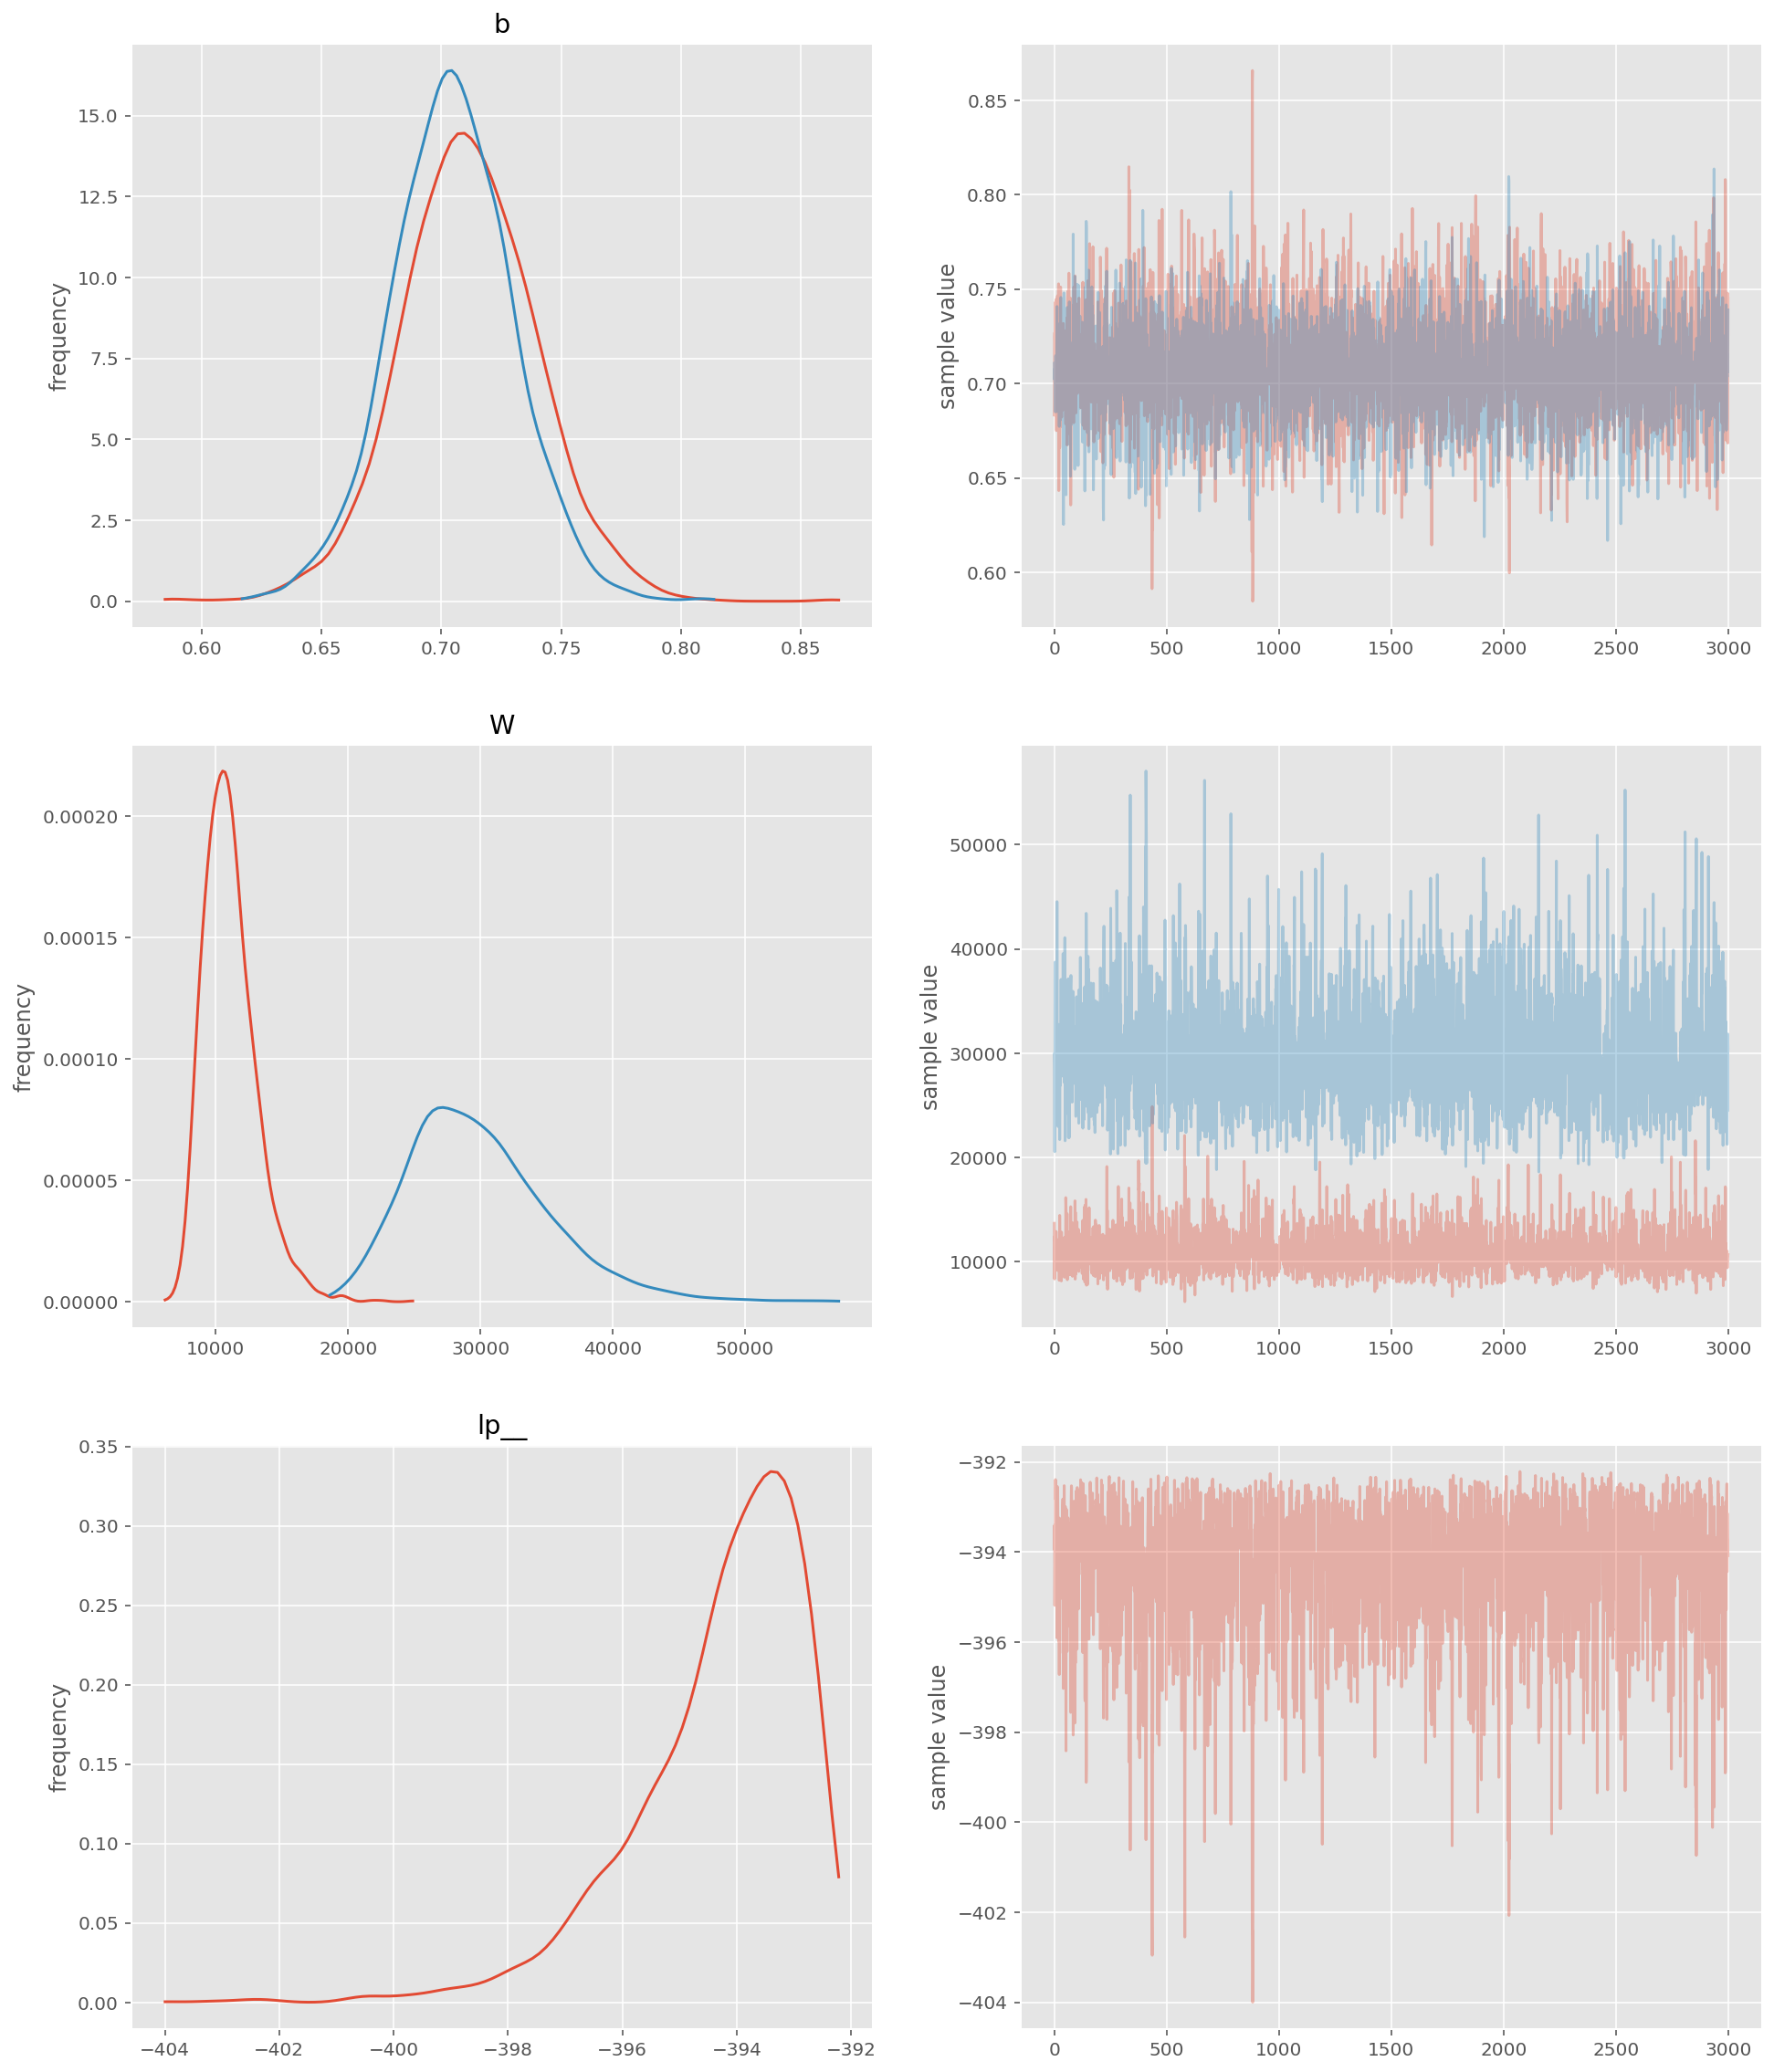

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 1.000
MAE: 35564.86231
RMSE: 49771.11979
R2: 0.865


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

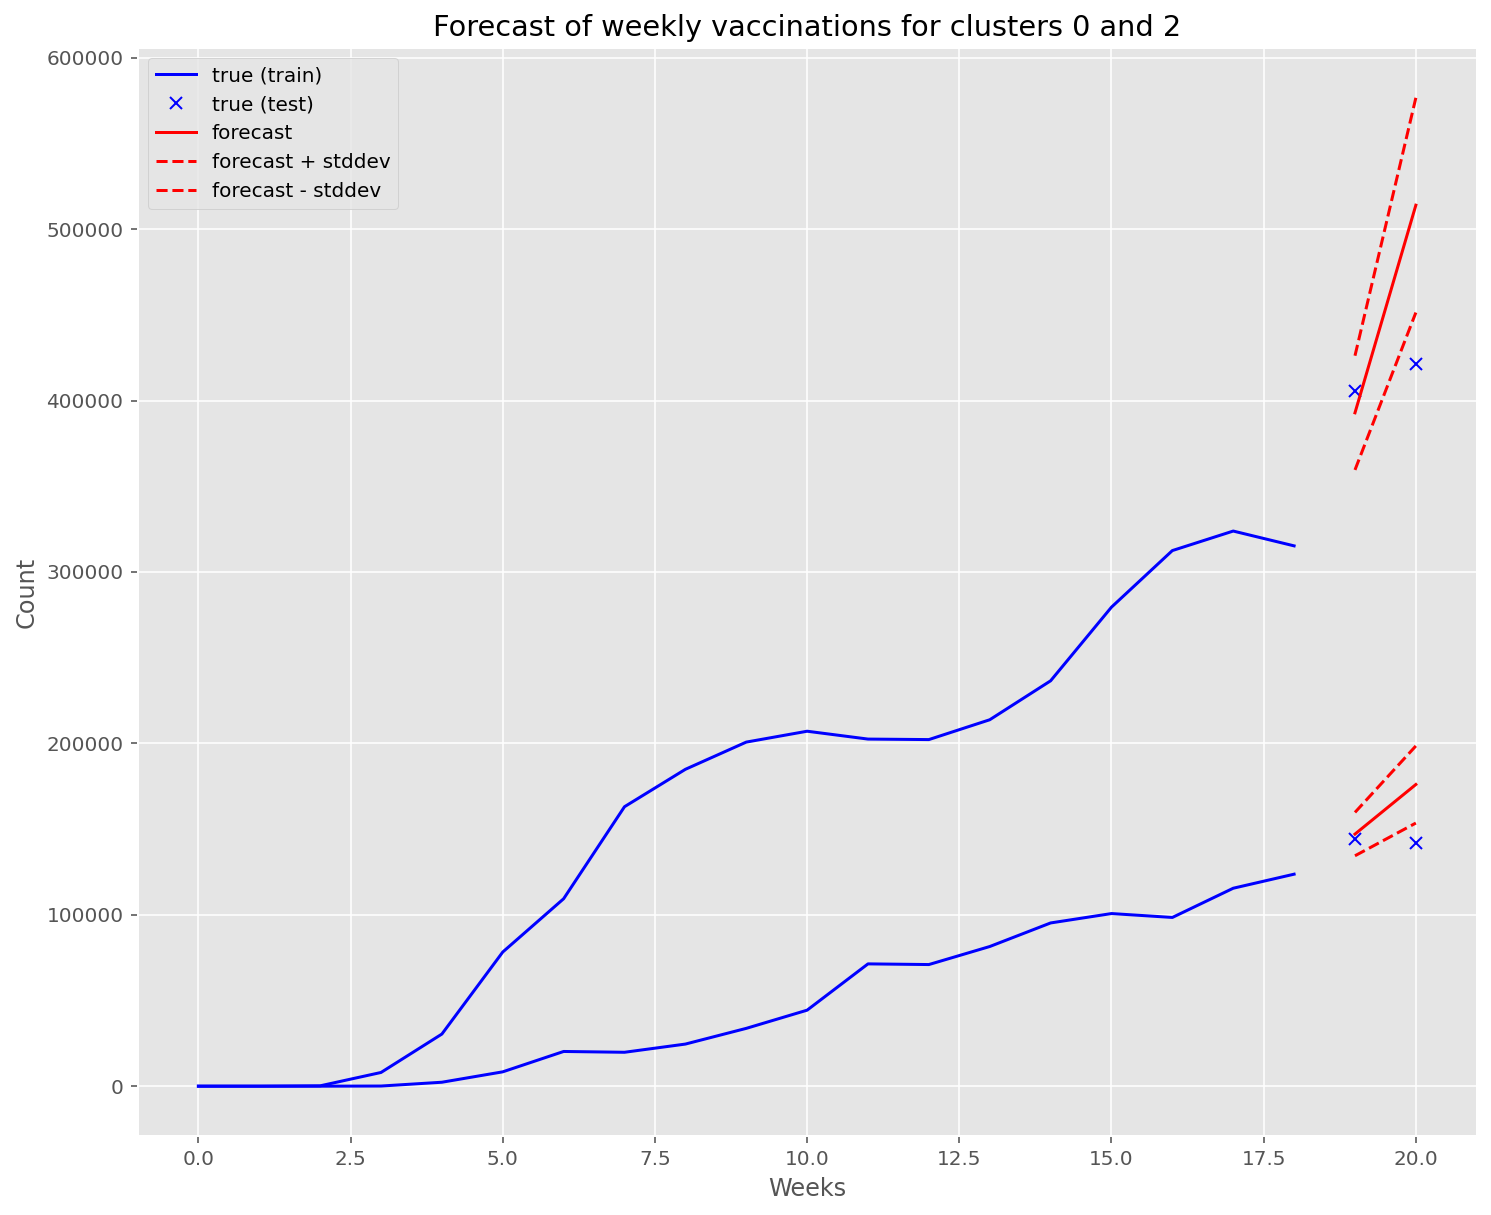

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(0,2):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for clusters 0 and 2")
plt.xlabel("Weeks")
plt.ylabel("Count")

As expected, *R2* has increased to 0.865, because giving in input to the model another temporal factor correlated to $y_{t,k}$ allowes the model to learn more features related to the target variable and thus to generate better predictions.

## 2.4 Re-introducting country-specific vaccination forecast

After having explored cluster forecasting including data standardization and a new temporal factor, given the improved results, we will apply these changes to the country-specific forecast. Note that clusters will be used only on the priors (similarly to section #2.2).





### 2.4.1 Data preparation

First of all, we create 2 new variables *y_vaccinations* and *y_fully_vaccinated*, containing the weekly vaccinations and the weekly number of people fully vaccinated across all countries.

In [ ]:
# No. of fully people vaccinated for each week and for each cluster
clusters_to_keep = [0, 2]
df_0_2 = df[df["cluster"].isin(clusters_to_keep)]
cluster_order = df_0_2.groupby(["country"])['cluster'].unique()
cluster_order = cluster_order.to_numpy(dtype=float)
cluster_order = cluster_order.astype(int)

# Target variable and temporal factor for clusters 0 & 2
y_vaccinations, y_fully_vaccinated = convert_to_weekly(df_0_2, "country", "week_vaccinations", "week_people_fully_vaccinated")

We can now standardize the data in *y_vaccinations* and *y_fully_vaccinated*:

In [ ]:
# Make numpy arrays
y_vaccinations = y_vaccinations.to_numpy()
y_fully_vaccinated = y_fully_vaccinated.values

#Standardizing
y_vaccinations_std = standardize_model(y_vaccinations)
y_fully_vaccinated_std = standardize_model(y_fully_vaccinated)
N, D = y_vaccinations_std.shape

print("Shape of weekly vaccinations array: ", y_vaccinations_std.shape, "Shape of people fully vaccinated array: ", y_fully_vaccinated_std.shape)

Shape of weekly vaccinations array:  (24, 174) Shape of people fully vaccinated array:  (24, 174)


In [ ]:
cluster_order = cluster_order + 1
for i in range(cluster_order.size):
  if cluster_order[i] == 3:
    cluster_order[i] = 2

In [ ]:
print("Cluster_order array:", cluster_order)

Cluster_order array: [1 1 1 2 1 2 1 1 1 2 2 2 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2
 1 1 2 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1
 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1]


In [ ]:
ix_train = range(19) # 19 weeks for training
ix_test = range(19, 21) # 2 weeks for testing
N_train = len(ix_train)
N_test = len(ix_test)
N=N_train+N_test
print('N:', N)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y_vaccinations_std[ix_train, :]
y_test = y_vaccinations_std[ix_test, :]
y_fullyvac = y_fully_vaccinated_std[:21, :]

N: 21
N_train: 19
N_test: 2


### 2.4.2 Model

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    int K; // num. of countries
    matrix[T,K] y;                 // time-series data
    int cluster[K];
    matrix[(T+T_forecast),K] y_fully;
}

parameters {
    vector[C] b;            // state transition coefficients
    vector<lower=0>[C] W;            // state transition coefficients
}

transformed parameters {
    matrix<lower=0>[T+T_forecast,K] fully_vacc;

    for (t in 1:T+T_forecast) {
      for (k in 1:K) {
        fully_vacc[t,k] = 1/(1+exp(-y_fully[t,k]));
      }
    }
}

model {
  for(c in 1:C) {
   	W[c] ~ cauchy(1,0.5);  
    b[c] ~ normal(1,0.5);           // prior on the auto-regressive coefficients
  }
    
    for(k in 1:K) {
      for(t in 2:T) {
        y[t,k] ~ normal(b[cluster[k]]' * y[t-1,k] *(1+fully_vacc[t,k]), W[cluster[k]]); // likelihood
      }
    }
}

generated quantities {
    matrix[T_forecast,K] y_hat;          // vector to store predictions

    for(k in 1:K) {
        y_hat[1,k] <- normal_rng(b[cluster[k]]' * y[T,k] *(1+fully_vacc[T+1,k]), W[cluster[k]]);  // predictions
  }

  for(k in 1:K) {
      for (t in 2:T_forecast) {
        y_hat[t,k] <- normal_rng(b[cluster[k]]' * y_hat[t-1,k] *(1+fully_vacc[T+T_forecast,k]), W[cluster[k]]);  // predictions
      }
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
C = 2
data = {'T': T, 'T_forecast': T_forecast, 'C': C, 'K': D ,'y': y_train, 'cluster':cluster_order, 'y_fully':y_fullyvac}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_652bf3db398b8315367ff4265a92efe0 NOW.


CPU times: user 1.76 s, sys: 114 ms, total: 1.88 s
Wall time: 1min 11s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_652bf3db398b8315367ff4265a92efe0.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                      mean se_mean      sd    2.5%    25%     50%     75%  97.5%  n_eff   Rhat
b[1]                  0.56  6.7e-5  4.6e-3    0.55   0.55    0.56    0.56   0.57   4650    1.0
b[2]                  0.56  9.8e-5  5.9e-3    0.55   0.56    0.56    0.56   0.57   3625    1.0
W[1]                  0.22  6.4e-5  3.2e-3    0.21   0.22    0.22    0.22   0.23   2442    1.0
W[2]                  0.38  2.0e-4    0.01    0.36   0.37    0.38    0.39    0.4   2582    1.0
fully_vacc[1,1]       0.45 3.2e-17 5.6e-17    0.45   0.45    0.45    0.45   0.45      3    1.0
fully_vacc[2,1]       0.45 3.2e-17 5.6e-17    0.45   0.45    0.45    0.45   0.45      3    1.0
fully_vacc[3,1]       0.45 3.2e-17 5.6e-17    0.45   0.45    0.45    0.45   0.45      3    1.0
fully_vacc[4,1]       0.45 3.2e-17 5.6e-17    0.45   

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 174)
y_test.shape: (2, 174)
y_hat_mean.shape: (2, 174)


We can now plot the samples...

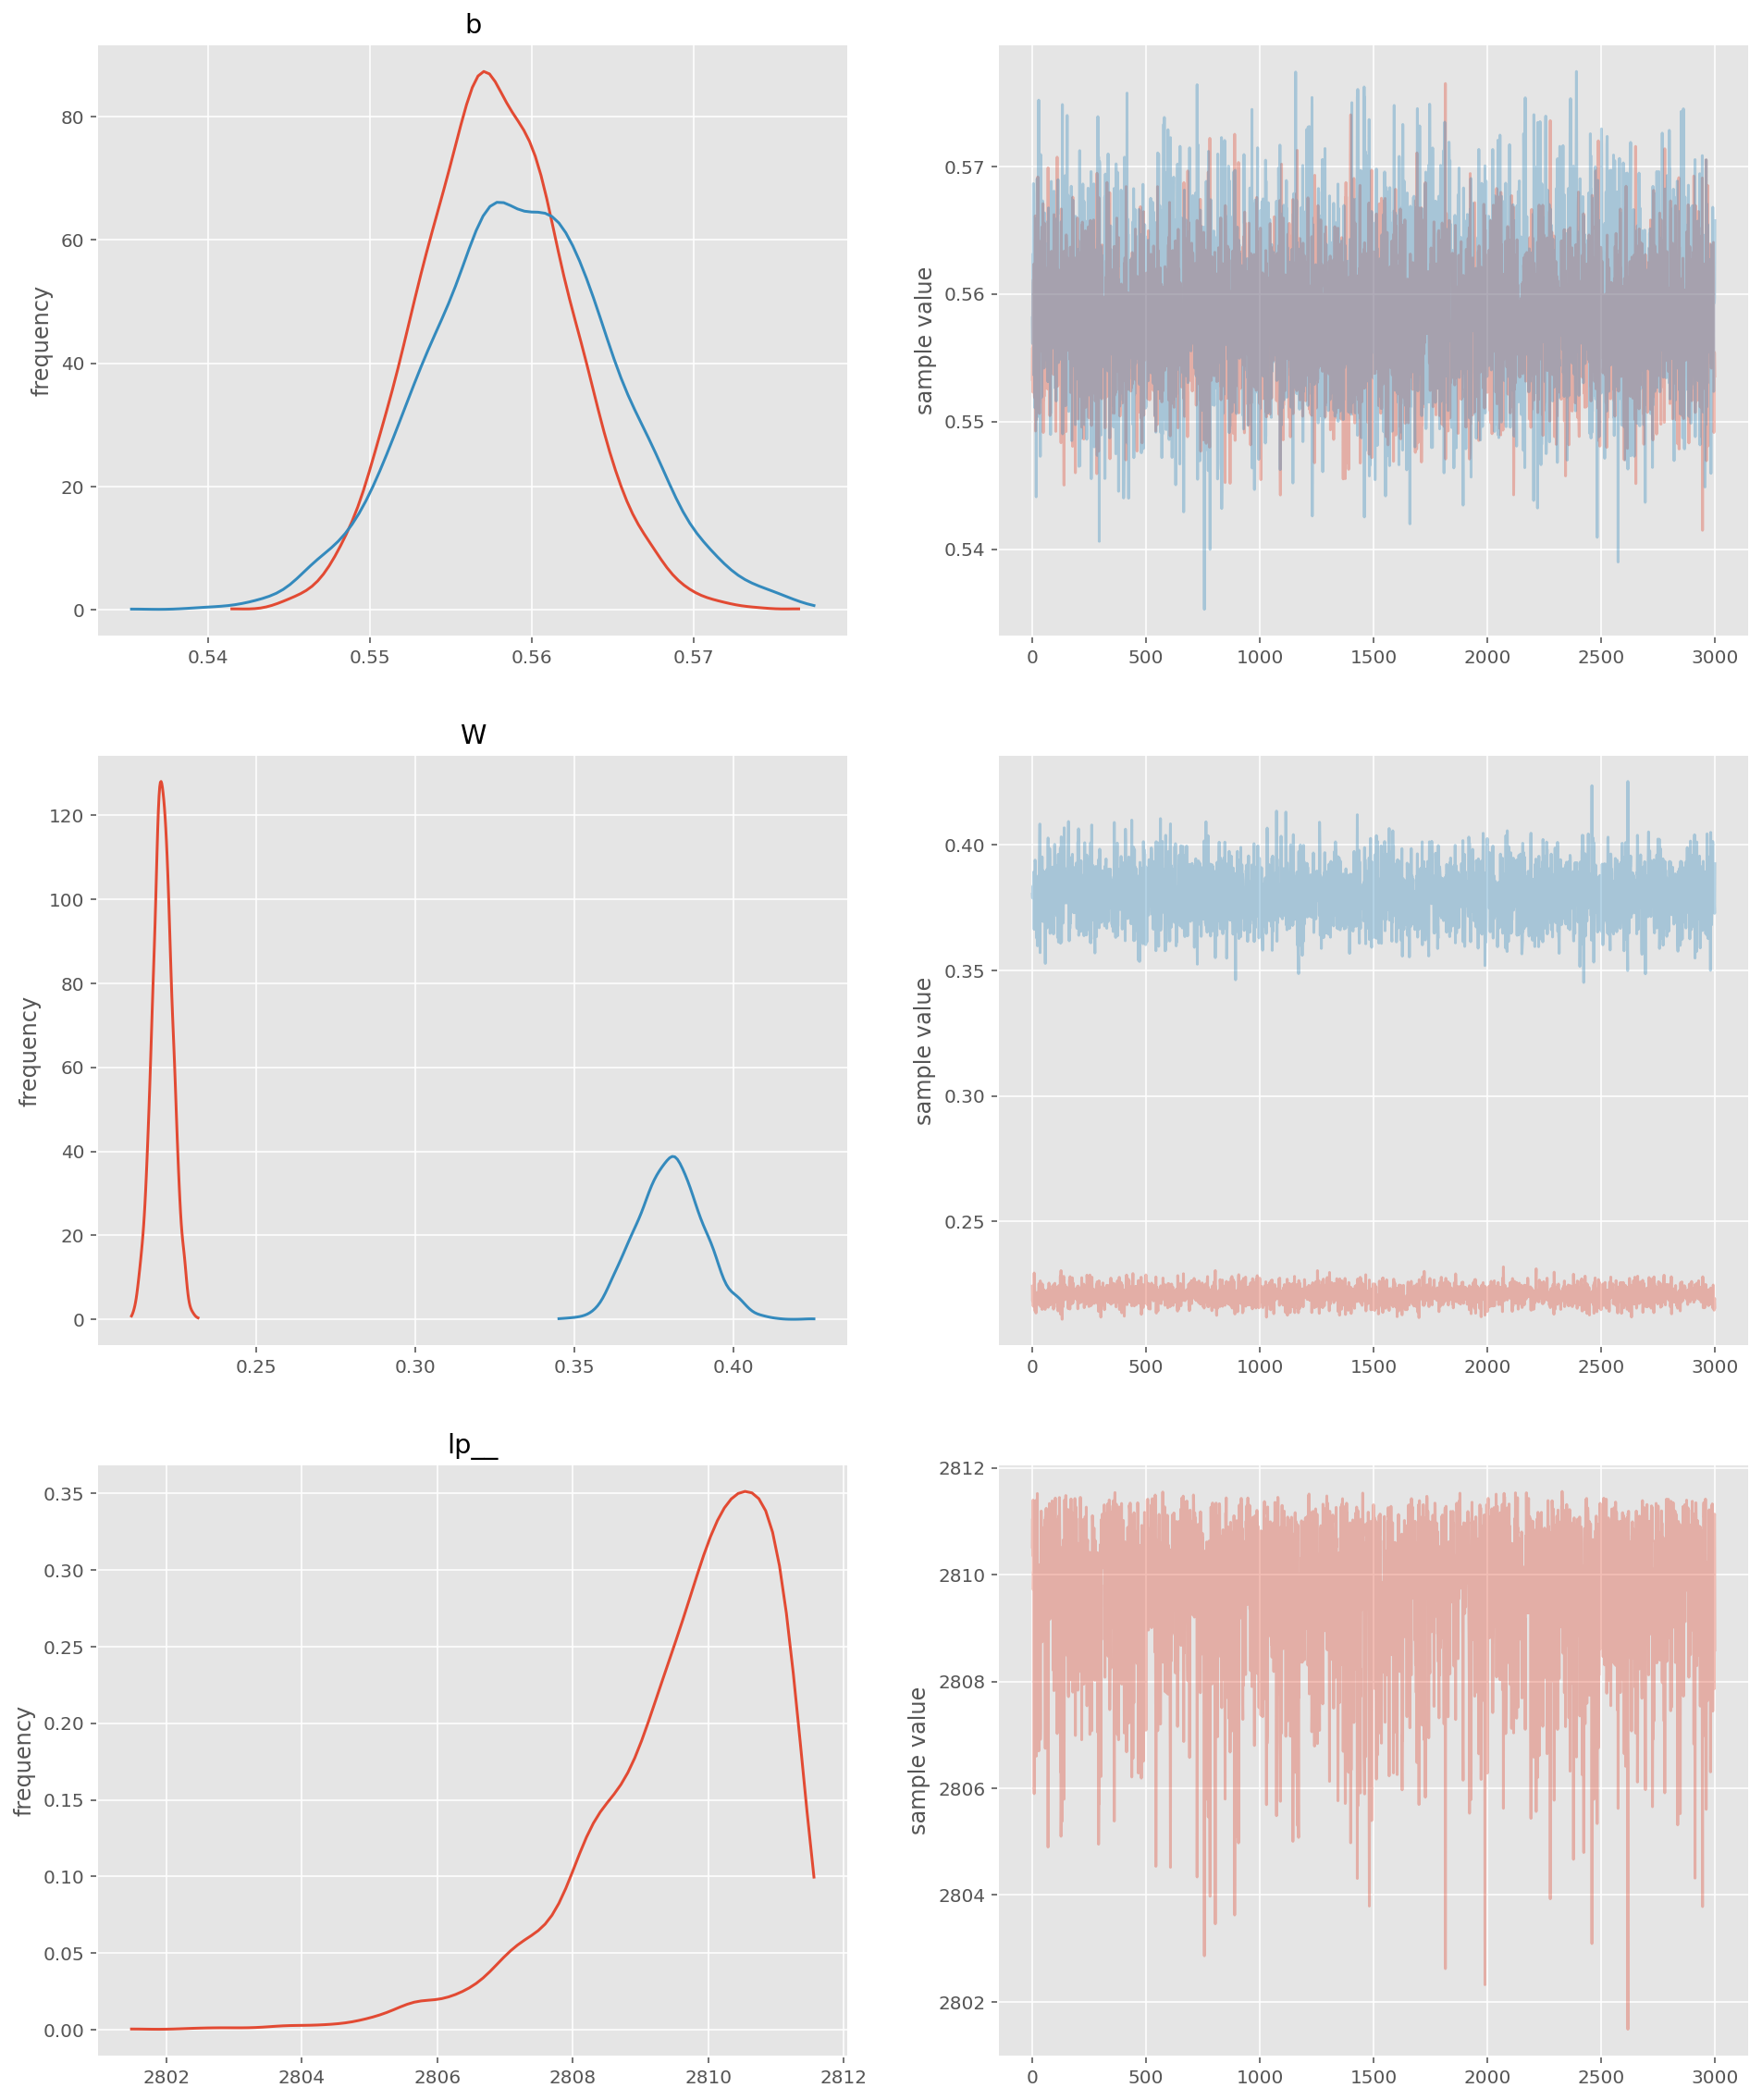

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.999
MAE: 0.18391
RMSE: 0.38599
R2: 0.930


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

We can now de-standardize the data to see what are the real values of our forecast:

In [ ]:
y_hat = y_hat * np.std(y_vaccinations) + np.mean(y_vaccinations)
y_train = y_train * np.std(y_vaccinations) + np.mean(y_vaccinations)
y_test_mean = y_test * np.std(y_vaccinations) + np.mean(y_vaccinations)
y_std = y_std * np.std(y_vaccinations) + np.mean(y_vaccinations)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

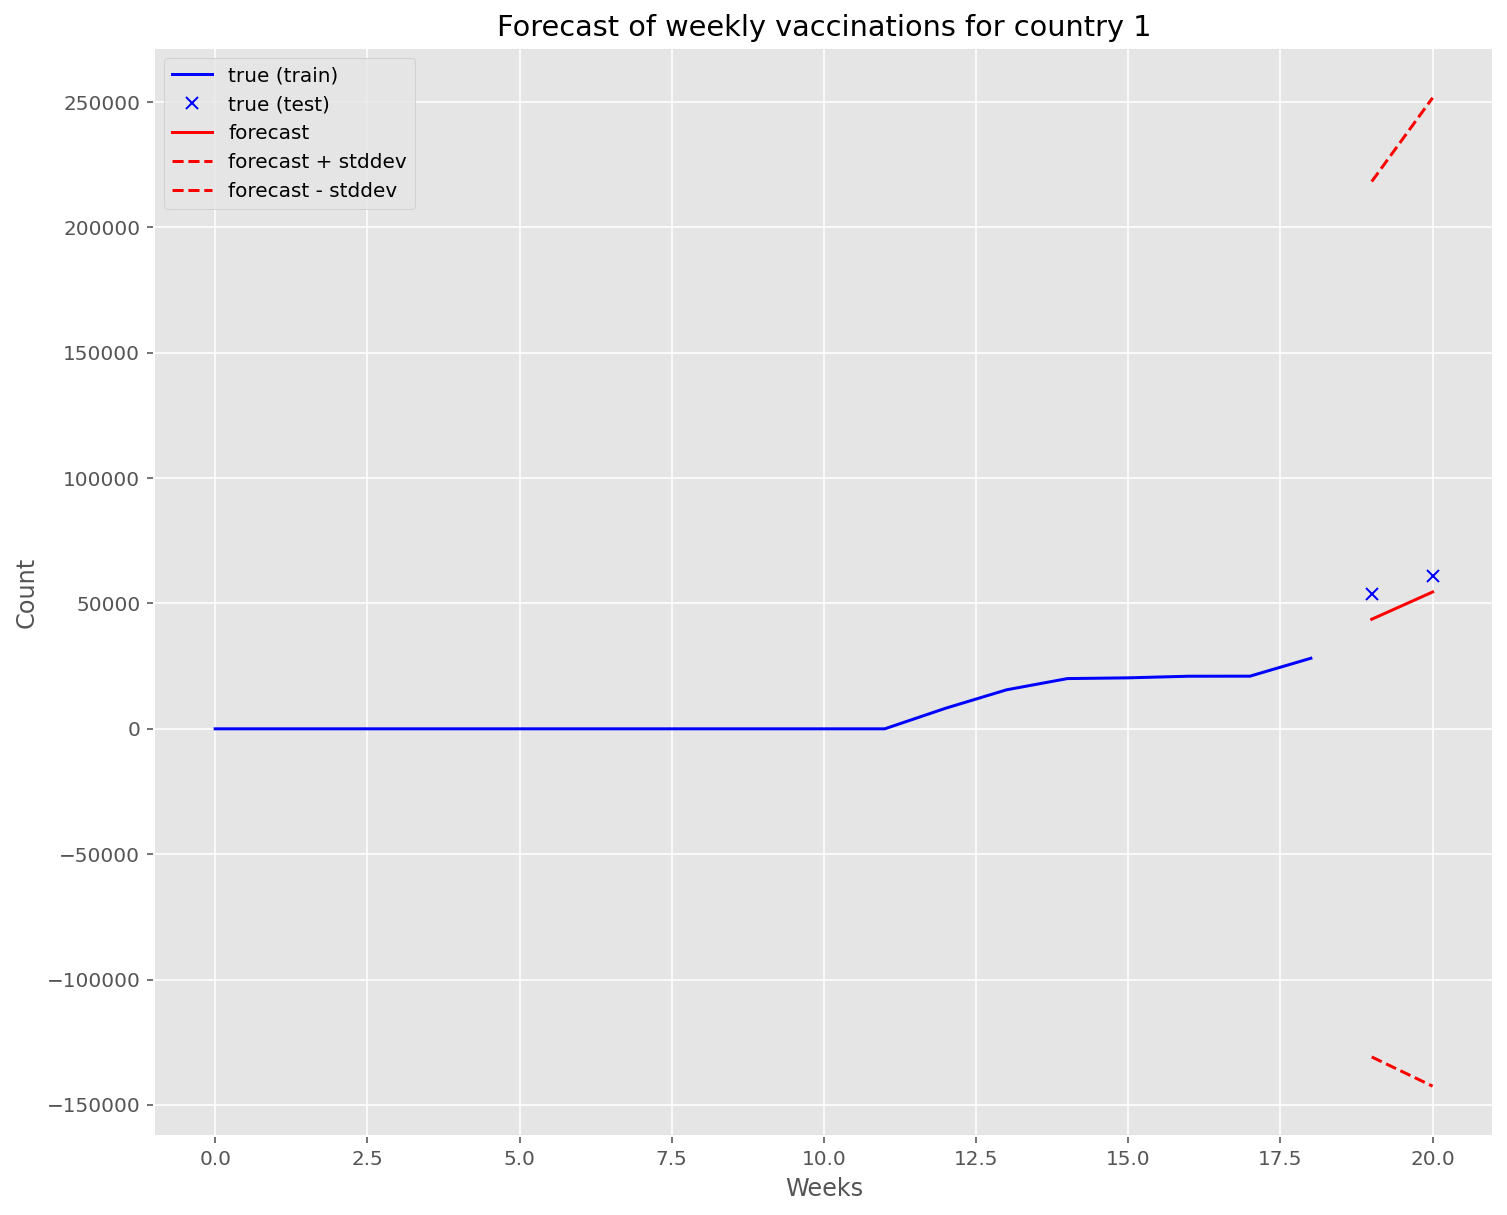

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of weekly vaccinations for country 1")
plt.xlabel("Weeks")
plt.ylabel("Count")

The model shows an impressive improvement compared to the one in section 2.2, as the chains are well mixed and the *R2* has increased to 0.930. This suggests that applying data standardization and adding a temporal factor allows to have a better prediction.

Regarding $y_{std}$, the range of values is so big since it takes into account both clusters, which have difrentrange of weekly vaccinations. The picture below displays the standard deviation of the weekly vaccinations for every country. This is, each data point represents the standard deviation that a country had in a given week. Hence, as explaiend above, it is clear the $y_{std}$ is so different because it takes into account clusters 0 and 2.

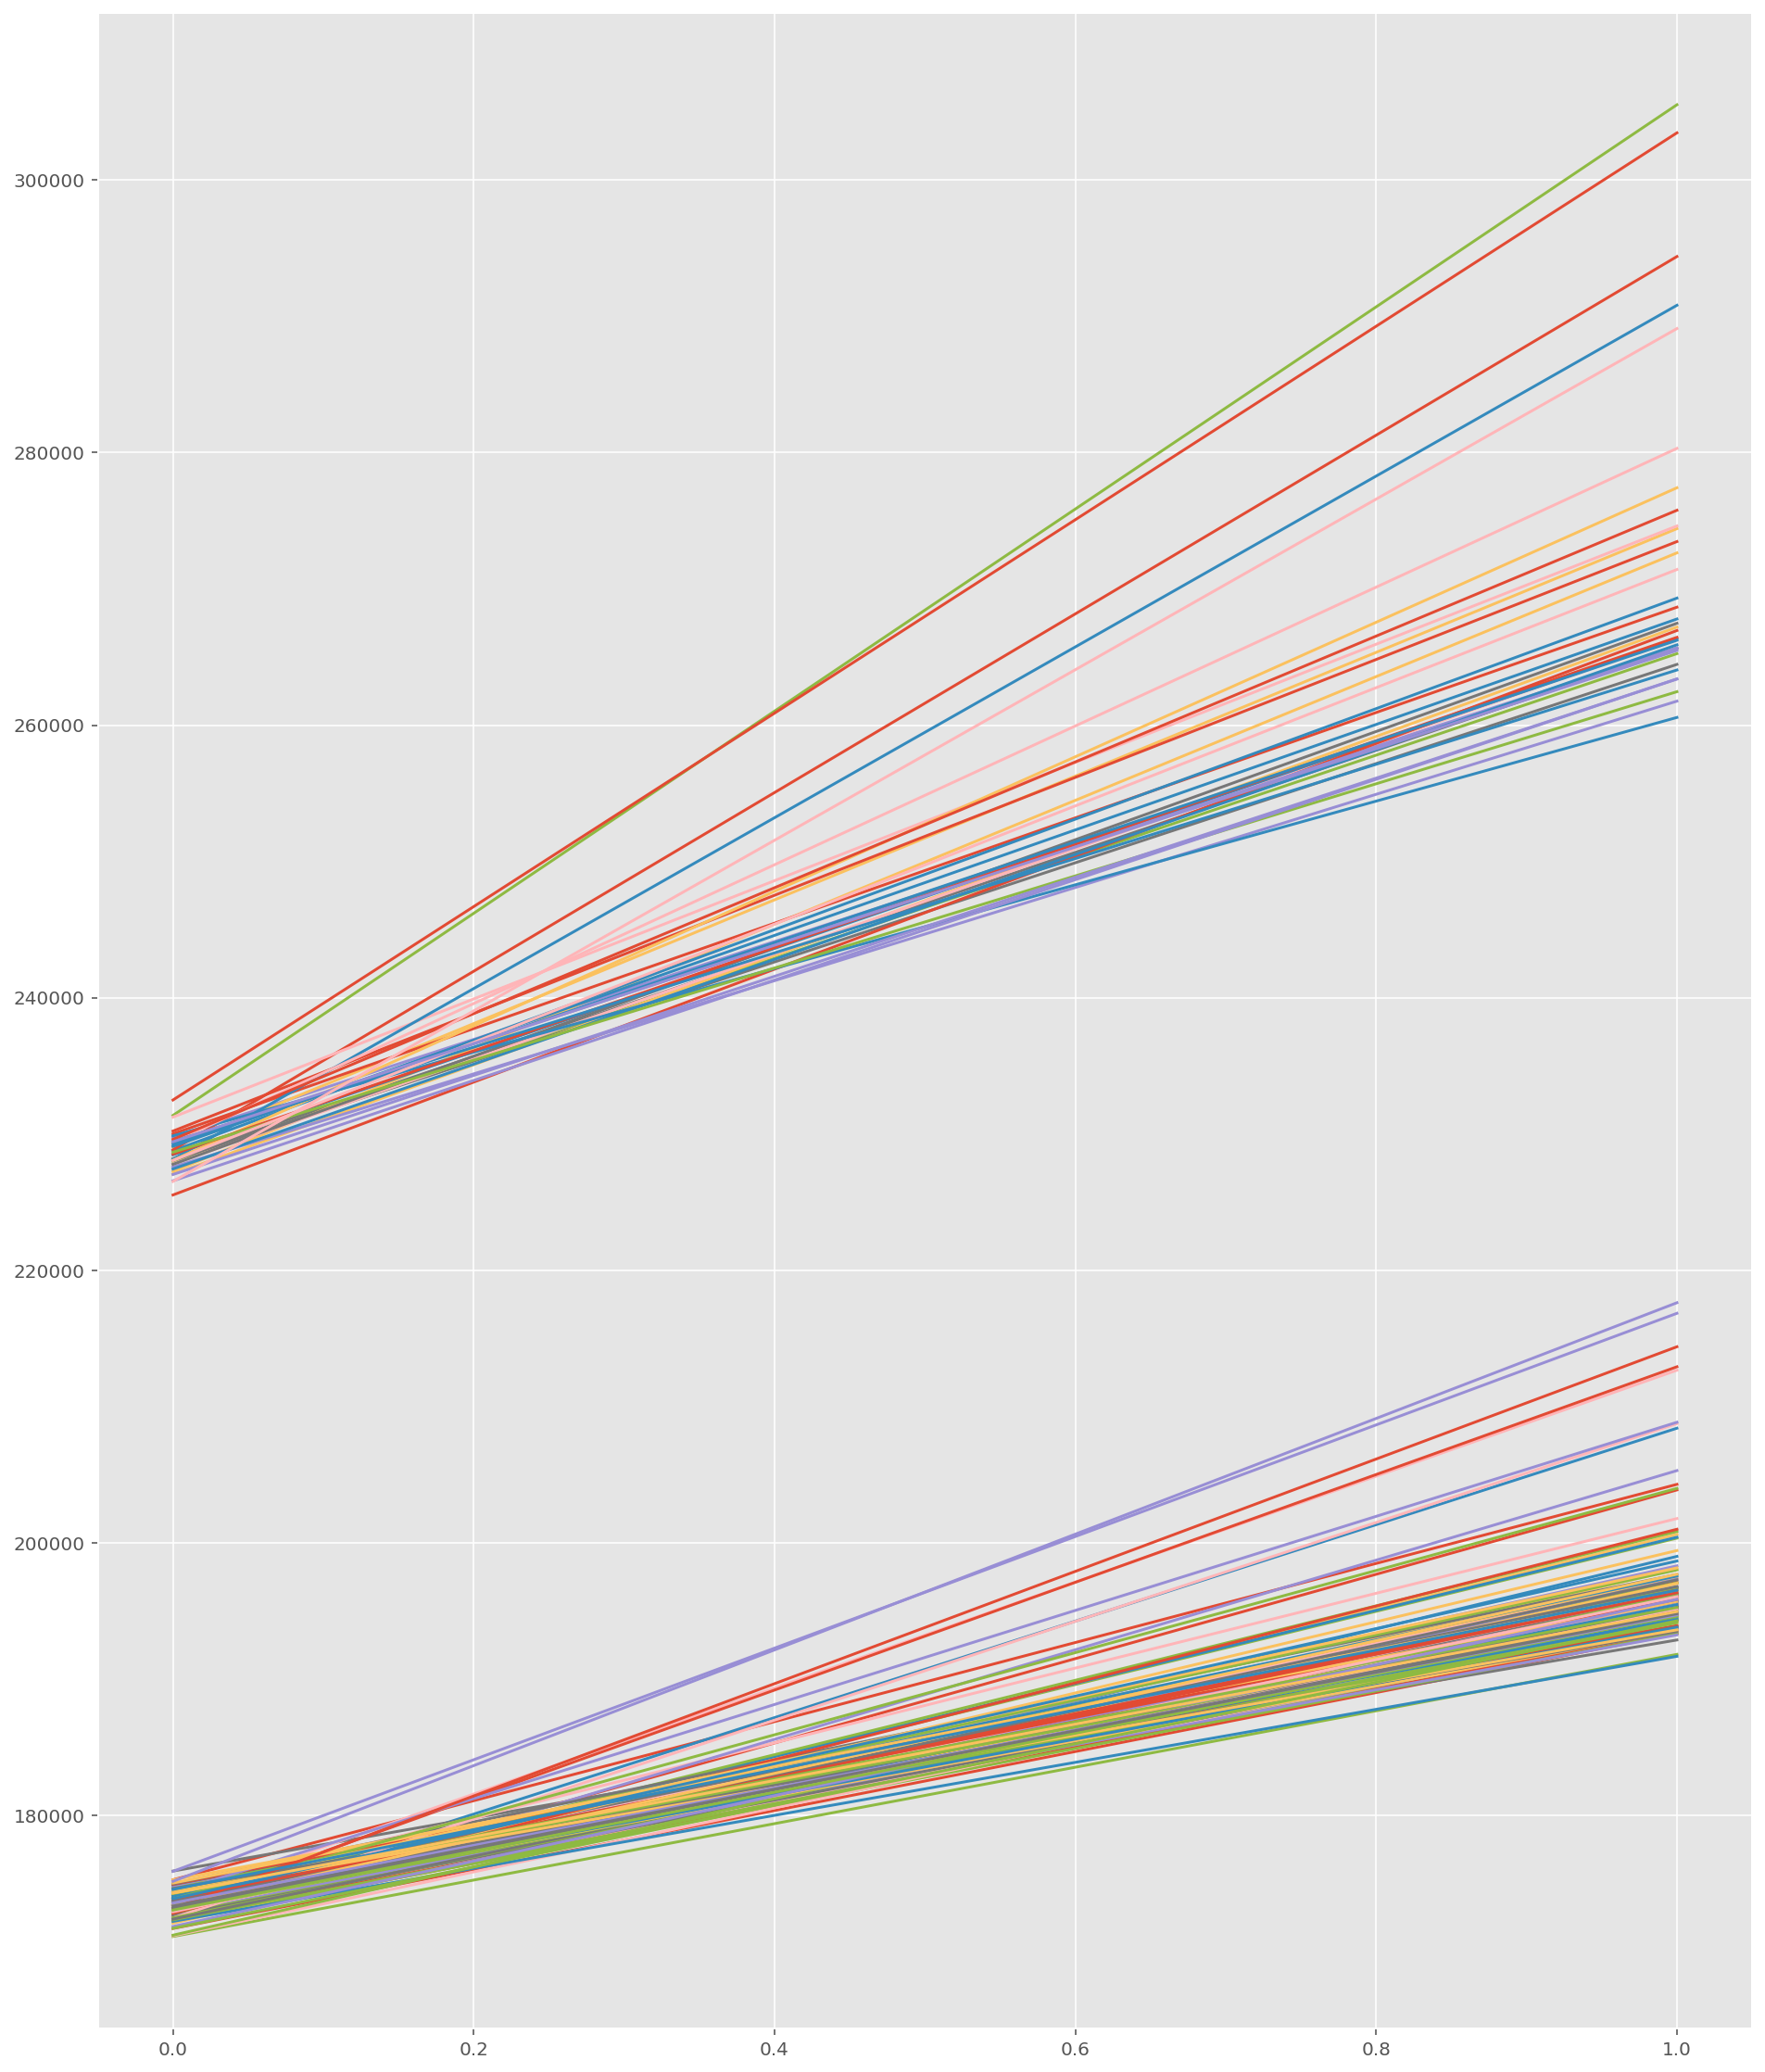

In [ ]:
#plt.plot(weeks, y_std)

## 2.5 AR(2) model: country-specific vaccination forecast

In this section we will implement an AR(2) model to understand if including another time step dependency to our target variable $y_{t,k}$ will improve the model.

We will run again the *data preparation* subsection again to re-standardize the data.

### 2.5.1 Data preparation

First of all, we create 2 new variables *y_vaccinations* and *y_fully_vaccinated*, containing the weekly vaccinations and the weekly number of people fully vaccinated across all countries.

In [ ]:
# No. of fully people vaccinated for each week and for each cluster
clusters_to_keep = [0, 2]
df_0_2 = df[df["cluster"].isin(clusters_to_keep)]
cluster_order = df_0_2.groupby(["country"])['cluster'].unique()
cluster_order = cluster_order.to_numpy(dtype=float)
cluster_order = cluster_order.astype(int)

# Target variable and temporal factor for clusters 0 & 2
y_vaccinations, y_fully_vaccinated = convert_to_weekly(df_0_2, "country", "week_vaccinations", "week_people_fully_vaccinated")

We can now standardize the data in *y_vaccinations* and *y_fully_vaccinated* 

In [ ]:
# Make numpy arrays
y_vaccinations = y_vaccinations.to_numpy()
y_fully_vaccinated = y_fully_vaccinated.values

#Standardizing
y_vaccinations_std = standardize_model(y_vaccinations)
y_fully_vaccinated_std = standardize_model(y_fully_vaccinated)
N, D = y_vaccinations_std.shape

print("Shape of weekly vaccinations array: ", y_vaccinations_std.shape, "Shape of people fully vaccinated array: ", y_fully_vaccinated_std.shape)

Shape of weekly vaccinations array:  (24, 174) Shape of people fully vaccinated array:  (24, 174)


In [ ]:
cluster_order = cluster_order + 1
for i in range(cluster_order.size):
  if cluster_order[i] == 3:
    cluster_order[i] = 2

In [ ]:
print("Cluster_order array:", cluster_order)

Cluster_order array: [1 1 1 2 1 2 1 1 1 2 2 2 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2
 1 1 2 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1
 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1]


In [ ]:
ix_train = range(19) # 19 weeks for training
ix_test = range(19, 21) # 2 weeks for testing
N_train = len(ix_train)
N_test = len(ix_test)
N=N_train+N_test
print('N:', N)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y_vaccinations_std[ix_train, :]
y_test = y_vaccinations_std[ix_test, :]
y_fullyvac = y_fully_vaccinated_std[:21, :]

N: 21
N_train: 19
N_test: 2


### 2.5.2 Model

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    int K; // num. of countries
    matrix[T,K] y;                 // time-series data
    int cluster[K];
    real y_fully[(T+T_forecast),K];
}

parameters {
    matrix[2,C] b;            // state transition coefficients
    vector<lower=0>[C] W;            // state transition coefficients 
}

transformed parameters {
    real<lower=0> fully_vacc[T+T_forecast,K];

    for (t in 1:T+T_forecast) {
      for (k in 1:K){
        fully_vacc[t,k] = 1/(1+exp(-y_fully[t,k]));
      }
    }
}

model {
  for(c in 1:C) {
    for(i in 1:2) {
      b[i,c] ~ normal(1,0.5);           // prior on the auto-regressive coefficients
    }
  }
  for(c in 1:C) {
      W[c] ~ cauchy(1,0.5);  
  }
  for(k in 1:K) {
    for(t in 3:T) {
        y[t,k] ~ normal((b[1,cluster[k]]' * y[(t-2),k] + b[2,cluster[k]]' * y[(t-1),k])*(1+fully_vacc[t,k]), W[cluster[k]]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,K] y_hat;          // vector to store predictions

  for(k in 1:K) {
    y_hat[1,k] <- normal_rng((b[1,cluster[k]]' * y[(T-1),k]+  b[2,cluster[k]]' * y[T,k])*(1+fully_vacc[T+1,k]), W[cluster[k]]);  // predictions
    y_hat[2,k] <- normal_rng((b[1,cluster[k]]' * y[T,k] +b[2,cluster[k]]' * y_hat[1,k])*(1+fully_vacc[T+2,k]) , W[cluster[k]]);  // predictions
  }
}
"""

In [ ]:
# Label data for Stan model
T_forecast = len(ix_test)
T = len(y_train)
C=2
data = {'T': T, 'T_forecast': T_forecast, 'C': C, 'K': D ,'y': y_train, 'cluster':cluster_order, 'y_fully': y_fullyvac}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_45b5fa134c5b002aa8b61faa795d578a NOW.


CPU times: user 1.88 s, sys: 154 ms, total: 2.03 s
Wall time: 1min 11s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_45b5fa134c5b002aa8b61faa795d578a.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                      mean se_mean      sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
b[1,1]               -0.05  3.0e-4    0.01  -0.08  -0.06   -0.05   -0.04  -0.03   2093    1.0
b[2,1]                 0.6  2.8e-4    0.01   0.58   0.59     0.6    0.61   0.63   2122    1.0
b[1,2]               -0.25  7.4e-4    0.03  -0.31  -0.27   -0.25   -0.23  -0.19   1759    1.0
b[2,2]                0.79  6.9e-4    0.03   0.73   0.77    0.79    0.81   0.84   1753    1.0
W[1]                  0.23  6.2e-5  3.3e-3   0.22   0.22    0.23    0.23   0.23   2809    1.0
W[2]                  0.37  2.3e-4    0.01   0.35   0.36    0.37    0.38   0.39   2161    1.0
fully_vacc[1,1]       0.45 3.2e-17 5.6e-17   0.45   0.45    0.45    0.45   0.45      3    1.0
fully_vacc[2,1]       0.45 3.2e-17 5.6e-17   0.45   0.45    0

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 174)
y_test.shape: (2, 174)
y_hat_mean.shape: (2, 174)


We can now plot the samples...

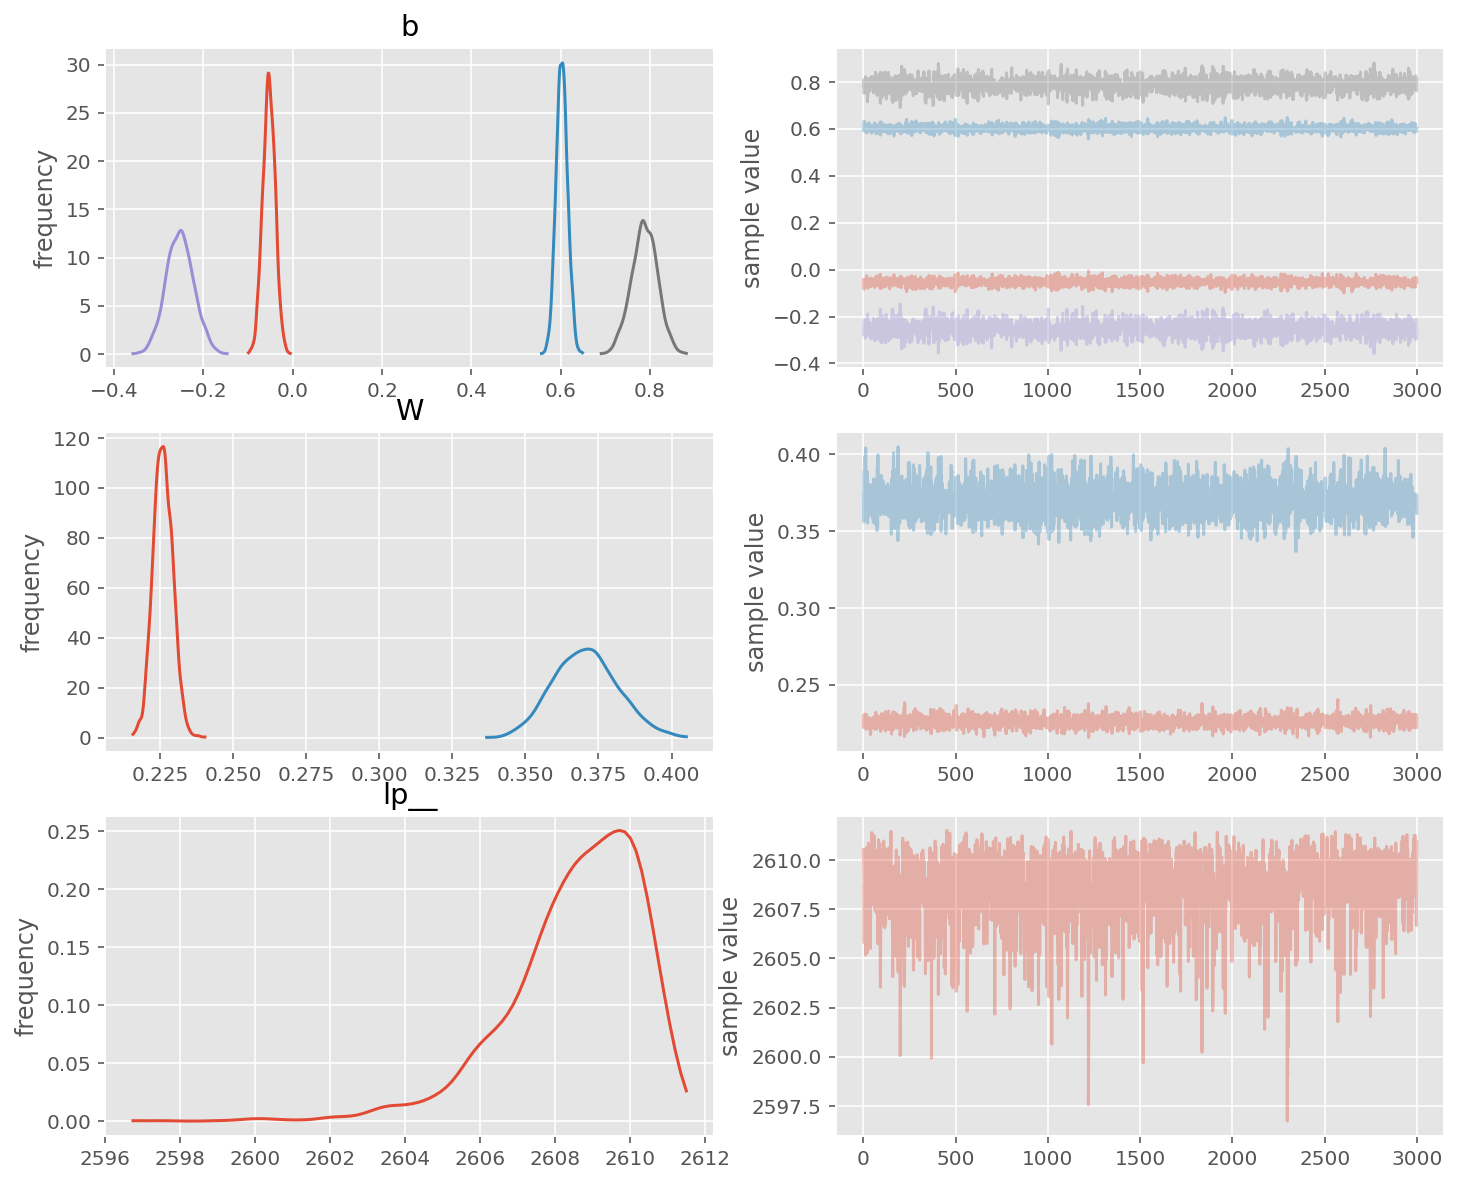

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.997
MAE: 0.20402
RMSE: 0.47327
R2: 0.895


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

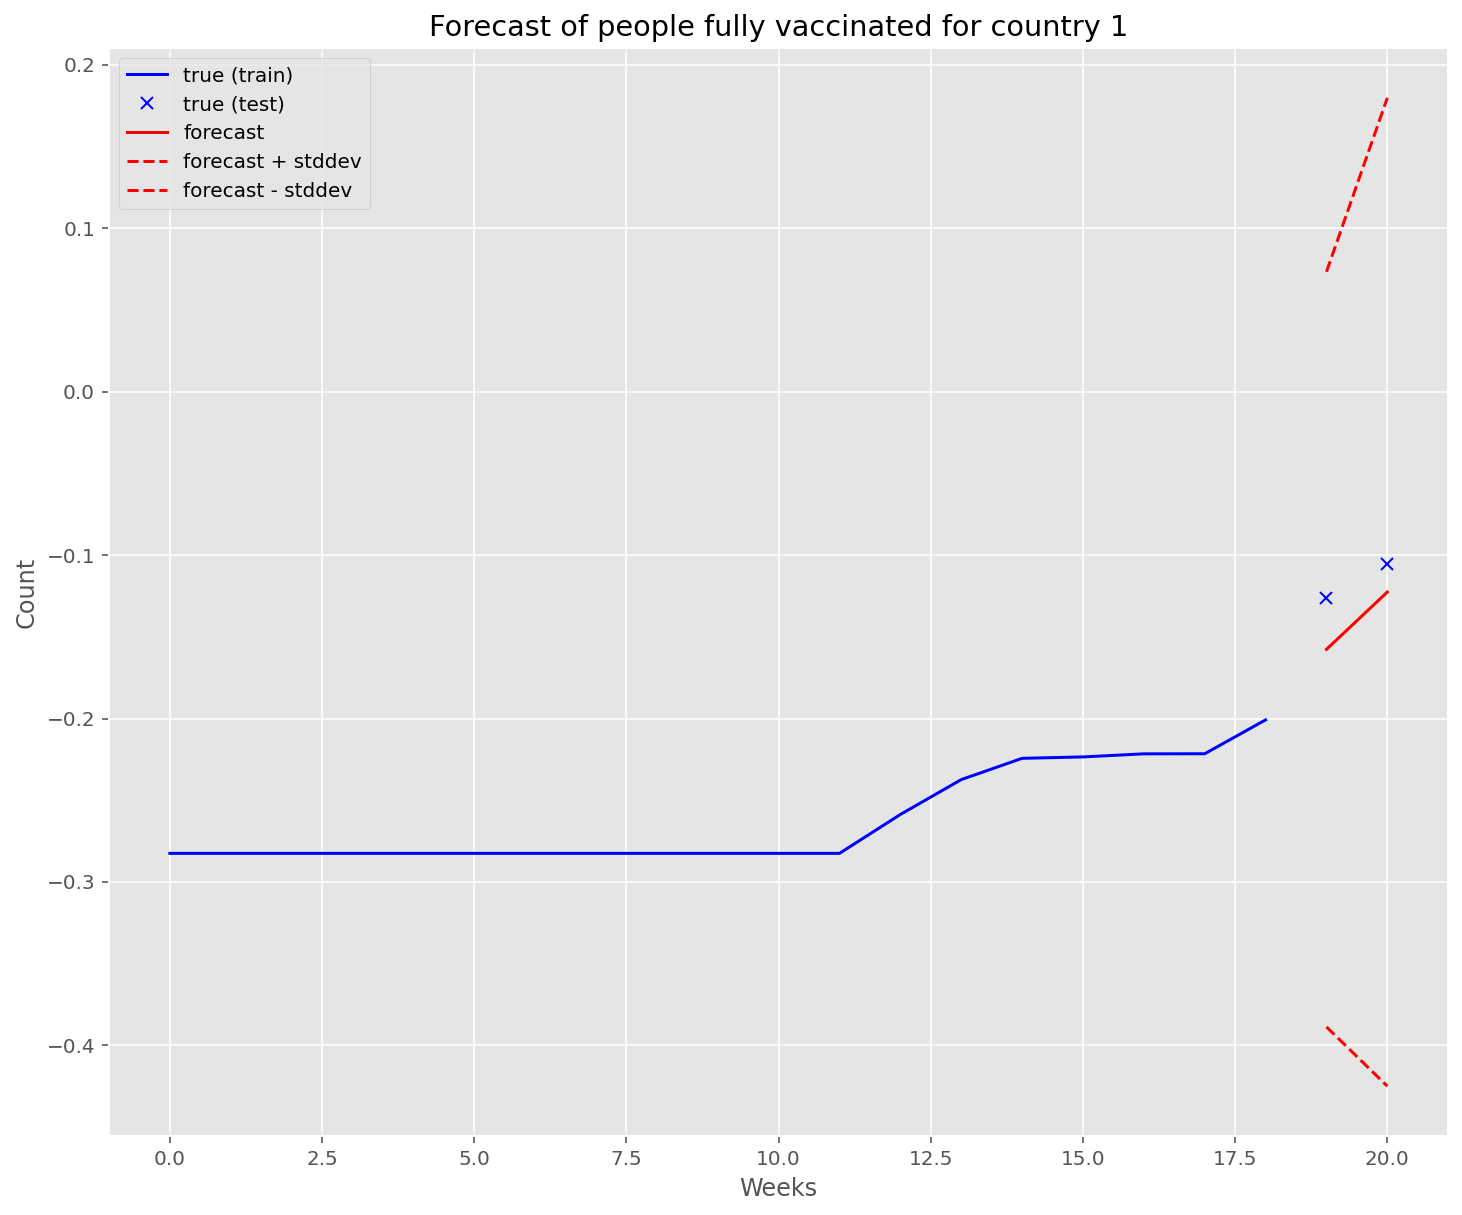

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of people fully vaccinated for country 1")
plt.xlabel("Weeks")
plt.ylabel("Count")

With the Auto-regressive model of order 2, the forecast accuracy decreased to 0.895. This is probably due to the trend of our data, which is not growing uniformely for all the countries throughout time. Instead, the weekly vaccinations are quite irregular and have peaks and valleys. Therefore, if in general the AR(2) leads to a more accurate prediction for more stable data, in our specific case of weekly vaccinations the variability in the data does not allow to obatin a better forecast.

## 2.6 Adding a hiearchical model on the AR(2)

We will now introduce a Hierarchical Model on the AR(2), imposing the mean and standard deviations of our coefficients *b* and standard deviation *W* to assume some specific values. These numbers have been identified after running the model multiple times and observing the results from the chains and the convergence of the parameters to specific values.

In [ ]:
# Define Stan model with clusters
model_definition = """
data {
    int T;            // length of the time-series
    int T_forecast;   // num. steps ahead to predict
    int C;  // num. clusters
    int K; // num. of countries
    matrix[T,K] y;                 // time-series data
    int cluster[K];
    real y_fully[(T+T_forecast),K];
    real mu_b_t1_c1;
    real mu_b_t2_c1;
    real mu_b_t1_c2;
    real mu_b_t2_c2;
    real std_b_t1_c1;
    real std_b_t2_c1;
    real std_b_t1_c2;
    real std_b_t2_c2;
    real mu_W_c1;
    real mu_W_c2;
    real std_W_c1;
    real std_W_c2;
}

parameters {
    matrix[2,C] b;            // state transition coefficients
    vector<lower=0>[C] W;            // state transition coefficients 
}

transformed parameters {
    real<lower=0> fully_vacc[T+T_forecast,K];

    for (t in 1:T+T_forecast) {
      for (k in 1:K){
        fully_vacc[t,k] = 1/(1+exp(-y_fully[t,k]));
      }
    }
}

model {
  b[1,1] ~ normal(mu_b_t1_c1, std_b_t1_c1);
  b[2,1] ~ normal(mu_b_t2_c1, std_b_t2_c1);
  b[1,2] ~ normal(mu_b_t1_c2, std_b_t1_c2);
  b[2,2] ~ normal(mu_b_t2_c2, std_b_t2_c2);
  W[1] ~ cauchy(mu_W_c1, std_W_c1);
  W[2] ~ cauchy(mu_W_c2, std_W_c2);

  for(k in 1:K) {
    for(t in 3:T) {
        y[t,k] ~ normal((b[1,cluster[k]]' * y[(t-2),k] + b[2,cluster[k]]' * y[(t-1),k])*(1+fully_vacc[t,k]), W[cluster[k]]); // likelihood
    }
  }
}

generated quantities {
  matrix[T_forecast,K] y_hat;          // vector to store predictions

  for(k in 1:K) {
    y_hat[1,k] <- normal_rng((b[1,cluster[k]]' * y[(T-1),k]+  b[2,cluster[k]]' * y[T,k])*(1+fully_vacc[T+1,k]), W[cluster[k]]);  // predictions
    y_hat[2,k] <- normal_rng((b[1,cluster[k]]' * y[T,k] +b[2,cluster[k]]' * y_hat[1,k])*(1+fully_vacc[T+2,k]) , W[cluster[k]]);  // predictions
  }
}
"""

In [ ]:
# Label data for Stan model
mu_b_t1_c1 = -0.06
mu_b_t2_c1 = 0.6
mu_b_t1_c2 = -0.25
mu_b_t2_c2 = 0.78
std_b_t1_c1 = 6.8e-3
std_b_t2_c1 = 6.5e-3
std_b_t1_c2 = 0.02
std_b_t2_c2 = 0.02
mu_W_c1 = 0.23
mu_W_c2 = 0.37
std_W_c1 = 2.6e-3
std_W_c2 = 7.8e-3
T_forecast = len(ix_test)
T = len(y_train)
C=2
data = {'T': T, 'T_forecast': T_forecast, 'C': C, 'K': D ,'y': y_train, 'cluster':cluster_order, 'y_fully': y_fullyvac, 'mu_b_t1_c1': mu_b_t1_c1, 'mu_b_t2_c1': mu_b_t2_c1, 'mu_b_t1_c2': mu_b_t1_c2, 'mu_b_t2_c2': mu_b_t2_c2, 'std_b_t1_c1': std_b_t1_c1, 'std_b_t2_c1': std_b_t2_c1, 'std_b_t1_c2': std_b_t1_c2, 'std_b_t2_c2': std_b_t2_c2, 'mu_W_c1': mu_W_c1, 'mu_W_c2': mu_W_c2, 'std_W_c1': std_W_c1, 'std_W_c2': std_W_c2}

In [ ]:
%%time
# Create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7531e4e495af2894760ba5832262ab4 NOW.


CPU times: user 1.91 s, sys: 200 ms, total: 2.11 s
Wall time: 1min 13s


In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=6, algorithm="NUTS", seed=42, verbose=True)
print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_c7531e4e495af2894760ba5832262ab4.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                      mean se_mean      sd   2.5%     25%     50%     75%  97.5%  n_eff   Rhat
b[1,1]               -0.06  9.7e-5  5.1e-3  -0.07   -0.06   -0.06   -0.05  -0.05   2779    1.0
b[2,1]                 0.6  8.7e-5  4.7e-3   0.59     0.6     0.6    0.61   0.61   2945    1.0
b[1,2]               -0.25  3.3e-4    0.01  -0.28   -0.26   -0.25   -0.24  -0.22   1645    1.0
b[2,2]                0.78  3.1e-4    0.01   0.76    0.78    0.78    0.79   0.81   1613    1.0
W[1]                  0.23  5.0e-5  2.5e-3   0.22    0.23    0.23    0.23   0.23   2549    1.0
W[2]                  0.37  1.3e-4  6.8e-3   0.36    0.37    0.37    0.37   0.38   2611    1.0
fully_vacc[1,1]       0.45 3.2e-17 5.6e-17   0.45    0.45    0.45    0.45   0.45      3    1.0
fully_vacc[2,1]       0.45 3.2e-17 5.6e-17   0.45    

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
y_hat= samples["y_hat"]
print('y_hat.shape:', y_hat.shape)
print('y_test.shape:', y_test[:,:].shape)
y_test_mean=y_test[:,:]
y_hat_mean= np.mean(y_hat, axis=0)
print('y_hat_mean.shape:', y_hat_mean.shape)

y_hat.shape: (3000, 2, 174)
y_test.shape: (2, 174)
y_hat_mean.shape: (2, 174)


We can now plot the samples...

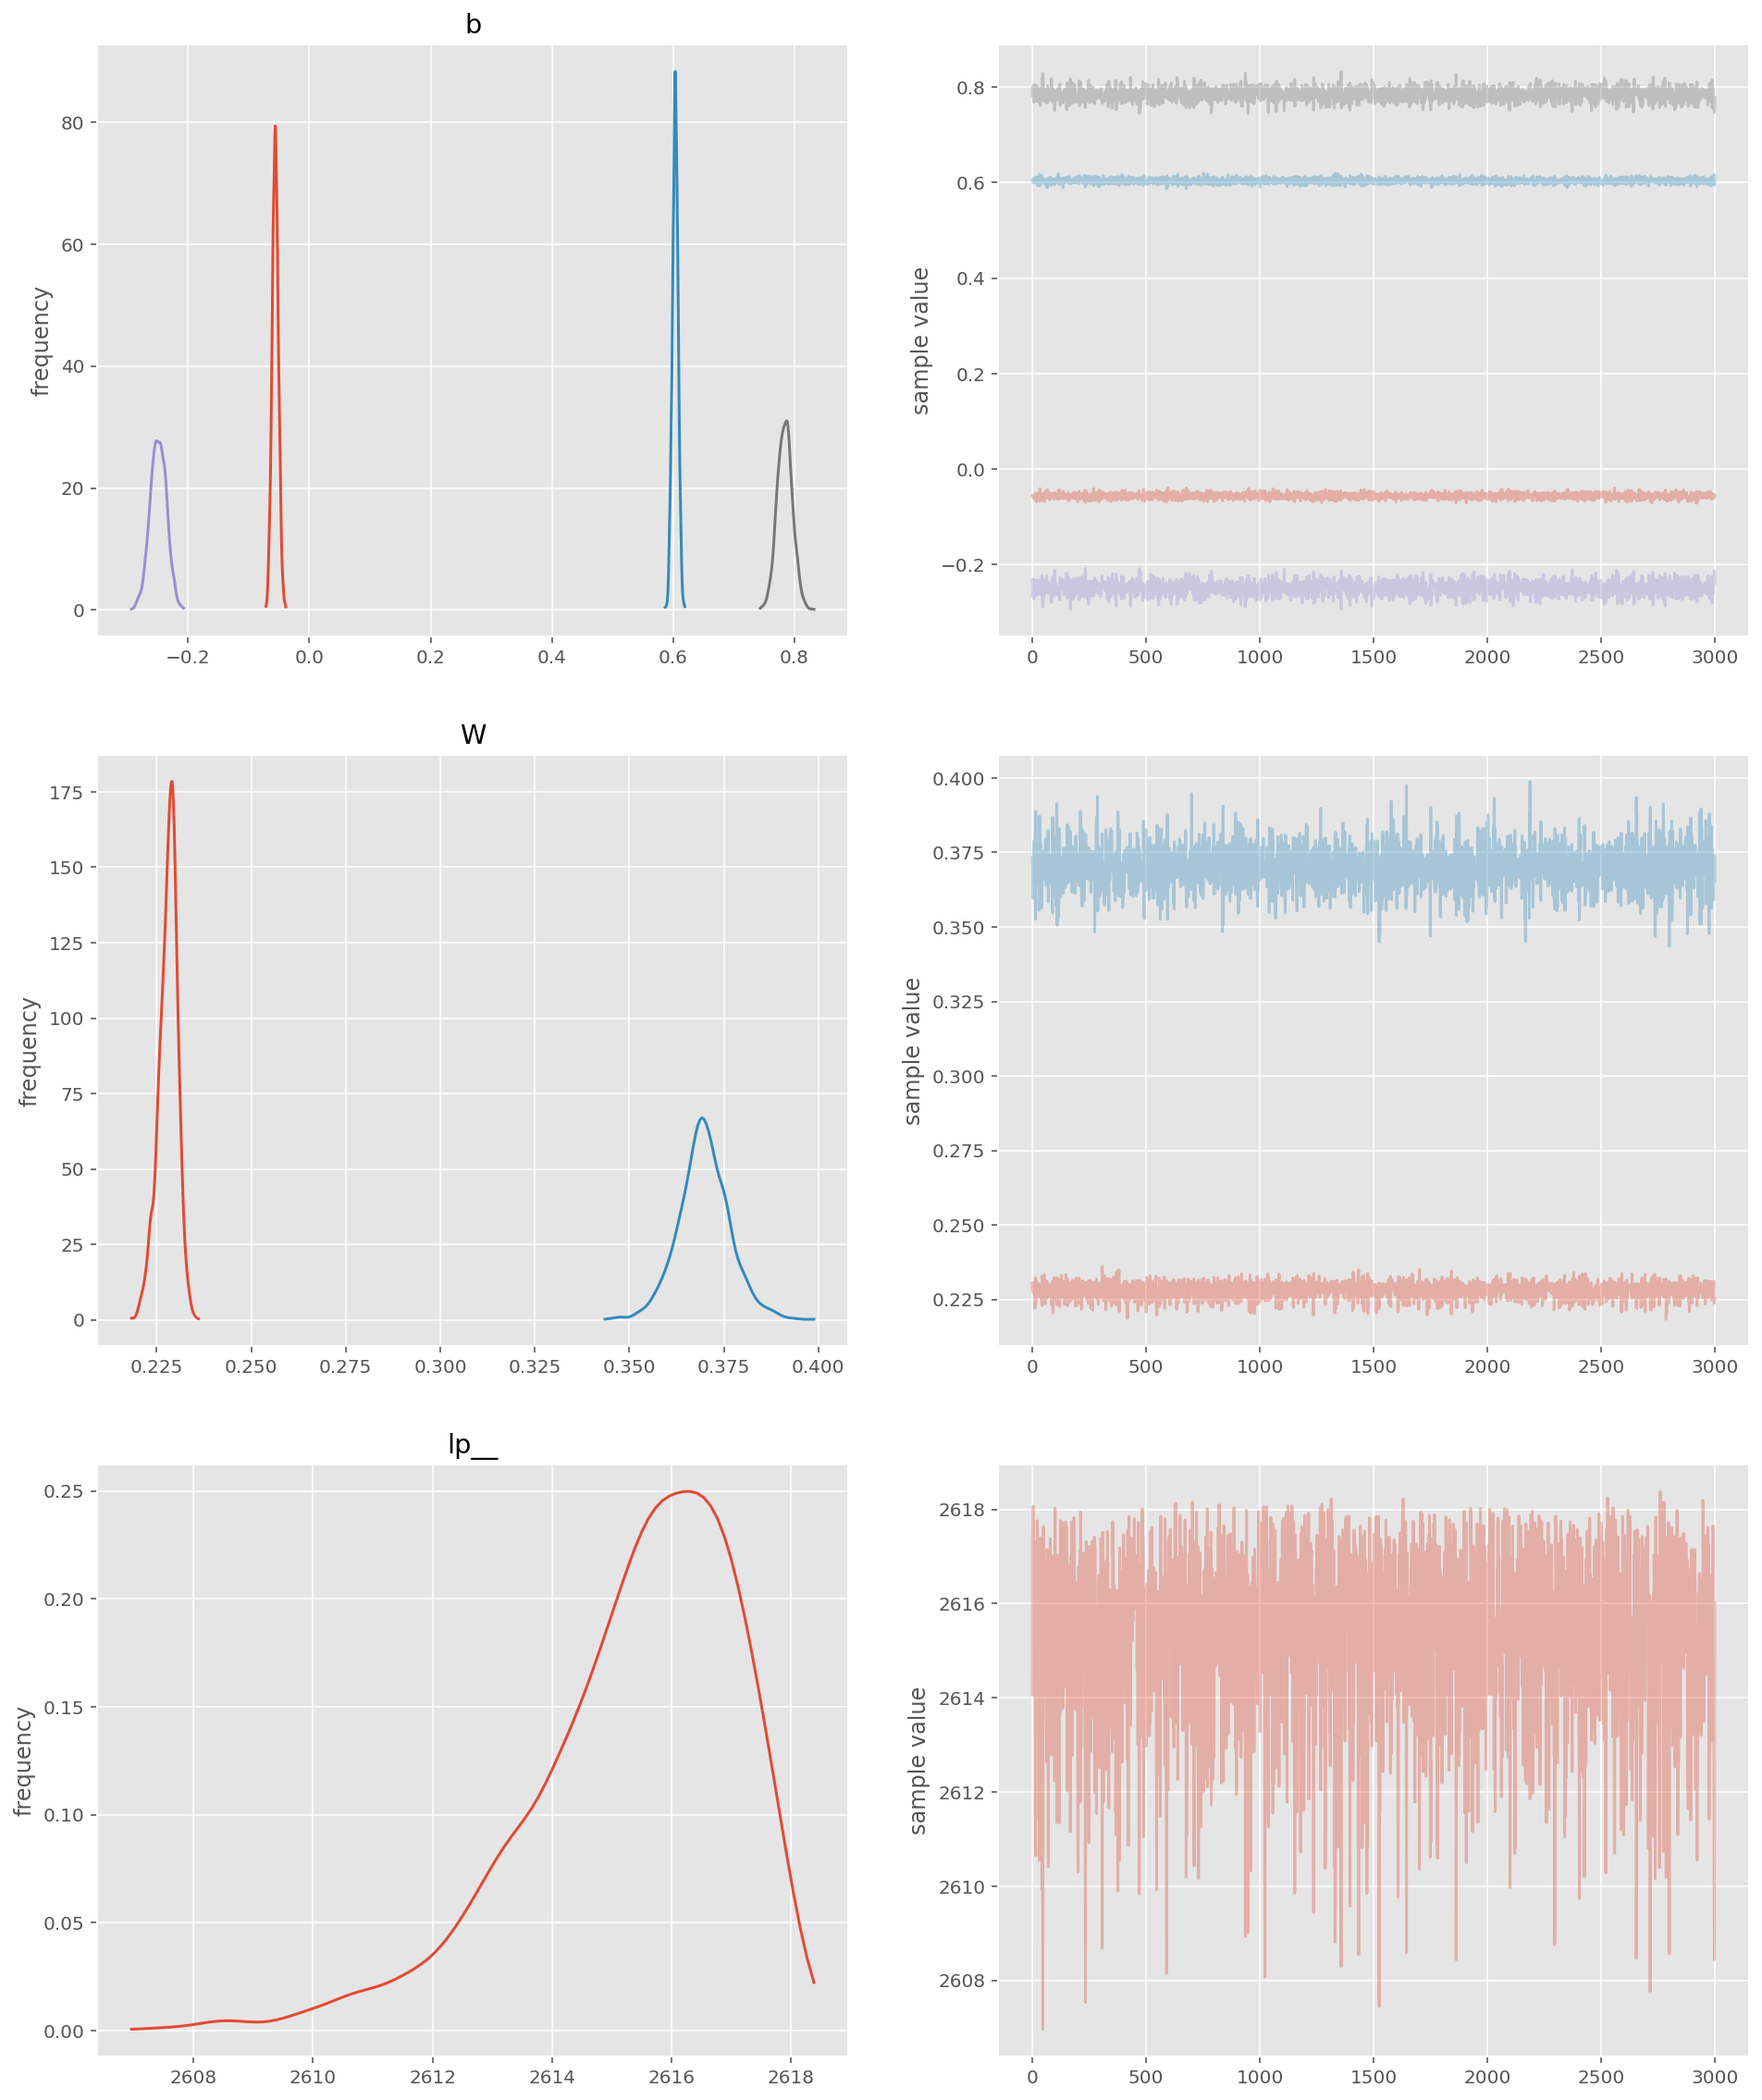

In [ ]:
plt.rcParams['figure.figsize'] = (16, 20)
fit.plot(["b","W","lp__"])
plt.show()

... as well as the model correlation, error and accuracy:

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_test_mean, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.997
MAE: 0.20492
RMSE: 0.47037
R2: 0.896


In [ ]:
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

The following graph shows the forecast of people fully vaccinated for the first country, in order to obatin a more clear representation.

Text(0, 0.5, 'Count')

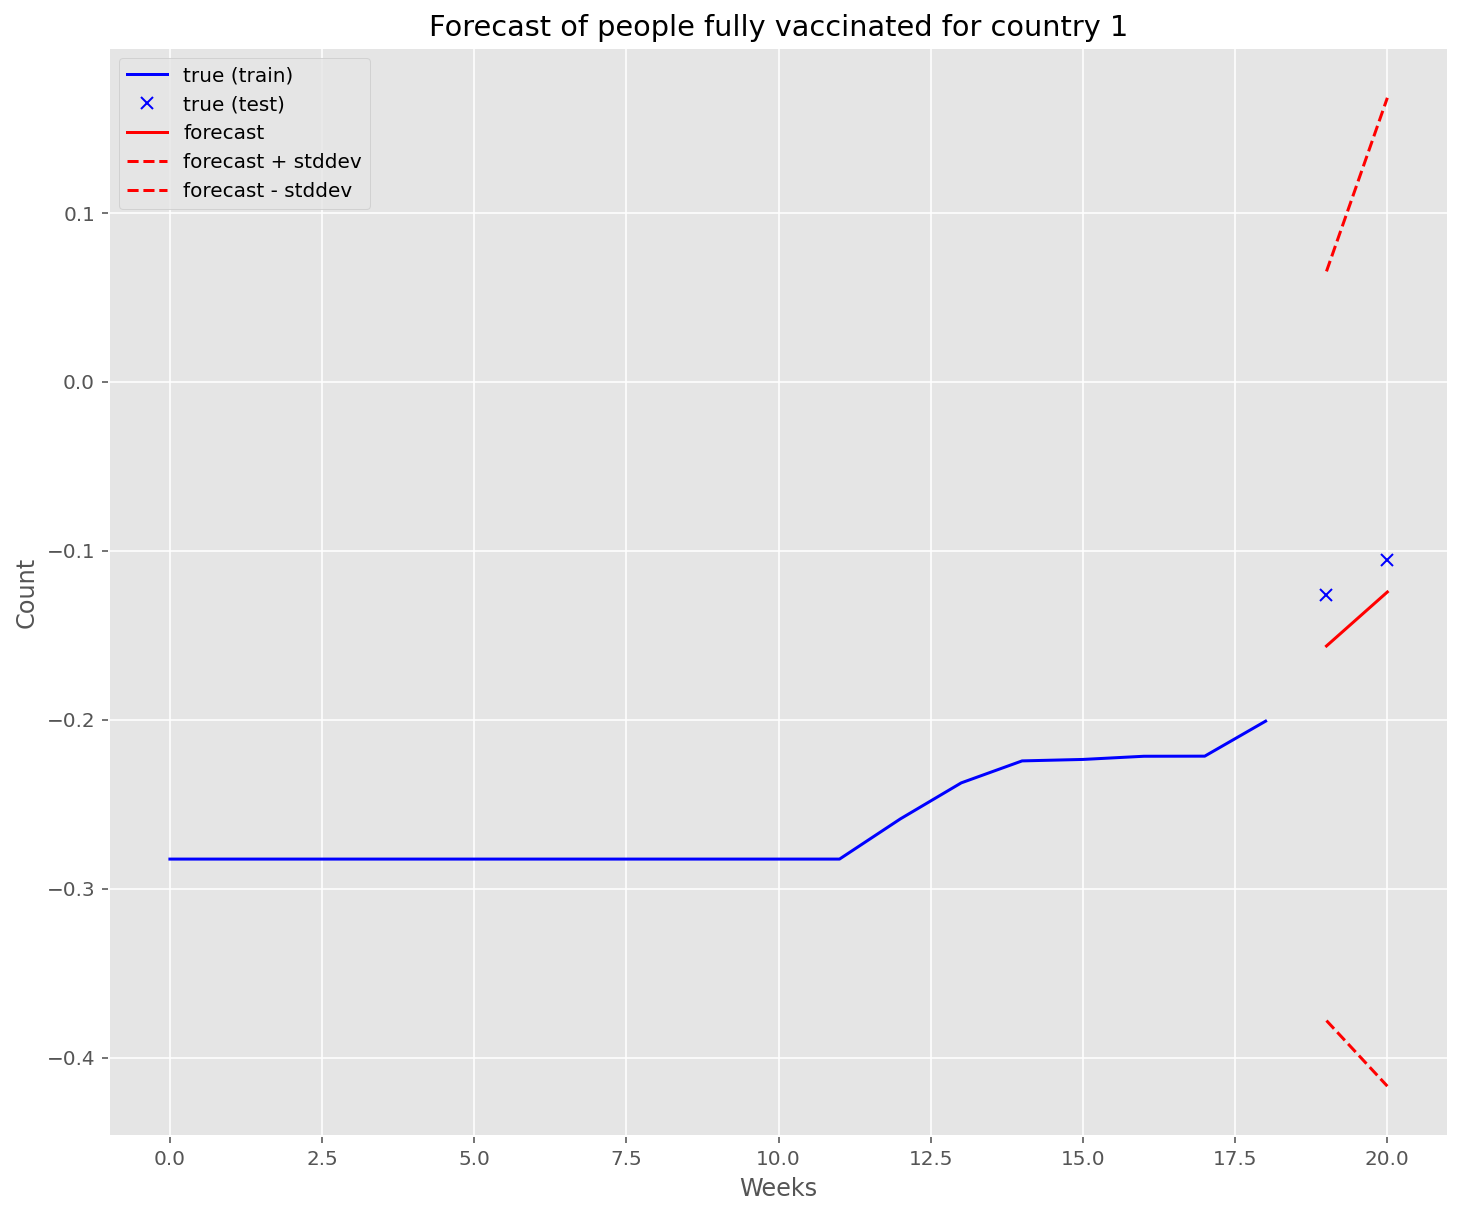

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
for i in range(1):
  plot_predictions(i)
plt.title("Forecast of people fully vaccinated for country 1")
plt.xlabel("Weeks")
plt.ylabel("Count")

The R2 has increased of 0.001, a small improvement, which suggests that the mean and standard deviation of every prior was already close to the optimal value without using the hiearchical model. Moreover, this also means that the quality of the chains was already good, especially due to the fact that we set *iter=1000* and *chains=6* in the sampling to increase convergence of the chains.